In [81]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
# cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.otf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/theoares/miniconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['/Users/theoares/Library/Fonts/cmunrm.otf'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


In [2]:
ensembles = ['24I/ml0p005/', '24I/ml0p01/', '32I/ml0p004/', '32I/ml0p006/']
Lats = [Lattice(24, 64), Lattice(24, 64), Lattice(32, 64), Lattice(32, 64)]
ainv_list = [1.784, 1.784, 2.382, 2.382]    # GeV
mpi_list = [0.3396, 0.4322, 0.3020, 0.3597]    # GeV
a_list = [hbarc / ainv for ainv in ainv_list]
n_ens = len(ensembles)
ampi_list = [mpi_list[i] / ainv_list[i] for i in range(n_ens)]
δainv = np.array([0.005, 0.005, 0.008, 0.008])
δa = hbarc / (np.array(ainv_list) ** 2) * δainv

colors = ['r', 'b', 'c', 'g']

file_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/' + ens + 'Z_gamma.h5' for ens in ensembles]
Fs = [h5py.File(fpath, 'r') for fpath in file_paths]
k_list = [f['momenta'][()] for f in Fs]
mom_list = [[Lats[i].to_linear_momentum(k, datatype=np.float64) for k in k_list[i]] for i in range(n_ens)]
mu_list = [np.array([get_energy_scale(q, a_list[i], Lats[i]) for q in k_list[i]]) for i in range(n_ens)]
Zq_list = [np.real(f['Zq'][()]) for f in Fs]
n_momenta, n_boot = [Zq.shape[0] for Zq in Zq_list], [Zq.shape[1] for Zq in Zq_list]
ZV_list = [np.real(f['ZV'][()]) for f in Fs]
ZA_list = [np.real(f['ZA'][()]) for f in Fs]
Z_list = []
for idx in range(n_ens):
    Z = np.zeros((5, 5, n_momenta[idx], n_boot[idx]), dtype = np.float64)
    f = Fs[idx]
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        Z[i, j] = np.real(f[key][()])
    Z_list.append(Z)

In [3]:
a_list

[0.11060930493273542,
 0.11060930493273542,
 0.0828408900083963,
 0.0828408900083963]

In [4]:
δa

array([0.00031   , 0.00031   , 0.00027822, 0.00027822])

In [5]:
mu_list[0]

array([1.30597864, 1.93098769, 2.522957  , 3.07175781, 3.568     ,
       4.00319272, 4.3698897 , 4.66181666])

In [6]:
# read out chiral extrap data
n_spacings = 2
n_ens_sp = 2    # 2 ensembles per lattice spacing
n_mom = n_momenta[0]
Lat_24I = Lattice(24, 64)
Lat_32I = Lattice(32, 64)
Z_extrap = np.zeros((n_spacings, 5, 5, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
Z_extrap_mu = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)          # [24I/32I, i, j, q_idx]
Z_extrap_sigma = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)
chi_extrap_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/chiral_extrap/Z_extrap_const.h5', \
                    '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/chiral_extrap/Z_extrap_const.h5']
for idx in range(2):
    f = h5py.File(chi_extrap_paths[idx], 'r')
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        try:
            Z_extrap[idx, i, j] = np.real(f[key][()])
        except:
            print('no key at ' + key)
for sp_idx in range(n_spacings):
    for i, j in itertools.product(range(5), repeat = 2):
        for mom_idx in range(n_mom):
            Z_tmp = Superboot(n_ens_sp)
            Z_tmp.boots = Z_extrap[sp_idx, i, j, mom_idx]
            Z_extrap_mu[sp_idx, i, j, mom_idx] = Z_tmp.compute_mean()
            Z_extrap_sigma[sp_idx, i, j, mom_idx] = Z_tmp.compute_std()
stagger = 1e-5    # offsets the chiral extrap from the original data so you can see the errorbar difference
k_list_chiral = f['momenta'][()]
f.close()
mom_list_24I = [Lat_24I.to_linear_momentum(k, datatype = np.float64) for k in k_list_chiral]
mom_list_32I = [Lat_32I.to_linear_momentum(k, datatype = np.float64) for k in k_list_chiral]

no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z24
no key at Z25
no key at Z31
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z51
no key at Z52
no key at Z53
no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z24
no key at Z25
no key at Z31
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z51
no key at Z52
no key at Z53


In [7]:
# linear chiral extrap
Zq_extrap = np.zeros((n_spacings, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
Zq_extrap_mu = np.zeros((n_spacings, n_mom), dtype = np.float64)
Zq_extrap_sigma = np.zeros((n_spacings, n_mom), dtype = np.float64)
ZV_extrap = np.zeros((n_spacings, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
ZV_extrap_mu = np.zeros((n_spacings, n_mom), dtype = np.float64)
ZV_extrap_sigma = np.zeros((n_spacings, n_mom), dtype = np.float64)
ZA_extrap = np.zeros((n_spacings, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
ZA_extrap_mu = np.zeros((n_spacings, n_mom), dtype = np.float64)
ZA_extrap_sigma = np.zeros((n_spacings, n_mom), dtype = np.float64)
Z_extrap_lin = np.zeros((n_spacings, 5, 5, n_mom, n_ens_sp, n_boot[0]), dtype = np.float64)
Z_extrap_lin_mu = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)          # [24I/32I, i, j, q_idx]
Z_extrap_lin_sigma = np.zeros((n_spacings, 5, 5, n_mom), dtype = np.float64)
chi_extrap_lin_paths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/chiral_extrap/Z_extrap.h5', \
                    '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/chiral_extrap/Z_extrap.h5']
for idx in range(2):
    print(chi_extrap_lin_paths[idx])
    f = h5py.File(chi_extrap_lin_paths[idx], 'r')
    Zq_extrap[idx] = np.real(f['Zq/values'][()])
    ZV_extrap[idx] = np.real(f['ZV/value'][()])
    ZA_extrap[idx] = np.real(f['ZA/value'][()])
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        try:
            Z_extrap_lin[idx, i, j] = np.real(f[key][()])
        except:
            print('no key at ' + key)
for sp_idx in range(n_spacings):
    for mom_idx in range(n_mom):
        Zq_tmp = Superboot(n_ens_sp)
        Zq_tmp.boots = Zq_extrap[sp_idx, mom_idx]
        Zq_extrap_mu[sp_idx, mom_idx] = Zq_tmp.compute_mean()
        Zq_extrap_sigma[sp_idx, mom_idx] = Zq_tmp.compute_std()
        ZV_tmp = Superboot(n_ens_sp)
        ZV_tmp.boots = ZV_extrap[sp_idx, mom_idx]
        ZV_extrap_mu[sp_idx, mom_idx] = ZV_tmp.compute_mean()
        ZV_extrap_sigma[sp_idx, mom_idx] = ZV_tmp.compute_std()
        ZA_tmp = Superboot(n_ens_sp)
        ZA_tmp.boots = ZA_extrap[sp_idx, mom_idx]
        ZA_extrap_mu[sp_idx, mom_idx] = ZA_tmp.compute_mean()
        ZA_extrap_sigma[sp_idx, mom_idx] = ZA_tmp.compute_std()
        for i, j in itertools.product(range(5), repeat = 2):
            Z_tmp = Superboot(n_ens_sp)
            Z_tmp.boots = Z_extrap_lin[sp_idx, i, j, mom_idx]
            Z_extrap_lin_mu[sp_idx, i, j, mom_idx] = Z_tmp.compute_mean()
            Z_extrap_lin_sigma[sp_idx, i, j, mom_idx] = Z_tmp.compute_std()

/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/chiral_extrap/Z_extrap.h5
no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z24
no key at Z25
no key at Z31
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z51
no key at Z52
no key at Z53
/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/chiral_extrap/Z_extrap.h5
no key at Z12
no key at Z13
no key at Z14
no key at Z15
no key at Z21
no key at Z24
no key at Z25
no key at Z31
no key at Z34
no key at Z35
no key at Z41
no key at Z42
no key at Z43
no key at Z51
no key at Z52
no key at Z53


### Plot and determine a value for $Z_V^a$ at each lattice spacing

<IPython.core.display.Javascript object>


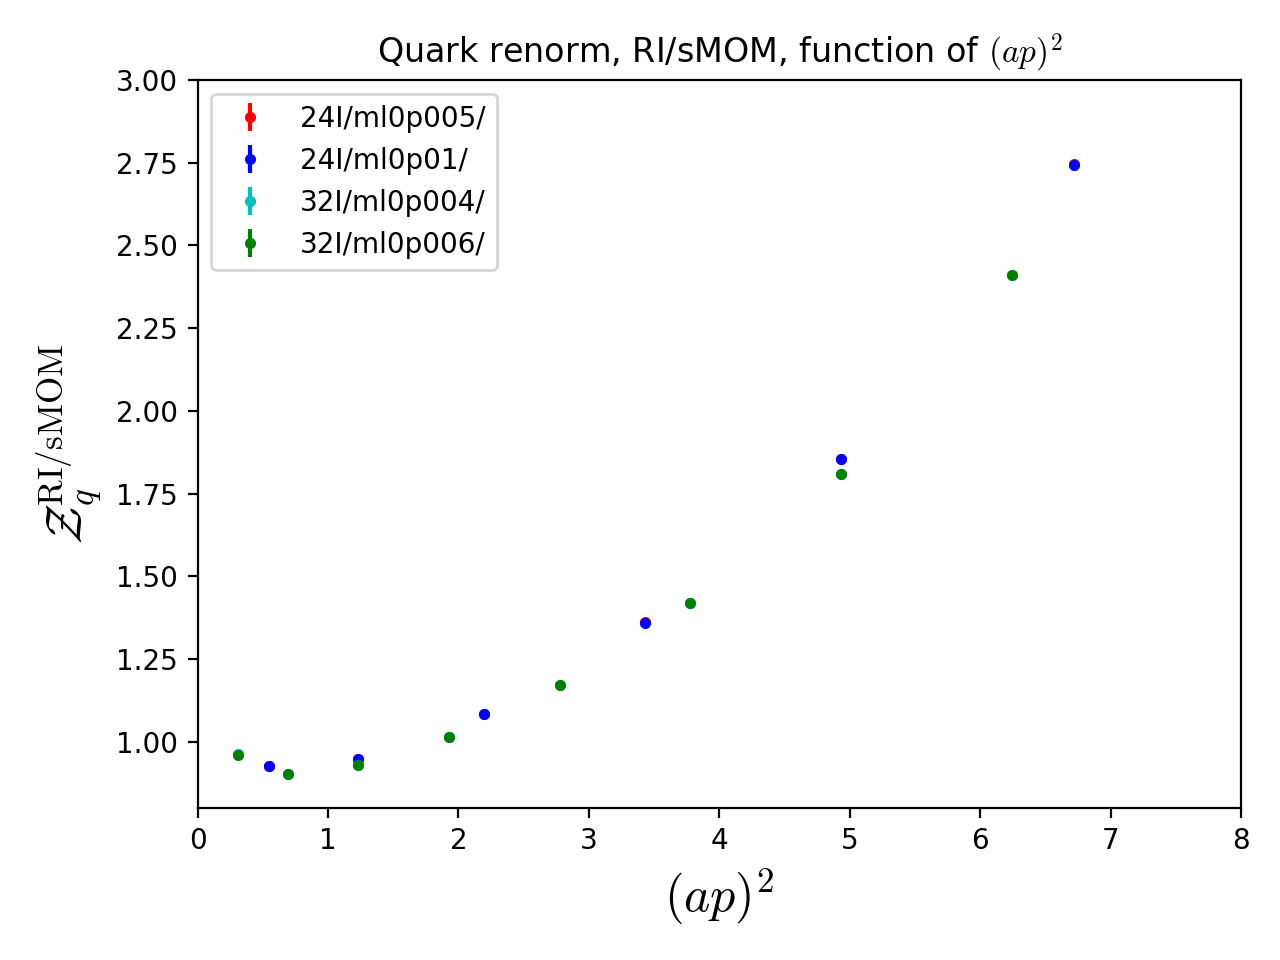

In [8]:
# Zq((ap)^2)
Zq_mu_list = [np.mean(Zq, axis = 1) for Zq in Zq_list]
Zq_sigma_list = [np.std(Zq, axis = 1, ddof = 1) for Zq in Zq_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Zq_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.ylim((0.8, 3))
plt.xlim((0, 8))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Quark renorm, RI/sMOM, function of $(ap)^2$')
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


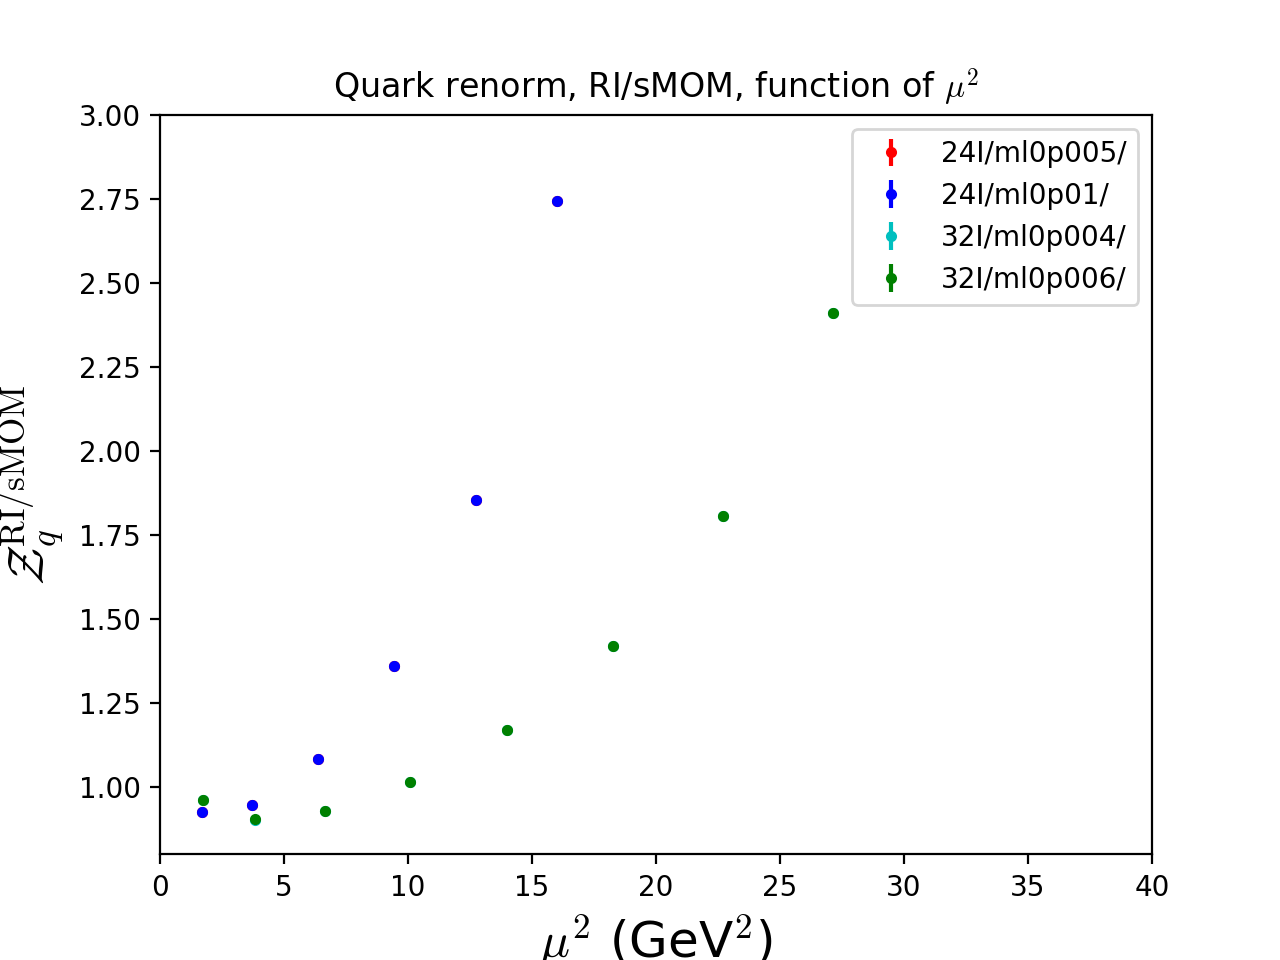

In [9]:
# Zq (μ^2)
plt.figure()
for idx in range(n_ens):
    plt.errorbar([mu ** 2 for mu in mu_list[idx]], Zq_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.ylim((0.8, 3))
plt.xlim((0, 40))
plt.xlabel('$\mu^2$ (GeV$^2$)', fontsize = 18)
plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Quark renorm, RI/sMOM, function of $\mu^2$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


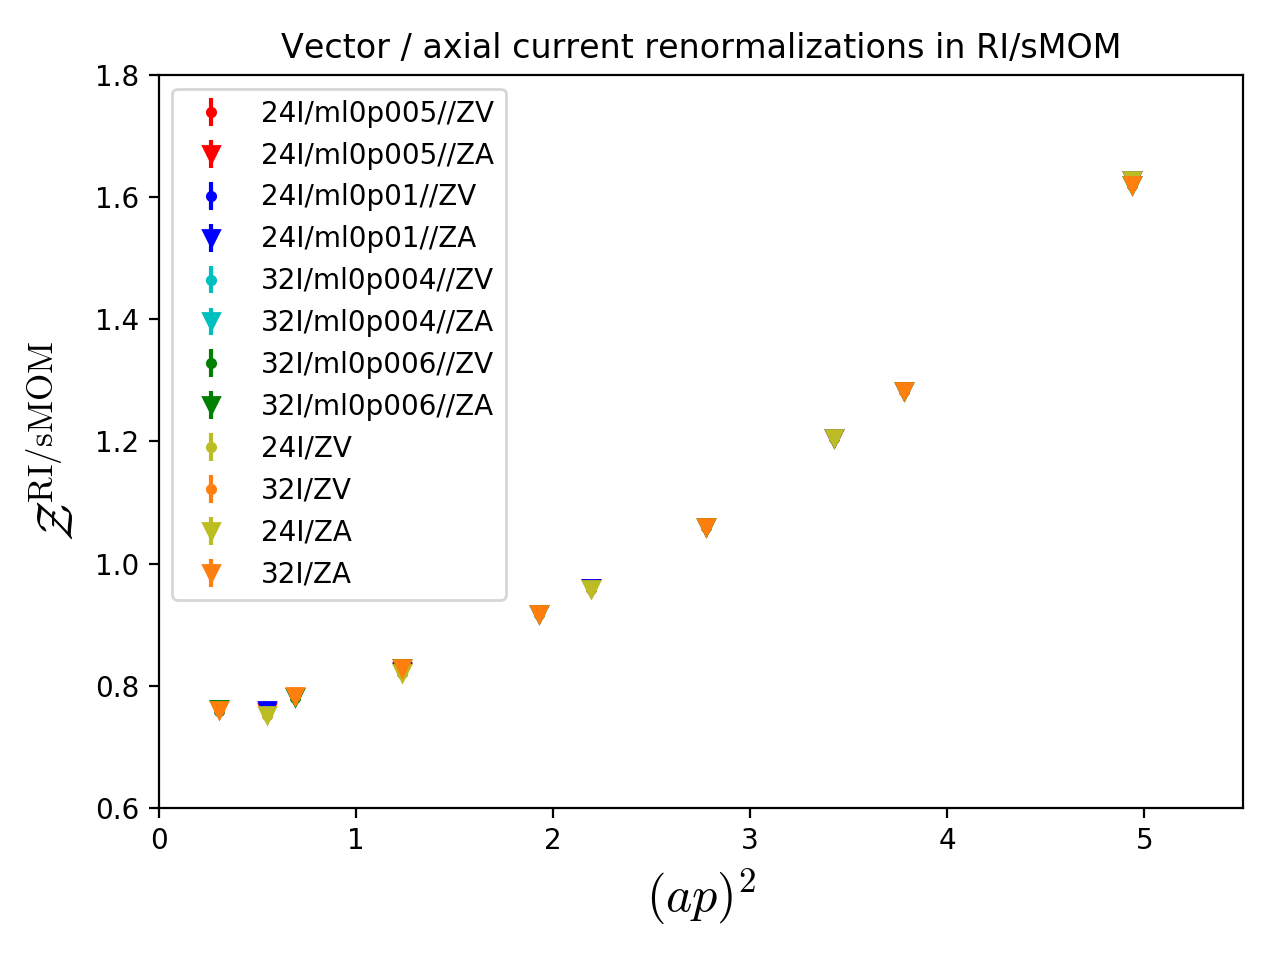

In [10]:
# ZV and ZA
ZV_mu_list = [np.mean(ZV, axis = 1) for ZV in ZV_list]
ZV_sigma_list = [np.std(ZV, axis = 1, ddof = 1) for ZV in ZV_list]
ZA_mu_list = [np.mean(ZA, axis = 1) for ZA in ZA_list]
ZA_sigma_list = [np.std(ZA, axis = 1, ddof = 1) for ZA in ZA_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], ZV_mu_list[idx], ZV_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + '/ZV')
    plt.errorbar([square(k) for k in mom_list[idx]], ZA_mu_list[idx], ZA_sigma_list[idx], fmt = 'v', c = colors[idx], label = ensembles[idx] + '/ZA')

plt.errorbar([square(k) - stagger for k in mom_list_24I], ZV_extrap_mu[0], ZV_extrap_sigma[0], fmt = '.', c = 'tab:olive', label = '24I/ZV')
plt.errorbar([square(k) - stagger for k in mom_list_32I], ZV_extrap_mu[1], ZV_extrap_sigma[1], fmt = '.', c = 'tab:orange', label = '32I/ZV')

plt.errorbar([square(k) - stagger for k in mom_list_24I], ZA_extrap_mu[0], ZA_extrap_sigma[0], fmt = 'v', c = 'tab:olive', label = '24I/ZA')
plt.errorbar([square(k) - stagger for k in mom_list_32I], ZA_extrap_mu[1], ZA_extrap_sigma[1], fmt = 'v', c = 'tab:orange', label = '32I/ZA')
plt.ylim((0.6, 1.8))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Vector / axial current renormalizations in RI/sMOM')
plt.legend()
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


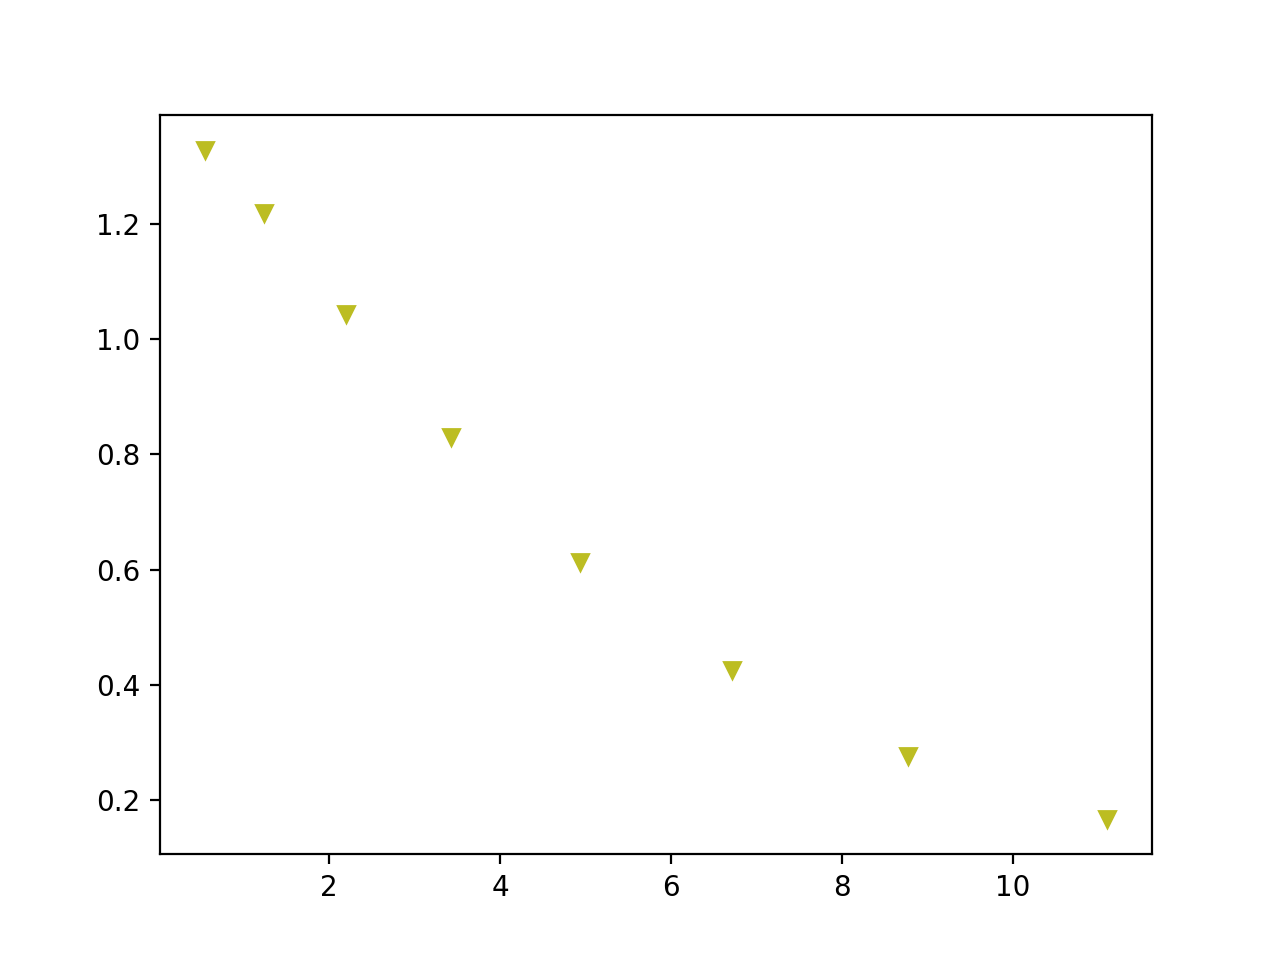

In [11]:
plt.figure()
plt.errorbar([square(k) for k in mom_list_24I], 1 / ZA_extrap_mu[0], ZA_extrap_sigma[0], fmt = 'v', c = 'tab:olive', label = '24I/ZA')
plt.show()

<IPython.core.display.Javascript object>


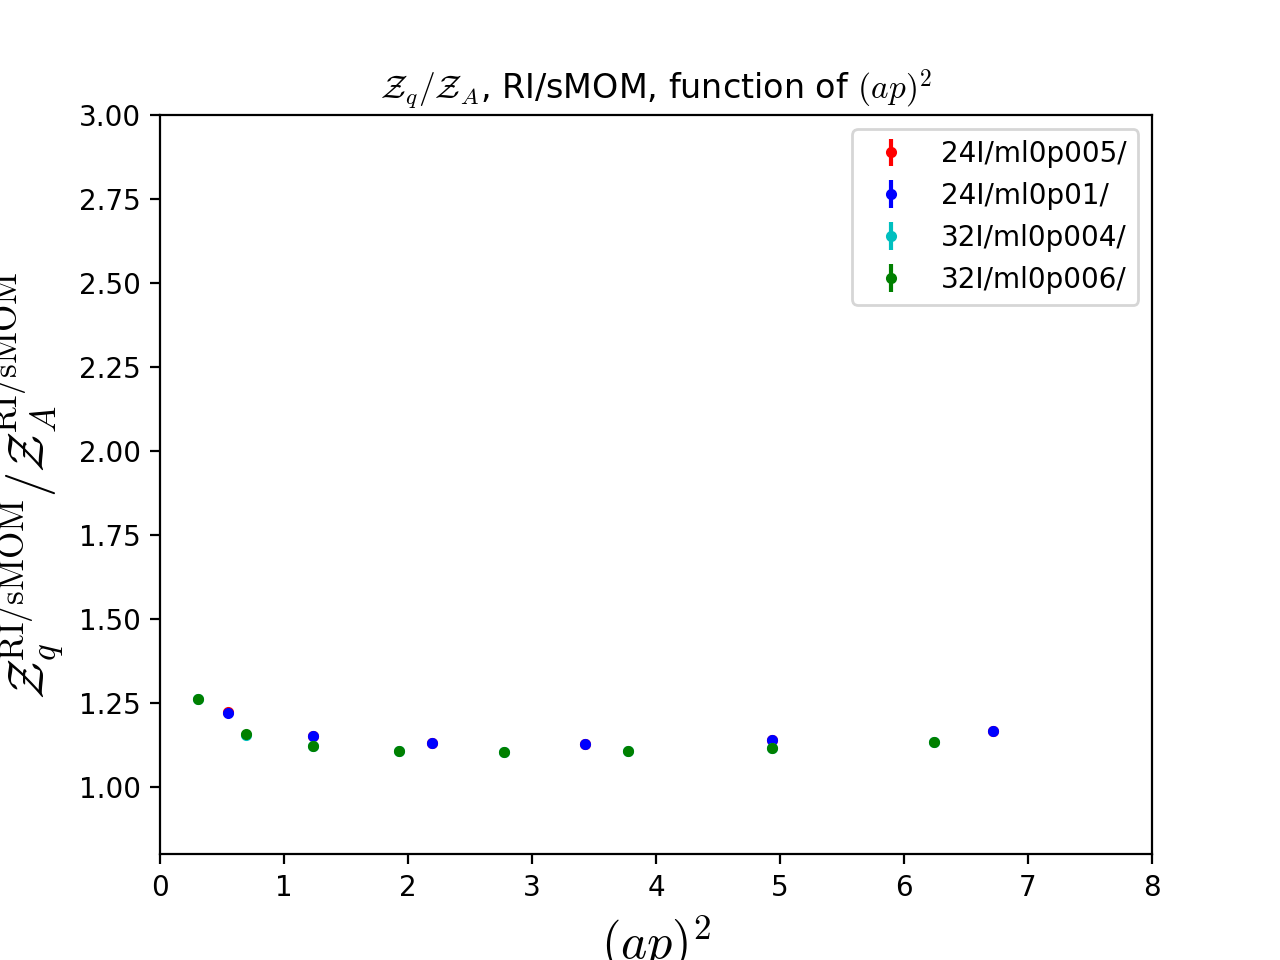

In [12]:
# Zq / ZA
Zq_mu_list = [np.mean(Zq, axis = 1) for Zq in Zq_list]
Zq_sigma_list = [np.std(Zq, axis = 1, ddof = 1) for Zq in Zq_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Zq_mu_list[idx] / ZA_mu_list[idx], Zq_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.ylim((0.8, 3))
plt.xlim((0, 8))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM} / \mathcal{Z}_A^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$\mathcal{Z}_q / \mathcal{Z}_A$, RI/sMOM, function of $(ap)^2$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


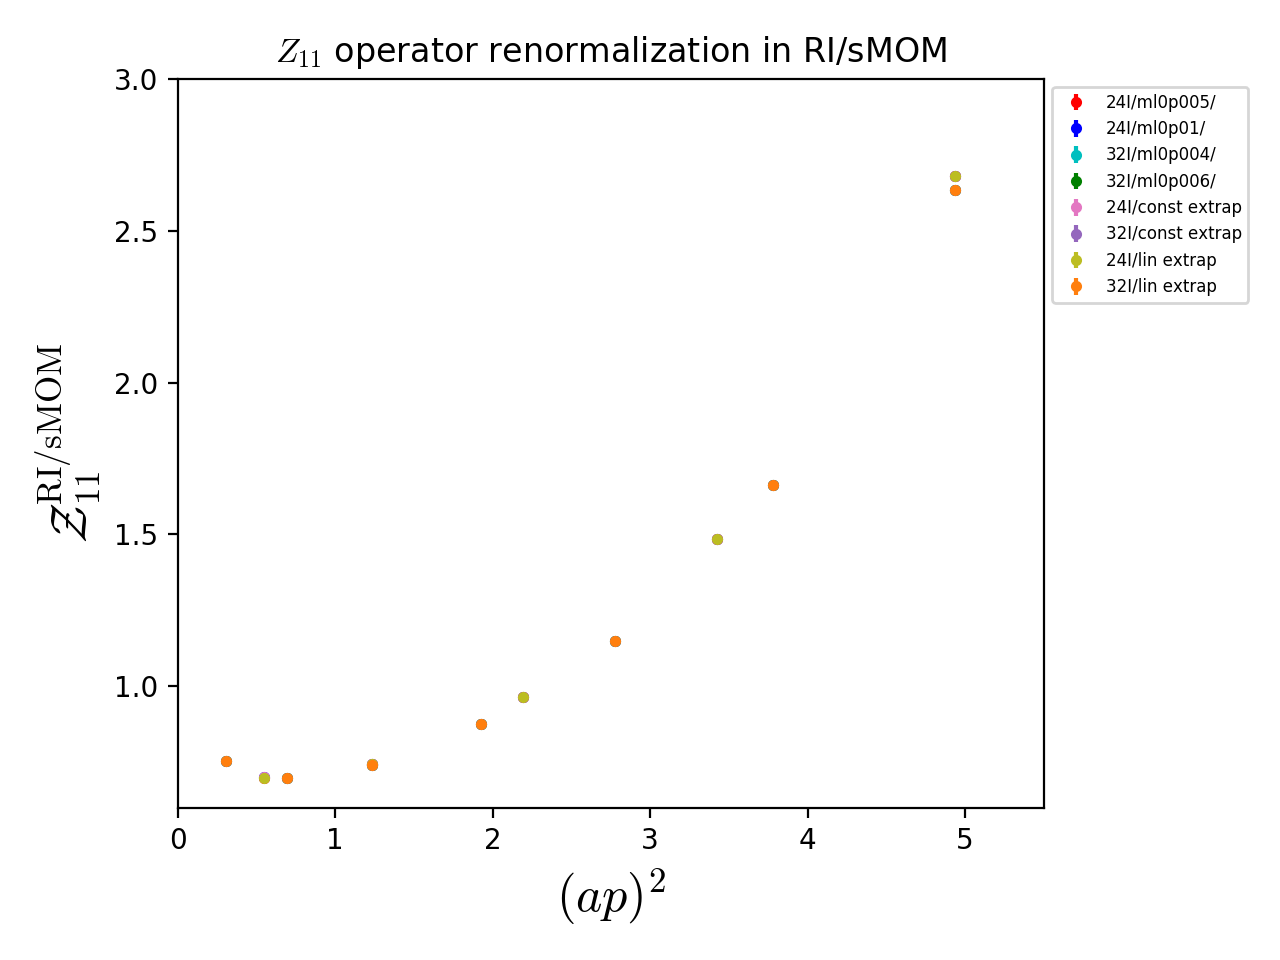

In [13]:
# Z11
Z11_mu_list = [np.mean(Z[0, 0], axis = 1) for Z in Z_list]
Z11_sigma_list = [np.std(Z[0, 0], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z11_mu_list[idx], Z11_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 0, 0], Z_extrap_sigma[0, 0, 0], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 0, 0], Z_extrap_sigma[1, 0, 0], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 0, 0], Z_extrap_lin_sigma[0, 0, 0], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 0, 0], Z_extrap_lin_sigma[1, 0, 0], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.6, 3))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}_{11}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{11}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


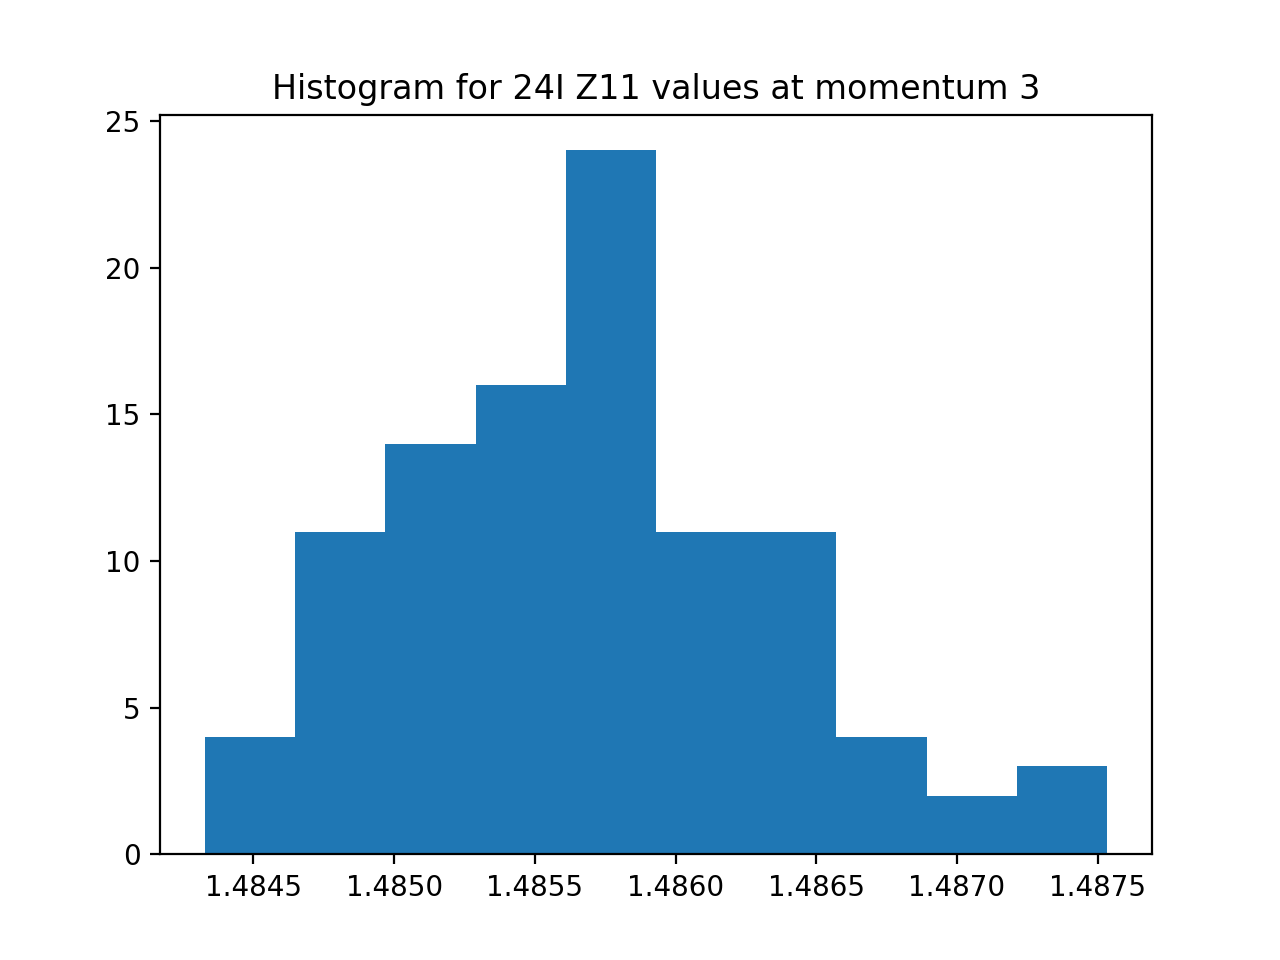

In [14]:
# are the points Gaussian distributed?
q_idx = 3
hist_data = np.reshape(Z_extrap[0, 0, 0, q_idx], (100,))
plt.figure()
plt.hist(hist_data)
plt.title('Histogram for 24I Z11 values at momentum ' + str(q_idx))
plt.show()

<IPython.core.display.Javascript object>


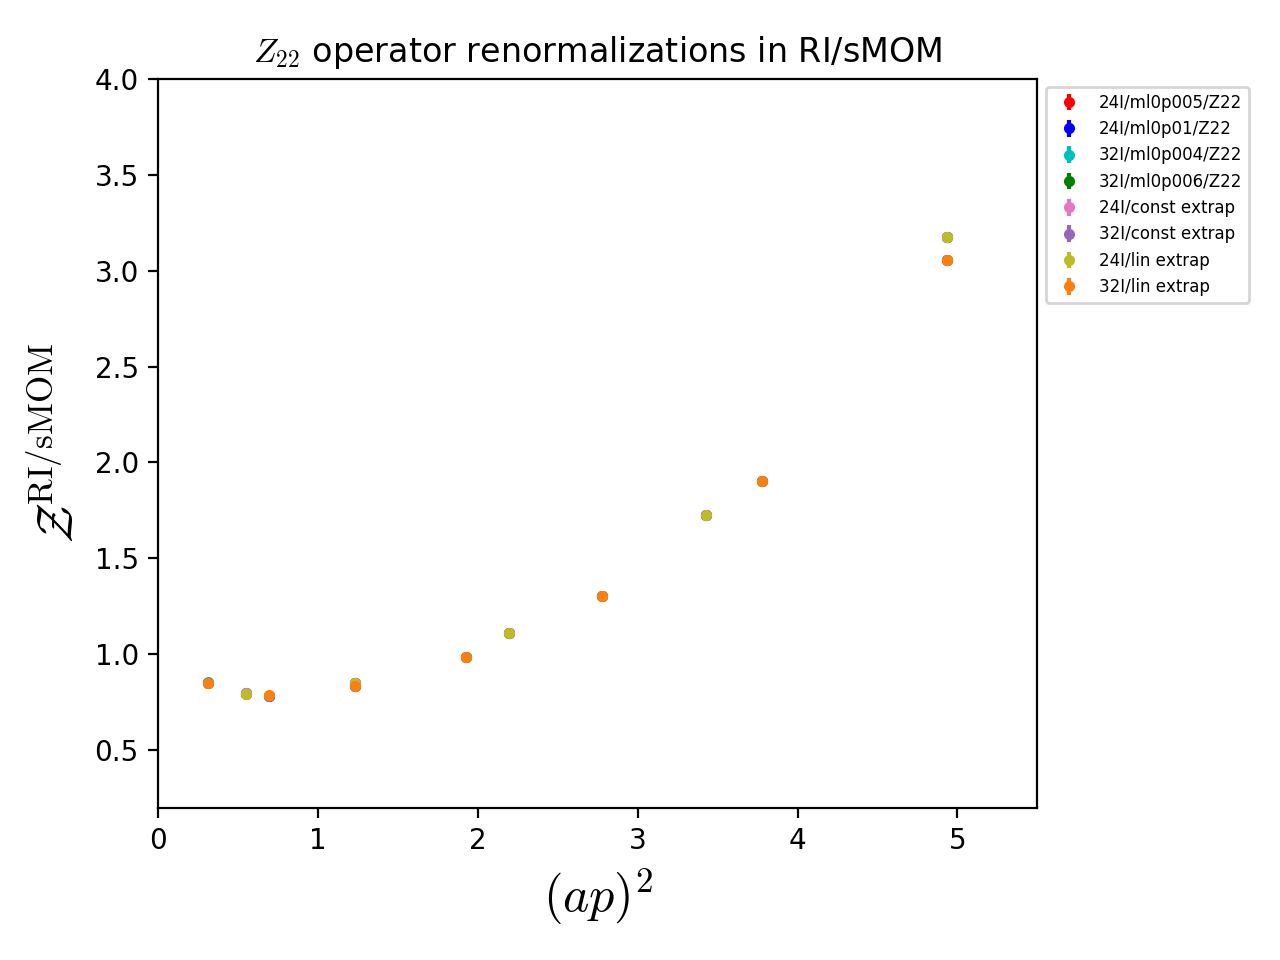

In [15]:
# Z22
Z22_mu_list = [np.mean(Z[1, 1], axis = 1) for Z in Z_list]
Z22_sigma_list = [np.std(Z[1, 1], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z22_mu_list[idx], Z22_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + 'Z22')
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 1, 1], Z_extrap_sigma[0, 1, 1], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 1, 1], Z_extrap_sigma[1, 1, 1], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 1], Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 1, 1], Z_extrap_lin_sigma[1, 1, 1], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.2, 4))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{22}$ operator renormalizations in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


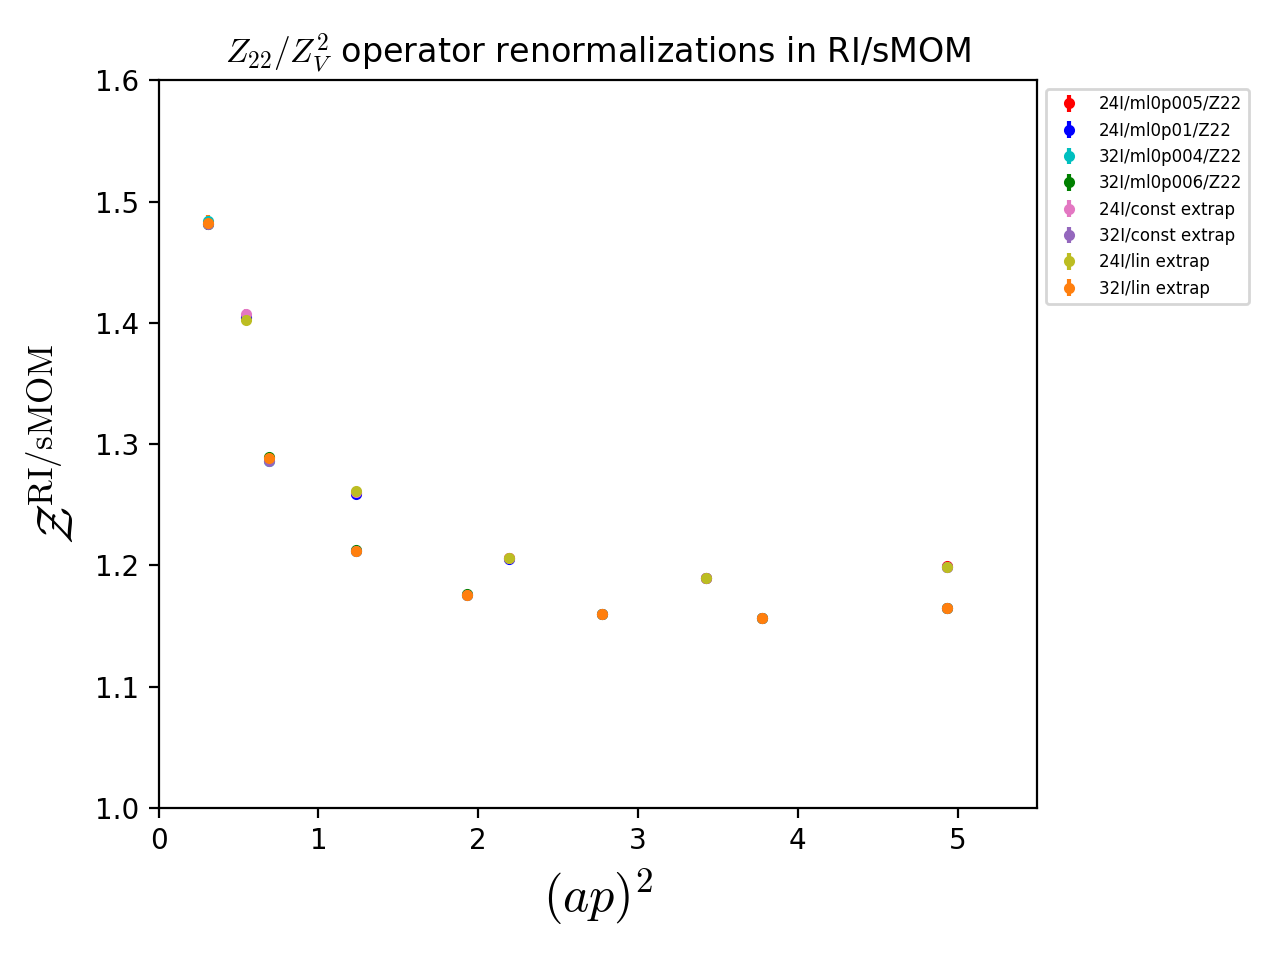

In [16]:
# Z22 / ZV^2 (very roughly, no error propagation yet. Just wanted to see general shape)
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z22_mu_list[idx] / (ZV_mu_list[idx] ** 2), Z22_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + 'Z22')
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_sigma[0, 1, 1], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 1, 1] / (ZV_mu_list[2] ** 2), Z_extrap_sigma[1, 1, 1], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 1, 1] / (ZV_mu_list[2] ** 2), Z_extrap_lin_sigma[1, 1, 1], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((1, 1.6))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{22} / Z_V^2$ operator renormalizations in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


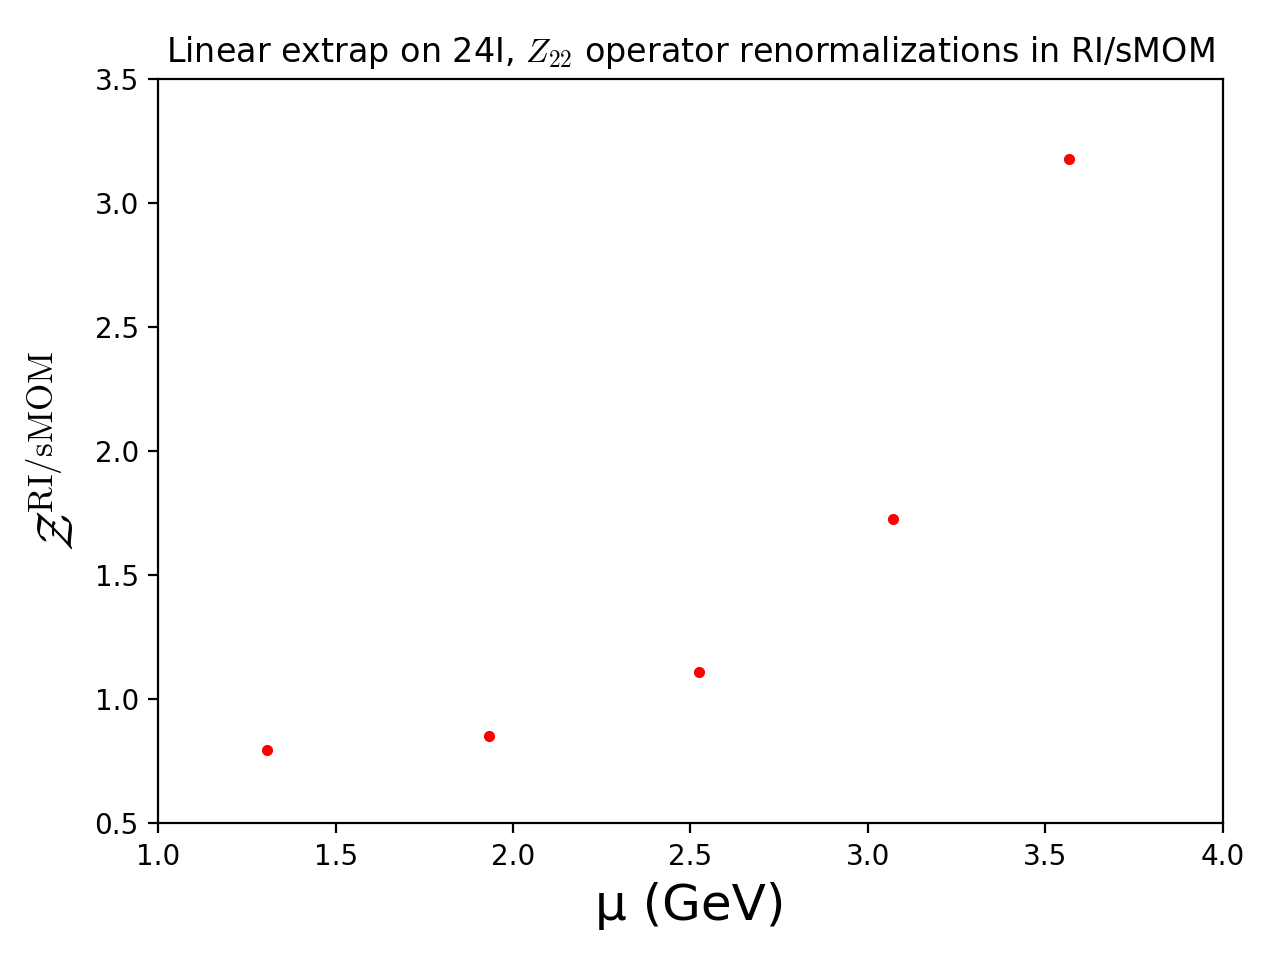

In [17]:
# Z22 / ZV^2 (very roughly, no error propagation yet. Just wanted to see general shape)
plt.figure()
# plot linear extrap too
# plt.errorbar([square(k) for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar(mu_list[0], Z_extrap_lin_mu[0, 1, 1], Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'r')

plt.ylim((0.5, 3.5))
plt.xlim((1, 4))
plt.xlabel('μ (GeV)', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('Linear extrap on 24I, $Z_{22}$ operator renormalizations in RI/sMOM')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


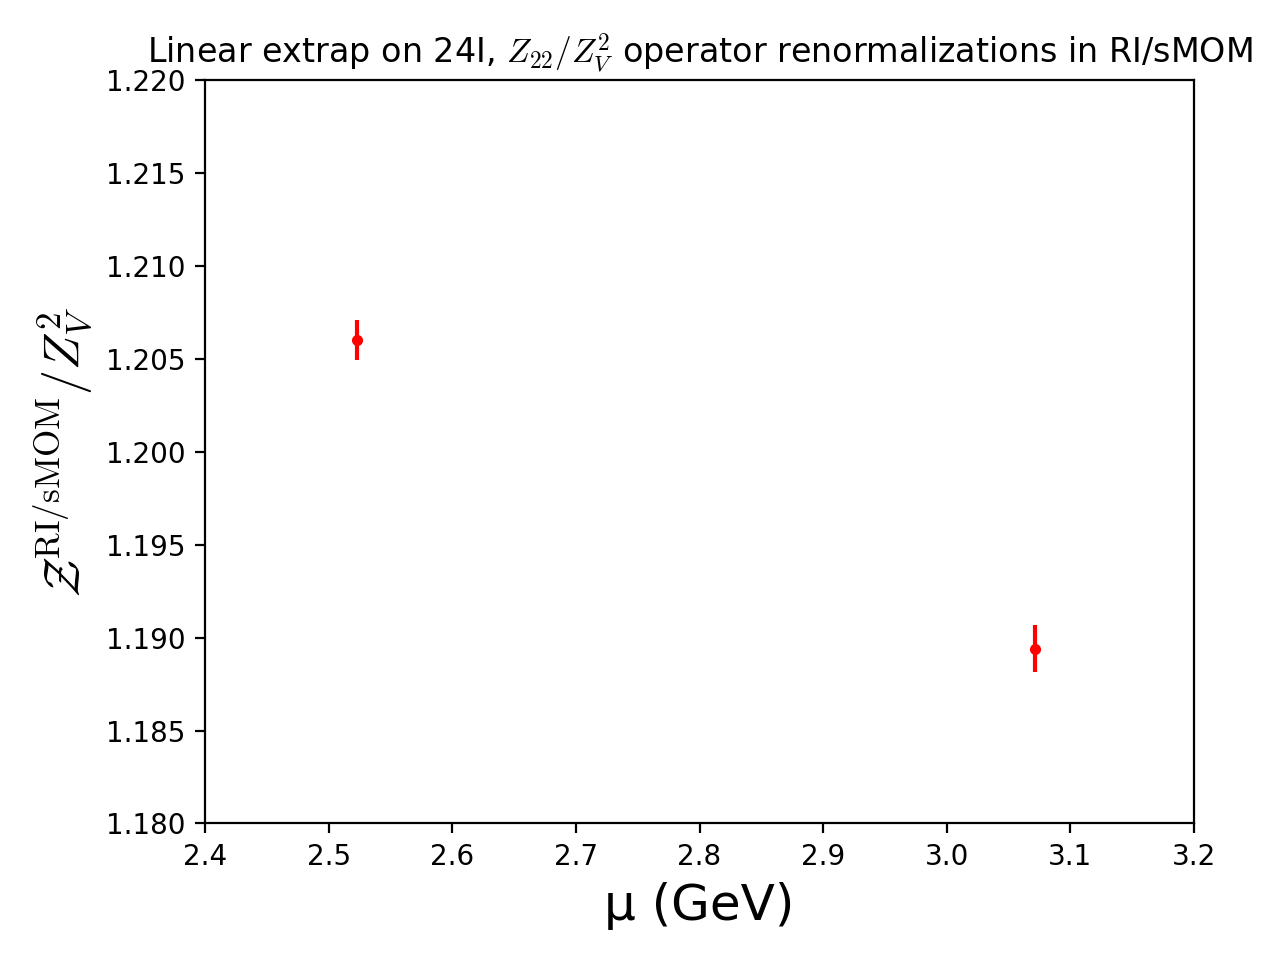

In [18]:
# Z22 / ZV^2 (very roughly, no error propagation yet. Just wanted to see general shape)
plt.figure()
plt.errorbar(mu_list[0], Z_extrap_lin_mu[0, 1, 1] / (ZV_mu_list[0] ** 2), Z_extrap_lin_sigma[0, 1, 1], fmt = '.', c = 'r')

# plt.ylim((1.15, 1.3))
# plt.xlim((1, 4.1))
plt.ylim((1.18, 1.22))
plt.xlim((2.4, 3.2))
plt.xlabel('μ (GeV)', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM} / Z_V^2$', fontsize = 18)
plt.title('Linear extrap on 24I, $Z_{22} / Z_V^2$ operator renormalizations in RI/sMOM')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


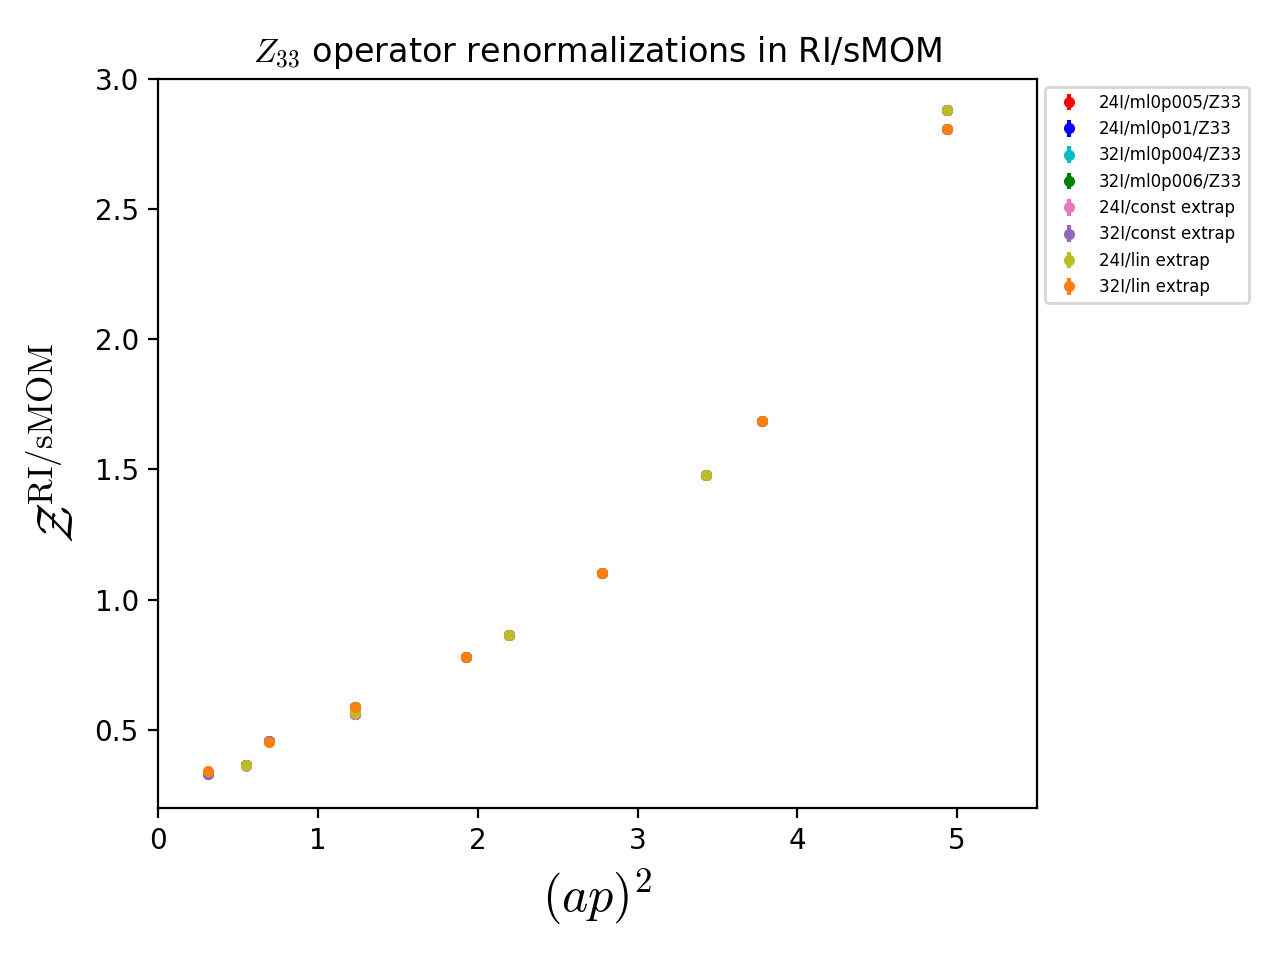

In [19]:
# Z33 
Z33_mu_list = [np.mean(Z[2, 2], axis = 1) for Z in Z_list]
Z33_sigma_list = [np.std(Z[2, 2], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z33_mu_list[idx], Z33_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx] + 'Z33')
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 2, 2], Z_extrap_sigma[0, 2, 2], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 2, 2], Z_extrap_sigma[1, 2, 2], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 2, 2], Z_extrap_lin_sigma[0, 2, 2], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 2, 2], Z_extrap_lin_sigma[1, 2, 2], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.2, 3))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{33}$ operator renormalizations in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


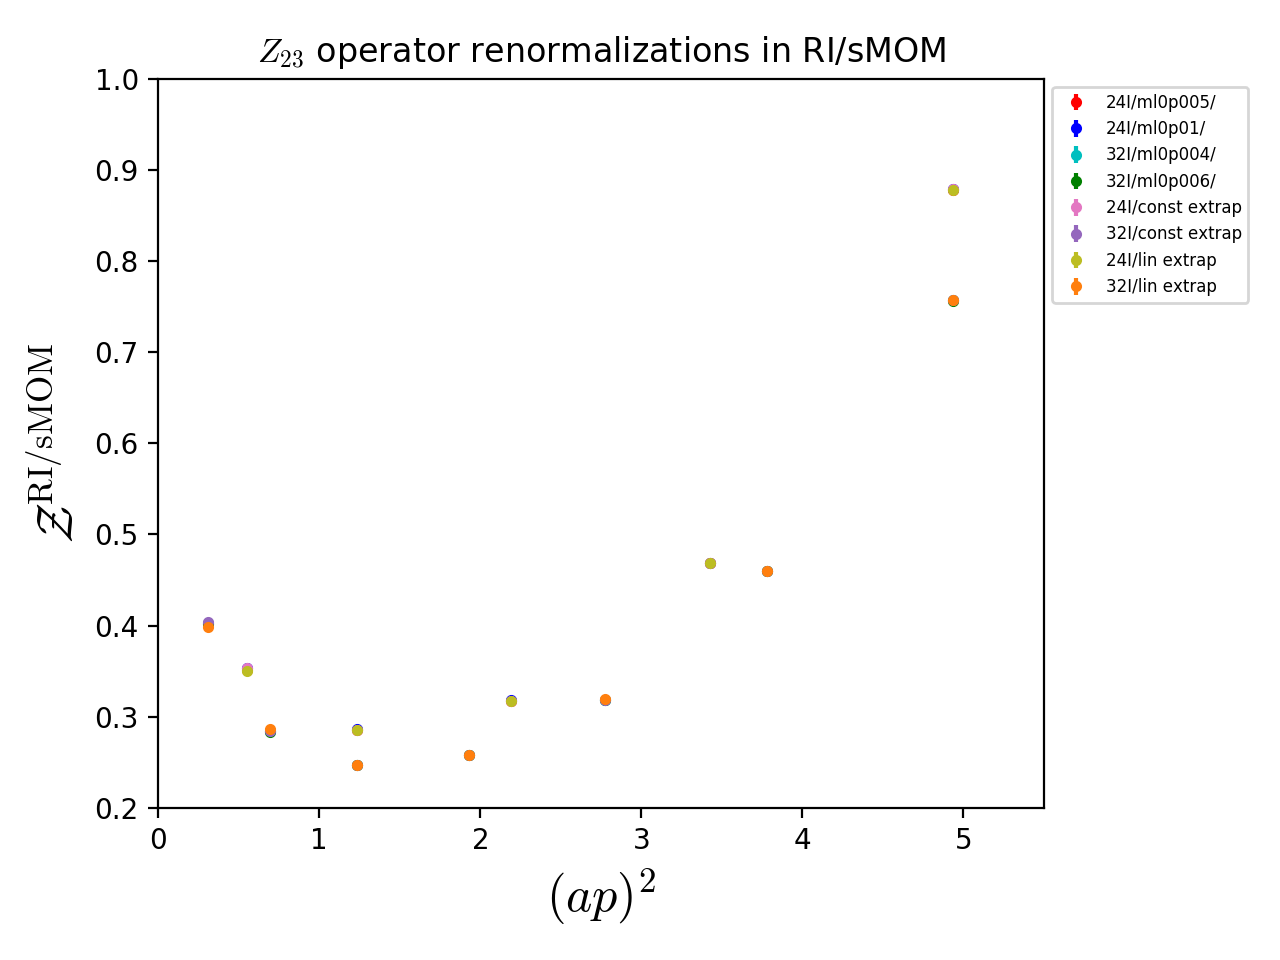

In [20]:
# Z23
Z23_mu_list = [np.mean(Z[1, 2], axis = 1) for Z in Z_list]
Z23_sigma_list = [np.std(Z[1, 2], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z23_mu_list[idx], Z23_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 1, 2], Z_extrap_sigma[0, 1, 2], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 1, 2], Z_extrap_sigma[1, 1, 2], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 1, 2], Z_extrap_lin_sigma[0, 1, 2], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 1, 2], Z_extrap_lin_sigma[1, 1, 2], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.2, 1))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{23}$ operator renormalizations in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


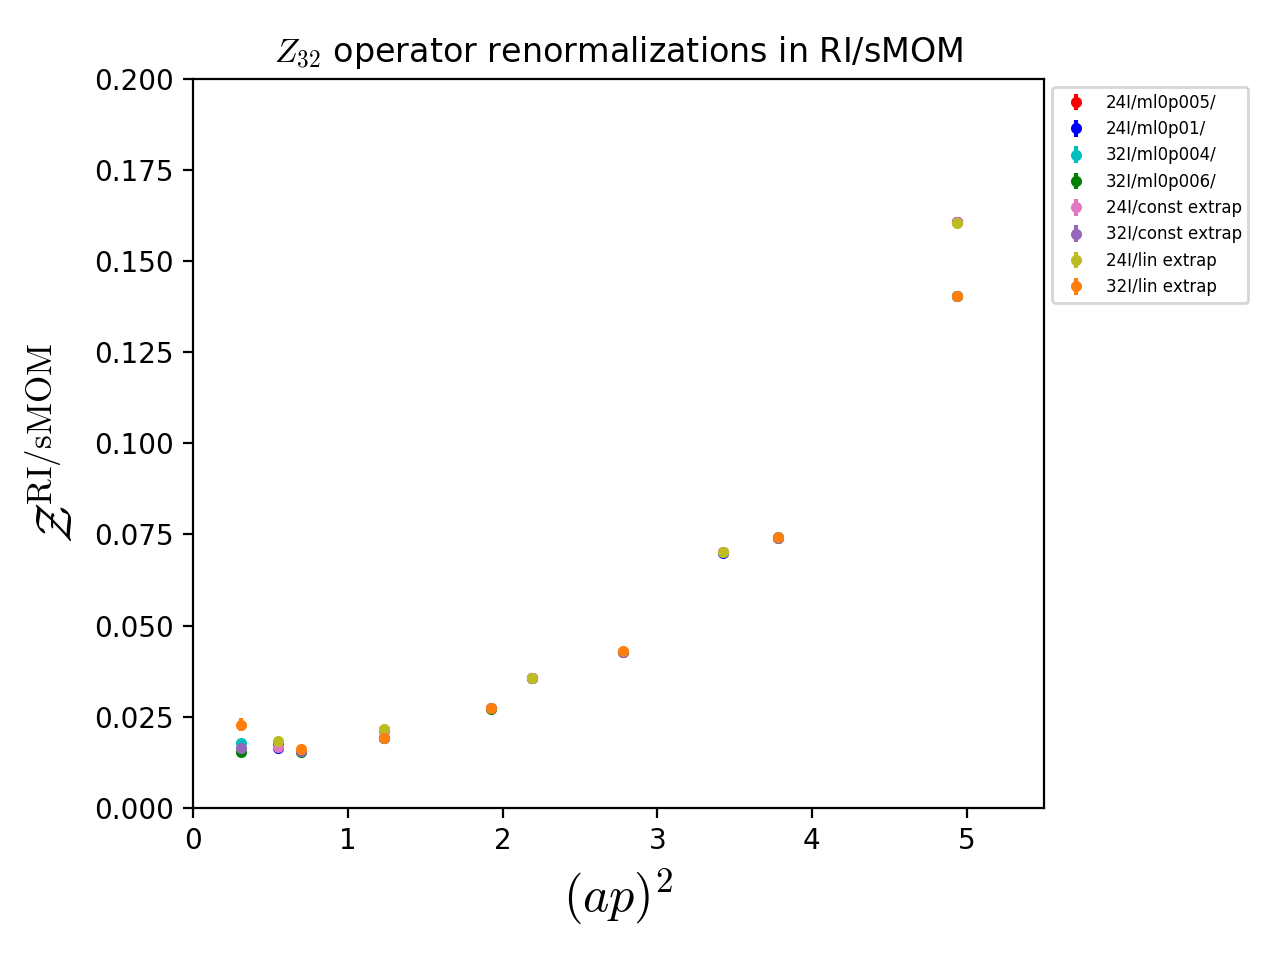

In [21]:
# Z32
Z32_mu_list = [np.mean(Z[2, 1], axis = 1) for Z in Z_list]
Z32_sigma_list = [np.std(Z[2, 1], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z32_mu_list[idx], Z32_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 2, 1], Z_extrap_sigma[0, 2, 1], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 2, 1], Z_extrap_sigma[1, 2, 1], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 2, 1], Z_extrap_lin_sigma[0, 2, 1], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 2, 1], Z_extrap_lin_sigma[1, 2, 1], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0, 0.2))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{32}$ operator renormalizations in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


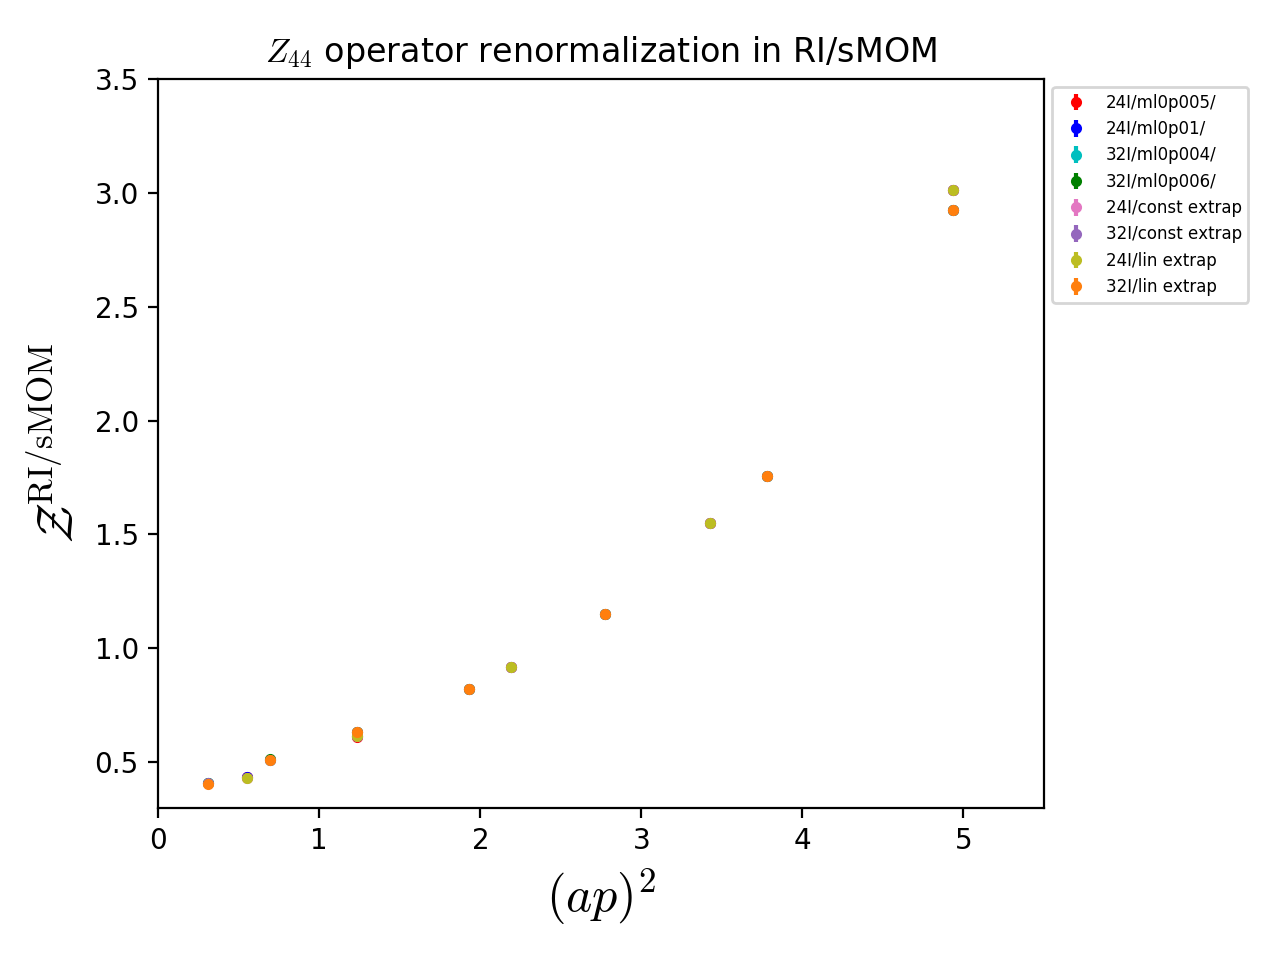

In [22]:
# Z44
Z44_mu_list = [np.mean(Z[3, 3], axis = 1) for Z in Z_list]
Z44_sigma_list = [np.std(Z[3, 3], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z44_mu_list[idx], Z44_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 3, 3], Z_extrap_sigma[0, 3, 3], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 3, 3], Z_extrap_sigma[1, 3, 3], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 3, 3], Z_extrap_lin_sigma[0, 3, 3], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 3, 3], Z_extrap_lin_sigma[1, 3, 3], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.3, 3.5))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{44}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


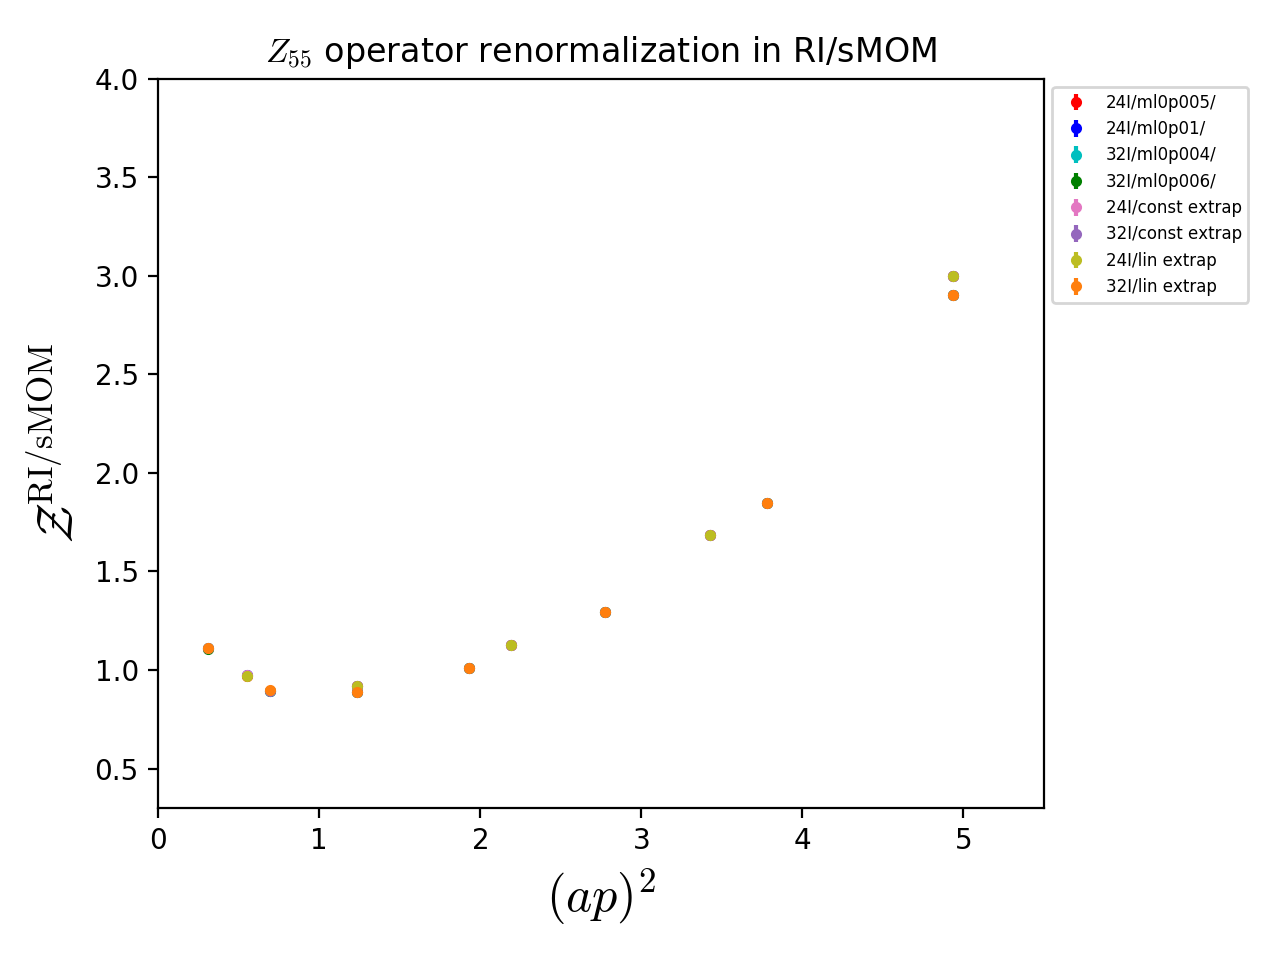

In [23]:
# Z55
Z55_mu_list = [np.mean(Z[4, 4], axis = 1) for Z in Z_list]
Z55_sigma_list = [np.std(Z[4, 4], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z55_mu_list[idx], Z55_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 4, 4], Z_extrap_sigma[0, 4, 4], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 4, 4], Z_extrap_sigma[1, 4, 4], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 4, 4], Z_extrap_lin_sigma[0, 4, 4], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 4, 4], Z_extrap_lin_sigma[1, 4, 4], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((0.3, 4.0))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{55}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


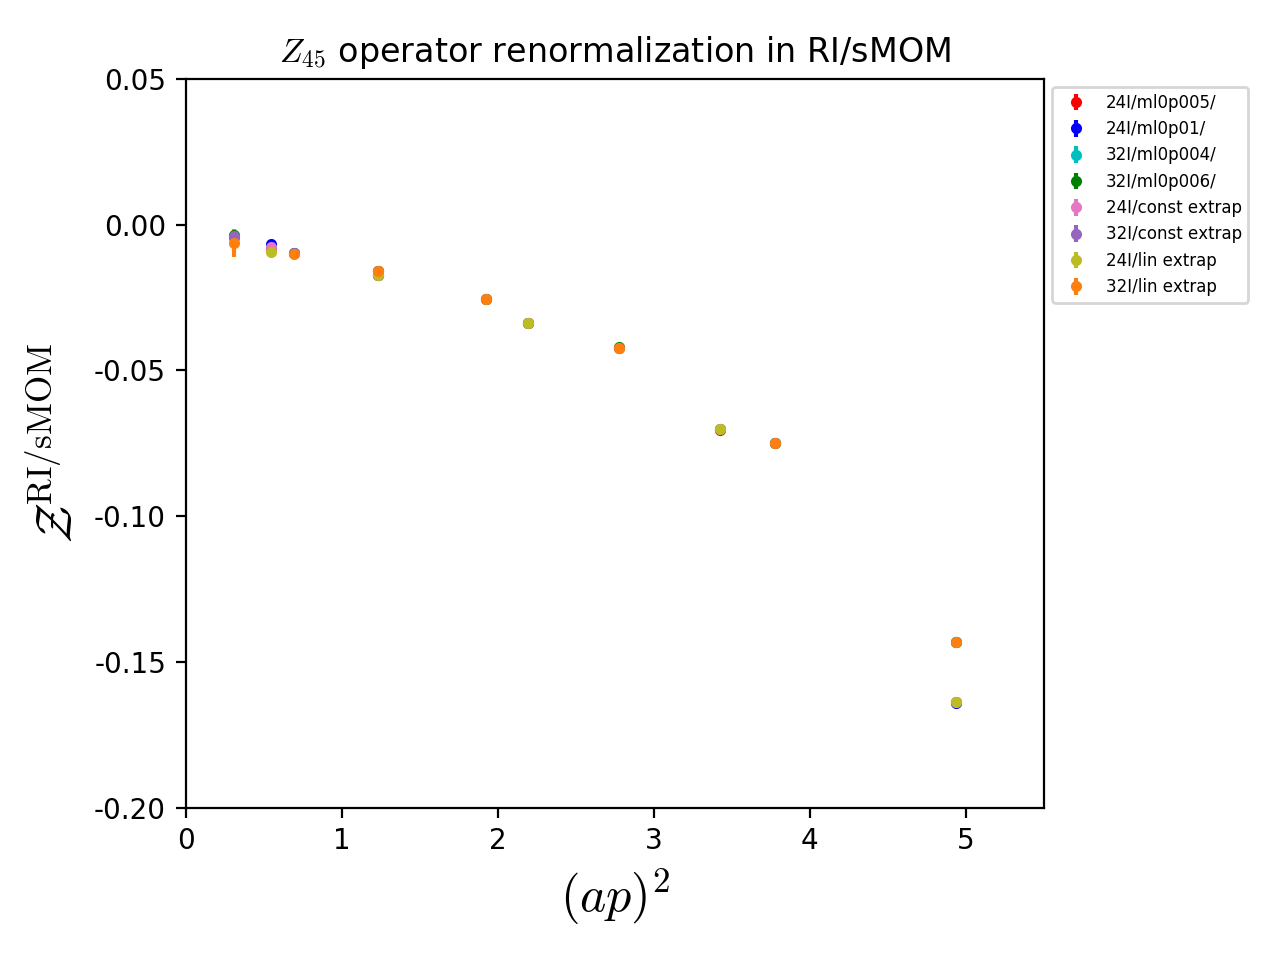

In [24]:
# Z45
Z45_mu_list = [np.mean(Z[3, 4], axis = 1) for Z in Z_list]
Z45_sigma_list = [np.std(Z[3, 4], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z45_mu_list[idx], Z45_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 3, 4], Z_extrap_sigma[0, 3, 4], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 3, 4], Z_extrap_sigma[1, 3, 4], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 3, 4], Z_extrap_lin_sigma[0, 3, 4], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 3, 4], Z_extrap_lin_sigma[1, 3, 4], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((-0.2, 0.05))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{45}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


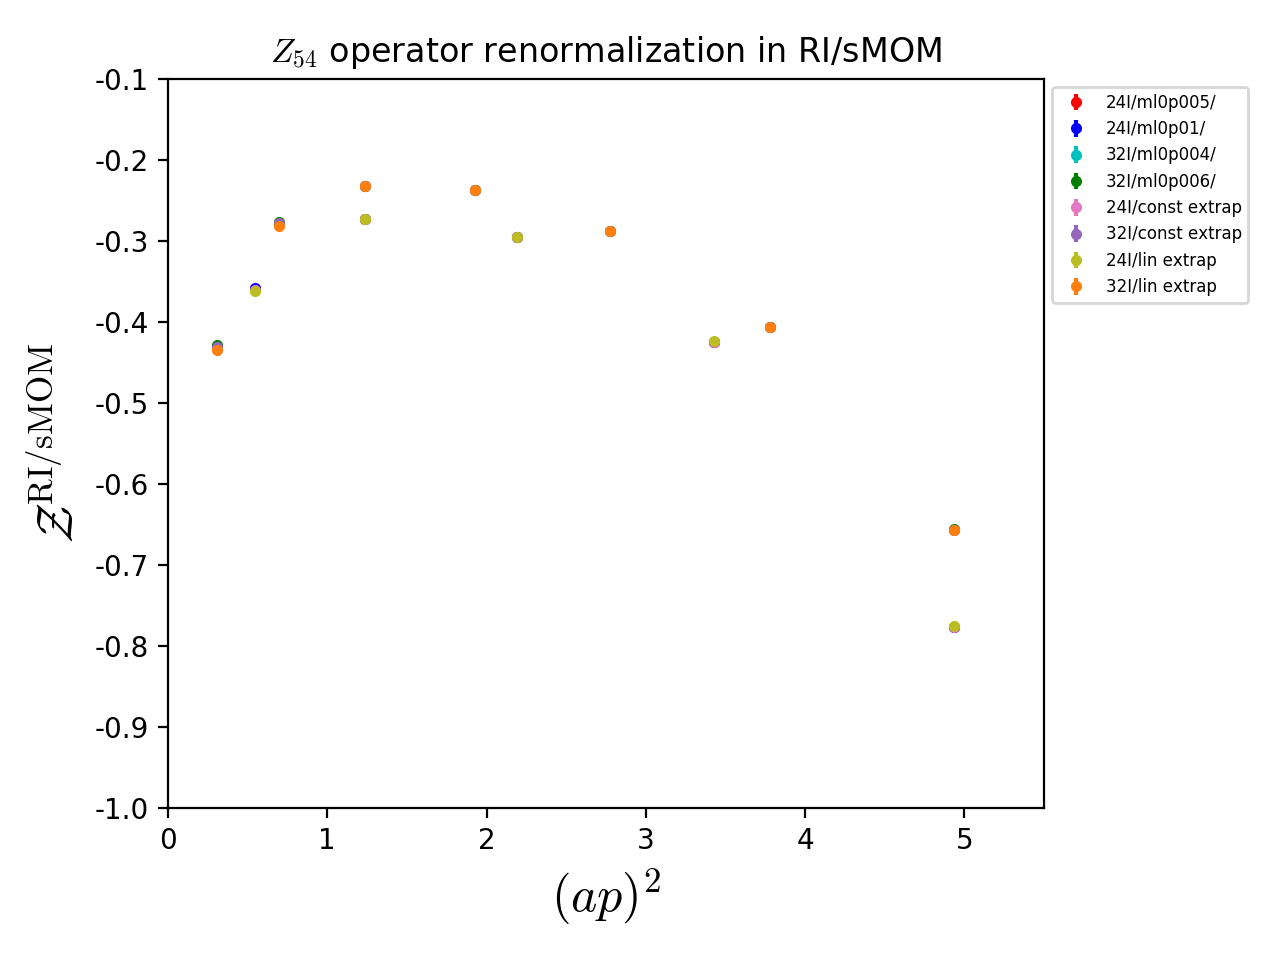

In [25]:
# Z54
Z54_mu_list = [np.mean(Z[4, 3], axis = 1) for Z in Z_list]
Z54_sigma_list = [np.std(Z[4, 3], axis = 1, ddof = 1) for Z in Z_list]
plt.figure()
for idx in range(n_ens):
    plt.errorbar([square(k) for k in mom_list[idx]], Z54_mu_list[idx], Z54_sigma_list[idx], fmt = '.', c = colors[idx], label = ensembles[idx])
plt.errorbar([square(k) + stagger for k in mom_list_24I], Z_extrap_mu[0, 4, 3], Z_extrap_sigma[0, 4, 3], fmt = '.', c = 'tab:pink', label = '24I/const extrap')
plt.errorbar([square(k) + stagger for k in mom_list_32I], Z_extrap_mu[1, 4, 3], Z_extrap_sigma[1, 4, 3], fmt = '.', c = 'tab:purple', label = '32I/const extrap')

# plot linear extrap too
plt.errorbar([square(k) - stagger for k in mom_list_24I], Z_extrap_lin_mu[0, 4, 3], Z_extrap_lin_sigma[0, 4, 3], fmt = '.', c = 'tab:olive', label = '24I/lin extrap')
plt.errorbar([square(k) - stagger for k in mom_list_32I], Z_extrap_lin_mu[1, 4, 3], Z_extrap_lin_sigma[1, 4, 3], fmt = '.', c = 'tab:orange', label = '32I/lin extrap')

plt.ylim((-1, -0.1))
plt.xlim((0, 5.5))
plt.xlabel('$(ap)^2$', fontsize = 18)
plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
plt.title('$Z_{54}$ operator renormalization in RI/sMOM')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 6})
plt.tight_layout()
plt.show()

## Fit each $Z_{ij} / Z_V^2$ as a function of $(ap)^2$, interpolate to $\mu_1 = 3$ GeV

In [26]:
spacing_idx = 0    # 0 for 24I, 1 for 32I
Z_chiral_boots = np.zeros(Z_extrap_lin[spacing_idx].shape, dtype = np.float64)     # Z_ij / ZV^2
for pidx in range(n_mom):
    for eidx in range(n_spacings):
        for bidx in range(n_boot[0]):
            Z_chiral_boots[:, :, pidx, eidx, bidx] = Z_extrap_lin[spacing_idx, :, :, pidx, eidx, bidx] / \
                (ZV_list[2 * spacing_idx + eidx][pidx, bidx] ** 2)
Z_chiral_mu = np.zeros((5, 5, n_mom), dtype = np.float64)
Z_chiral_sigma = np.zeros((5, 5, n_mom), dtype = np.float64)
for i, j in itertools.product(range(5), repeat = 2):
    for pidx in range(n_mom):
        tmp = Superboot(n_spacings)
        tmp.boots = Z_chiral_boots[i, j, pidx]
        Z_chiral_mu[i, j, pidx] = tmp.compute_mean()
        Z_chiral_sigma[i, j, pidx] = tmp.compute_std()
scales = mu_list[2 * spacing_idx]

In [27]:
# # choose lattice spacing and plot as a function of scale
# spacing_idx = 0        # 0 for 24I, 1 for 32I
# Z_chiral_boots = Z_extrap_lin[spacing_idx]
# Z_chiral_mu = Z_extrap_lin_mu[spacing_idx]
# Z_chiral_sigma = Z_extrap_lin_sigma[spacing_idx]
# scales = mu_list[2 * spacing_idx]

<IPython.core.display.Javascript object>


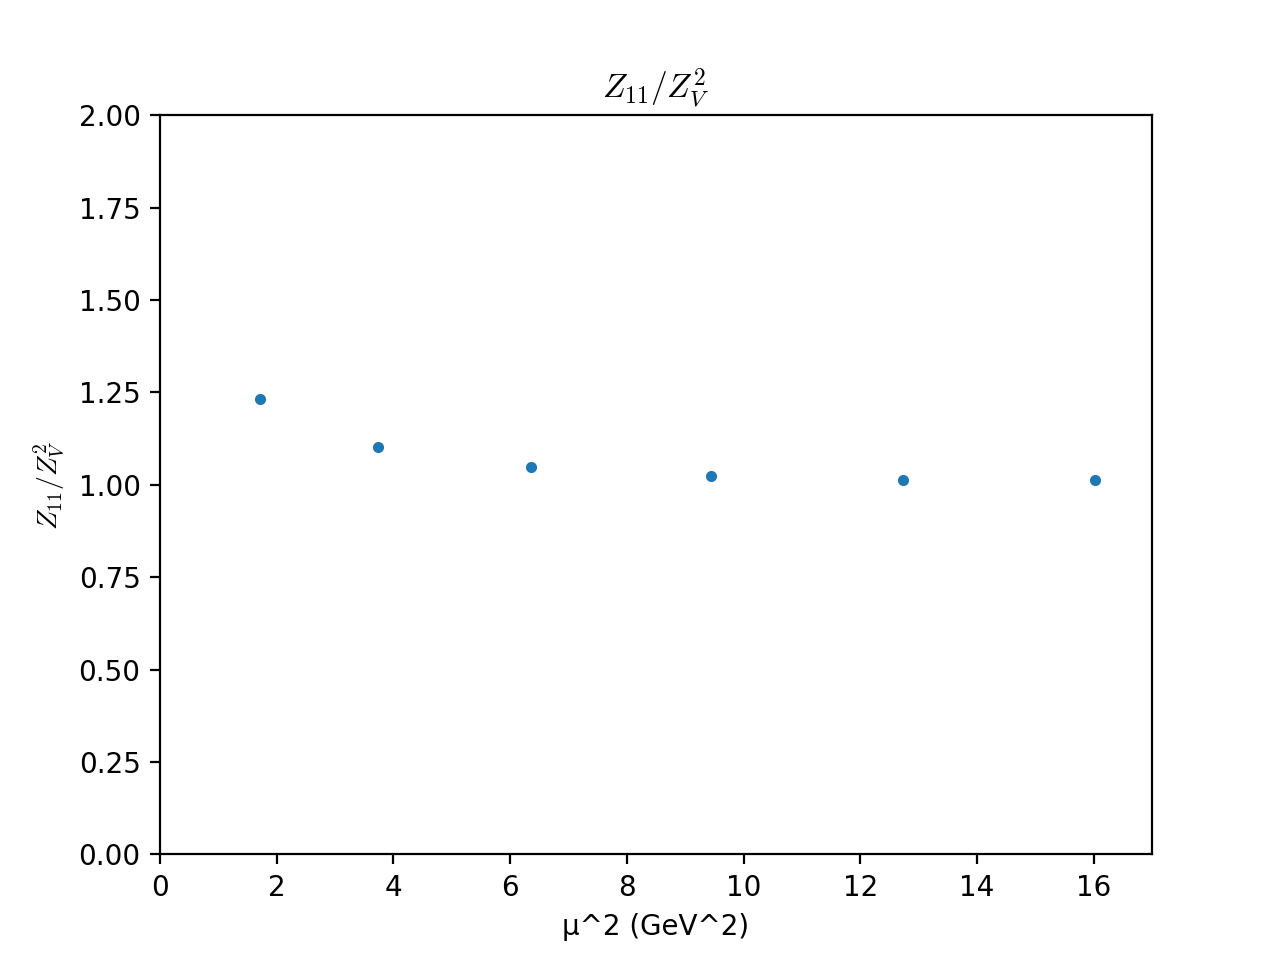

In [28]:
plt.figure()
plt.errorbar(scales ** 2, Z_chiral_mu[0, 0], Z_chiral_sigma[0, 0], marker = '.', fmt = '.')
plt.xlabel('μ^2 (GeV^2)')
plt.ylabel('$Z_{11} / Z_V^2$')
plt.xlim((0, 17))
plt.ylim((0, 2))
plt.title('$Z_{11} / Z_V^2$')
plt.show()

<IPython.core.display.Javascript object>


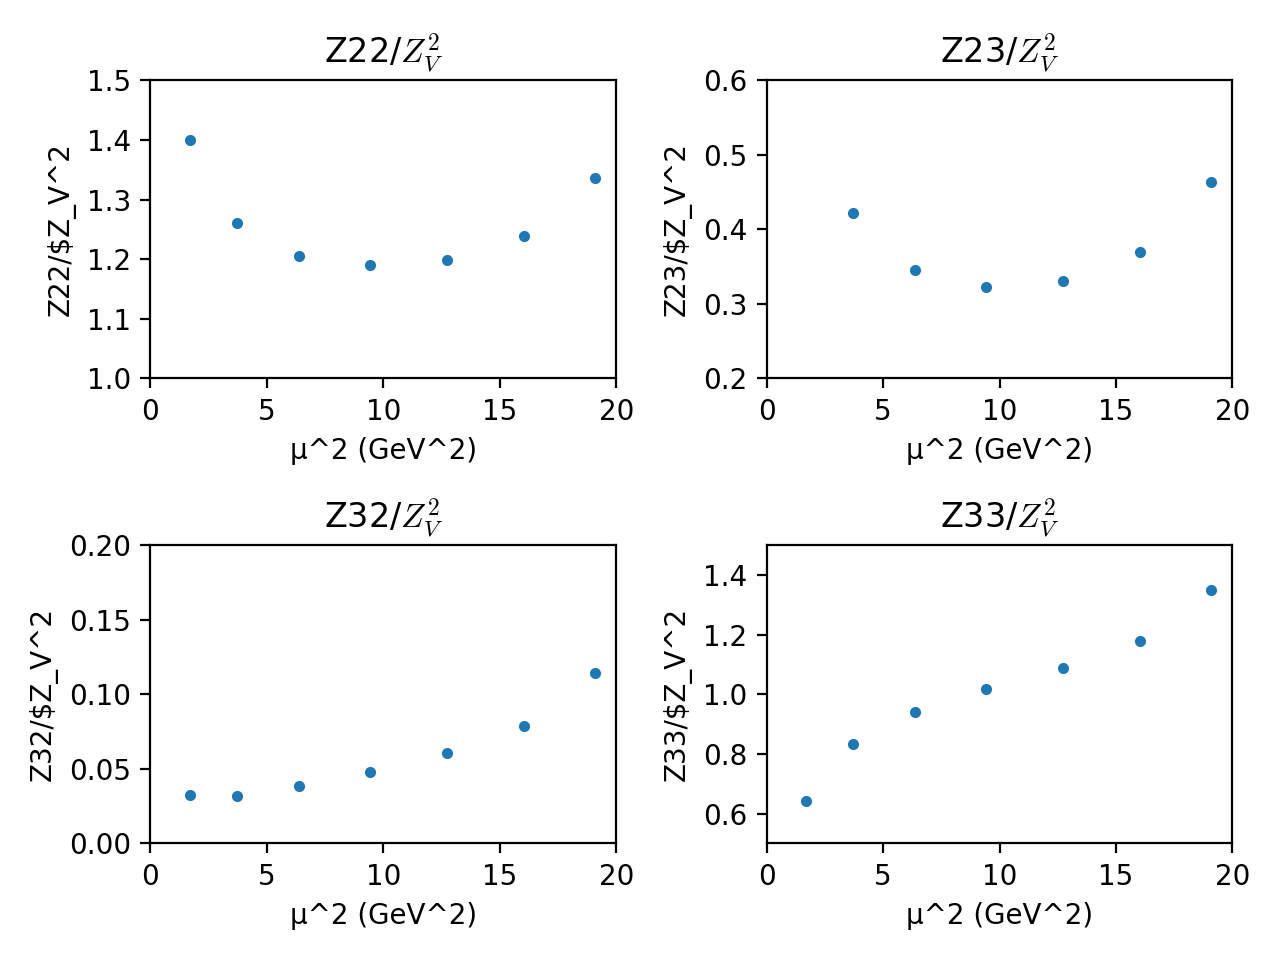

In [29]:
fig, ax = plt.subplots(2, 2)
for i, j in itertools.product(range(2), repeat = 2):
    ax[i, j].errorbar(scales ** 2, Z_chiral_mu[i + 1, j + 1], Z_chiral_sigma[i + 1, j + 1], marker = '.', fmt = '.')
    ax[i, j].set_xlim((0, 20))
    ax[i, j].set_title('Z' + str(i + 2) + str(j + 2) + '/$Z_V^2$')
    ax[i, j].set_xlabel('μ^2 (GeV^2)')
    ax[i, j].set_ylabel('Z' + str(i + 2) + str(j + 2) + '/$Z_V^2')
ax[0, 0].set_ylim((1, 1.5))
ax[0, 1].set_ylim((0.2, 0.6))
ax[1, 0].set_ylim((0, 0.2))
ax[1, 1].set_ylim((0.5, 1.5))
plt.tight_layout()
plt.show()

In [30]:
scales

array([1.30597864, 1.93098769, 2.522957  , 3.07175781, 3.568     ,
       4.00319272, 4.3698897 , 4.66181666])

/Users/theoares/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


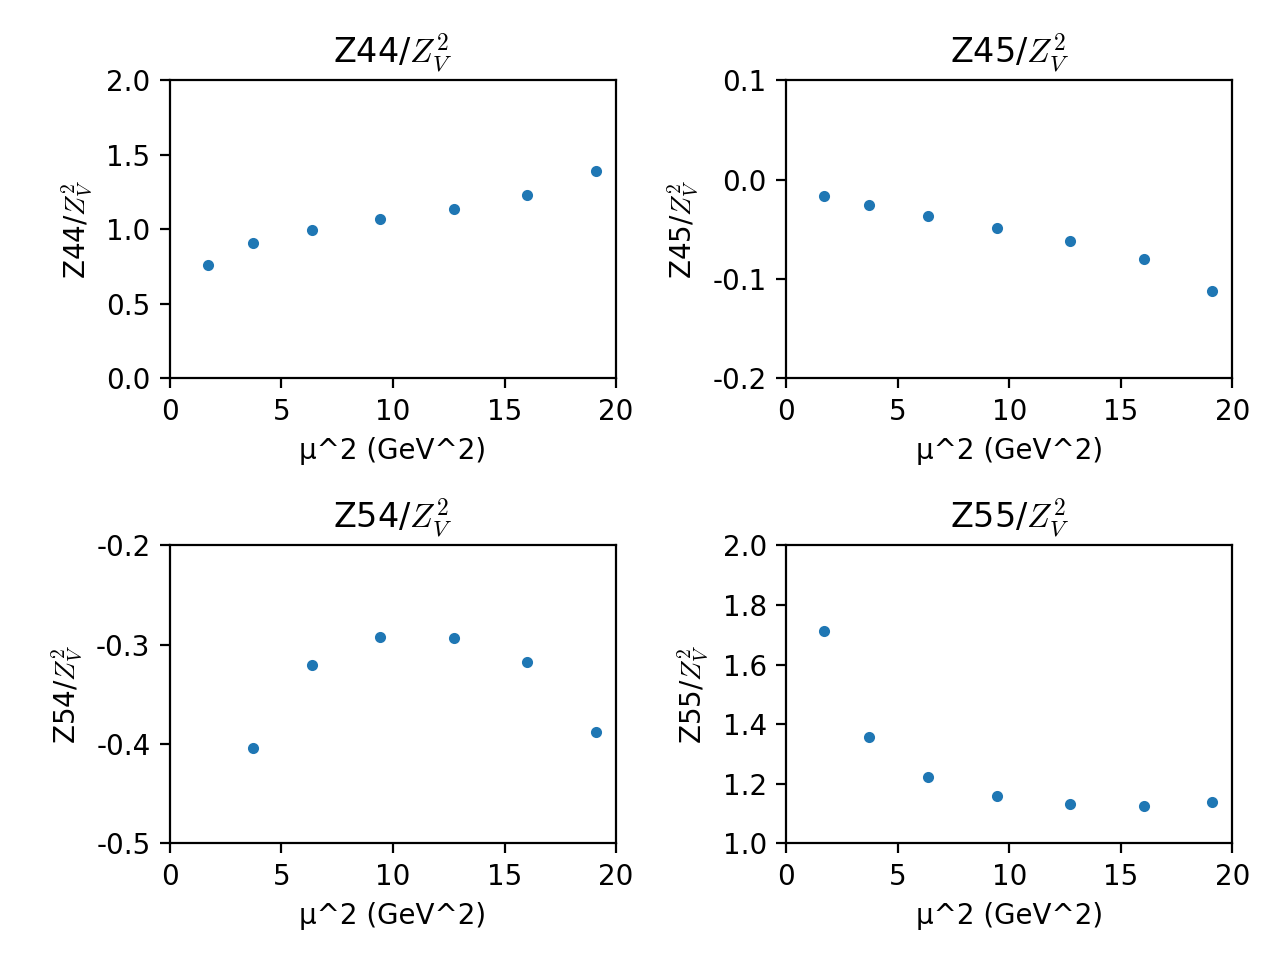

In [31]:
fig, ax = plt.subplots(2, 2)
for i, j in itertools.product(range(2), repeat = 2):
    ax[i, j].errorbar(scales ** 2, Z_chiral_mu[i + 3, j + 3], Z_chiral_sigma[i + 3, j + 3], marker = '.', fmt = '.')
    ax[i, j].set_xlim((0, 20))
    ax[i, j].set_title('Z' + str(i + 4) + str(j + 4) + '/$Z_V^2$')
    ax[i, j].set_xlabel('μ^2 (GeV^2)')
    ax[i, j].set_ylabel('Z' + str(i + 4) + str(j + 4) + '/$Z_V^2$')
ax[0, 0].set_ylim((0, 2))
ax[0, 1].set_ylim((-0.2, 0.1))
ax[1, 0].set_ylim((-0.5, -0.2))
ax[1, 1].set_ylim((1, 2))
plt.tight_layout()
plt.show()

In [32]:
scales

array([1.30597864, 1.93098769, 2.522957  , 3.07175781, 3.568     ,
       4.00319272, 4.3698897 , 4.66181666])

In [33]:
def fit_and_plot(data, mus, pwr, label, x_range = [2, 5], x_label = 'μ (GeV)'):
    fit_coeffs_b, chi2_b, y_extrap_b = corr_superboot_fit_apsq(mus, data, order = pwr)
    # x_fit_b = np.linspace(2, 5)
    x_fit_b = np.linspace(x_range[0], x_range[1])
    fx_fit_b = np.zeros(x_fit_b.shape, dtype = np.float64)
    for ii in range(pwr + 1):
        ci_mu_b = np.mean(fit_coeffs_b[ii])
        moment = x_fit_b ** (2 * ii)
        fx_fit_b += ci_mu_b * moment
    Z_fit_mean = np.zeros((len(mus)), dtype = np.float64)
    Z_fit_std = np.zeros((len(mus)), dtype = np.float64)
    for i in range(len(mus)):
        fit_data_boots = Superboot(2)
        fit_data_boots.boots = data[i]
        Z_fit_mean[i] = fit_data_boots.compute_mean()
        Z_fit_std[i] = fit_data_boots.compute_std()
    plt.figure()
    plt.errorbar(mus, Z_fit_mean, Z_fit_std, fmt = '.')
    plt.plot(x_fit_b, fx_fit_b, c = 'r')
    plt.title('Fit for ' + label)
    plt.xlabel(x_label)
    plt.ylabel(label)
    plt.show()

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[ 1.16314213e+00 -2.51416458e-02  1.24785496e-03 -1.66853477e-05]
Chi^2: 0.8066854737772647
Extrapolated Z_ij / Z_V^2 = 1.0257799517340873
[ 1.15994756e+00 -2.44311853e-02  1.20390061e-03 -1.57752223e-05]
Chi^2: 0.7335472470664243
Extrapolated Z_ij / Z_V^2 = 1.0260827047839156
[ 1.16079824e+00 -2.45453934e-02  1.21729458e-03 -1.61414912e-05]
Chi^2: 0.5516057456557236
Extrapolated Z_ij / Z_V^2 = 1.0267234123774405
[ 1.15824294e+00 -2.40387528e-02  1.17978535e-03 -1.53163429e-05]
Chi^2: 0.5052251072397597
Extrapolated Z_ij / Z_V^2 = 1.0262911646678534
[ 1.15941352e+00 -2.43387970e-02  1.20860961e-03 -1.60995027e-05]
Chi^2: 0.49752242085659953
Extrapolated Z_ij / Z_V^2 = 1.0265251889205411
[ 1.15866559e+00 -2.42167545e-02  1.19280576e-03 -1.56351843e-05]
Chi^2: 0.4972466379192983
Extrapolated Z_ij / Z_V^2 = 1.0259340118631228
[ 1.15712025e+00 -2.37867785e-02  1.16041029e-03 -1.48534320e-05]
Chi^2: 0.4742069989949383
Extrapolated Z_ij / Z_V^2 = 1

[ 1.16047192e+00 -2.44253586e-02  1.20551778e-03 -1.58843415e-05]
Chi^2: 0.5520893500460632
Extrapolated Z_ij / Z_V^2 = 1.0267109427071321
[ 1.16475905e+00 -2.50149044e-02  1.24036970e-03 -1.65224159e-05]
Chi^2: 0.6283755063281572
Extrapolated Z_ij / Z_V^2 = 1.0280500134775998
[ 1.16060085e+00 -2.45156517e-02  1.21309578e-03 -1.61116720e-05]
Chi^2: 0.5240463068537837
Extrapolated Z_ij / Z_V^2 = 1.0264753381653353
[ 1.15707177e+00 -2.41663287e-02  1.19339028e-03 -1.57675703e-05]
Chi^2: 0.47048732468133914
Extrapolated Z_ij / Z_V^2 = 1.0247448662526955
[ 1.16350984e+00 -2.53052933e-02  1.26541039e-03 -1.71613683e-05]
Chi^2: 0.7530049974062036
Extrapolated Z_ij / Z_V^2 = 1.0257498004815346
[ 1.15819447e+00 -2.42108790e-02  1.19478521e-03 -1.57880606e-05]
Chi^2: 0.47271037014351003
Extrapolated Z_ij / Z_V^2 = 1.0255646692819111
[ 1.15987049e+00 -2.47173901e-02  1.22850544e-03 -1.64552034e-05]
Chi^2: 0.7883738220961337
Extrapolated Z_ij / Z_V^2 = 1.0249270778647828
[ 1.16123013e+00 -2.48879

<IPython.core.display.Javascript object>


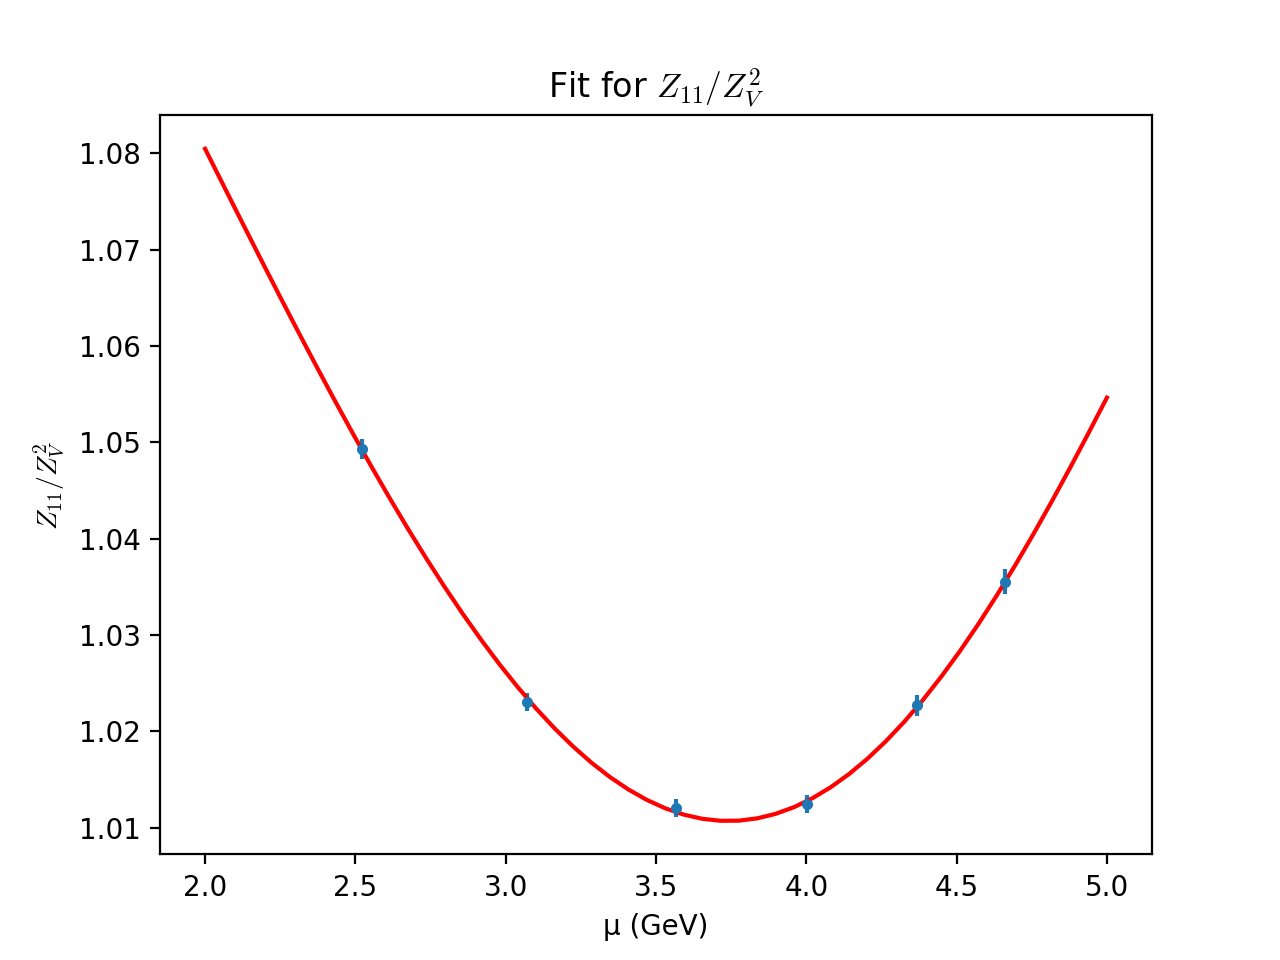

In [34]:
mom_subset = [2, 3, 4, 5, 6, 7]
pwr = 3
fit_and_plot(Z_chiral_boots[0, 0, mom_subset], scales[mom_subset], pwr, '$Z_{11} / Z_V^2$')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
[ 1.32260545 -0.02684759  0.00134859]
Chi^2: 0.11191387904612606
Extrapolated Z_ij / Z_V^2 = 1.1902130748905417
[ 1.32121135 -0.02665728  0.0013418 ]
Chi^2: 0.11191921331336005
Extrapolated Z_ij / Z_V^2 = 1.1899815891716727
[ 1.31945018 -0.02645754  0.00133566]
Chi^2: 0.29407604689909056
Extrapolated Z_ij / Z_V^2 = 1.1895209515334584
[ 1.32091822 -0.02659268  0.00133957]
Chi^2: 0.34667420808045935
Extrapolated Z_ij / Z_V^2 = 1.190089089000704
[ 1.32054664 -0.02654622  0.00133914]
Chi^2: 0.2694972888340345
Extrapolated Z_ij / Z_V^2 = 1.1901011084236135
[ 1.32211621 -0.02675084  0.00134636]
Chi^2: 0.2278483507281604
Extrapolated Z_ij / Z_V^2 = 1.1904140754416883
[ 1.32089618 -0.02655016  0.00133764]
Chi^2: 0.4792725515944799
Extrapolated Z_ij / Z_V^2 = 1.1902932014889056
[ 1.32087677 -0.02658484  0.00134015]
Chi^2: 0.26898790741667944
Extrapolated Z_ij / Z_V^2 = 1.1901655952000043
[ 1.32008322 -0.02649412  0.00133616]
Chi^2: 0.5846762920106728
Extrapolate

[ 1.32190591 -0.02673582  0.00134591]
Chi^2: 0.2326031202922212
Extrapolated Z_ij / Z_V^2 = 1.1903022758611486
[ 1.32091002 -0.0265764   0.00133955]
Chi^2: 0.2658725116298082
Extrapolated Z_ij / Z_V^2 = 1.190225879166403
[ 1.32365024 -0.02699764  0.00135576]
Chi^2: 0.10629329457827351
Extrapolated Z_ij / Z_V^2 = 1.1904880950082535
[ 1.32373912 -0.02693657  0.00135482]
Chi^2: 0.13977166263772667
Extrapolated Z_ij / Z_V^2 = 1.1910501223582657
[ 1.32044068 -0.02681094  0.00134909]
Chi^2: 0.03571587395340746
Extrapolated Z_ij / Z_V^2 = 1.1884187850525174
[ 1.32264042 -0.02672597  0.0013449 ]
Chi^2: 0.26508563535206725
Extrapolated Z_ij / Z_V^2 = 1.1910438528554952
[ 1.32259109 -0.02683599  0.00134822]
Chi^2: 0.25191094357870364
Extrapolated Z_ij / Z_V^2 = 1.1902730913610724


<IPython.core.display.Javascript object>


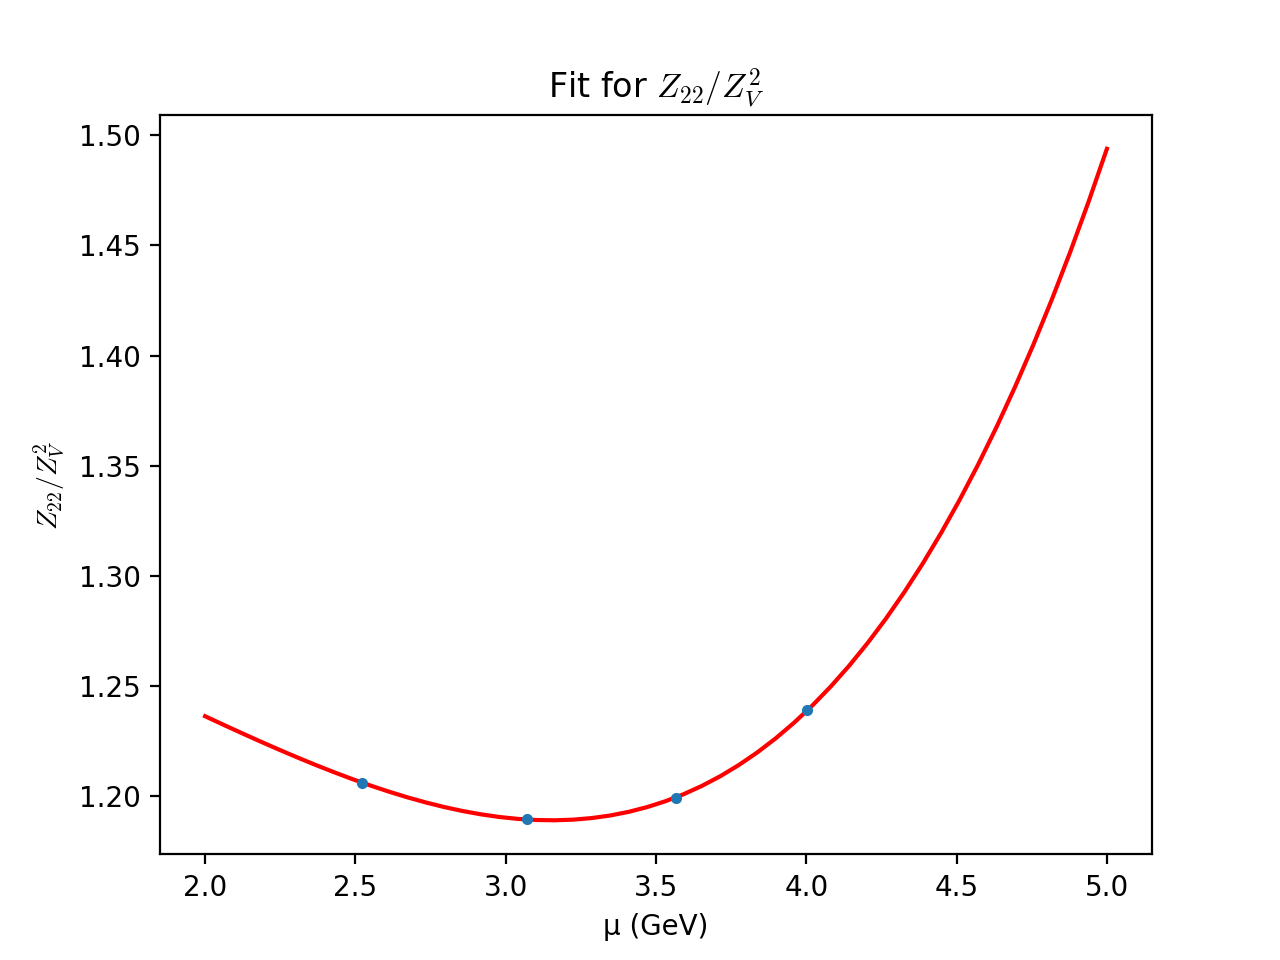

In [35]:
mom_subset = [2, 3, 4, 5]
pwr = 2
fit_and_plot(Z_chiral_boots[1, 1, mom_subset], scales[mom_subset], pwr, '$Z_{22} / Z_V^2$')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
+ c4 \mu^8
[ 6.48728889e-01  6.20118805e-02 -2.41002734e-03 -5.75623524e-05
  5.98638752e-06]
Chi^2: 7.684319730185392
Extrapolated Z_ij / Z_V^2 = 1.008937332137272
[ 6.44745349e-01  6.25603237e-02 -2.39190789e-03 -6.21683070e-05
  6.12725339e-06]
Chi^2: 6.4142096251557135
Extrapolated Z_ij / Z_V^2 = 1.0089239372040506
[ 6.53648396e-01  6.09283119e-02 -2.37524965e-03 -5.44039424e-05
  5.84254807e-06]
Chi^2: 8.99831229210546
Extrapolated Z_ij / Z_V^2 = 1.0082804658489235
[ 6.43160988e-01  6.27042002e-02 -2.38132260e-03 -6.37838224e-05
  6.17525205e-06]
Chi^2: 6.347472117478608
Extrapolated Z_ij / Z_V^2 = 1.0086290807266038
[ 6.45152782e-01  6.22380295e-02 -2.34927804e-03 -6.38310503e-05
  6.14433679e-06]
Chi^2: 6.113192584043828
Extrapolated Z_ij / Z_V^2 = 1.0087836840373536
[ 6.42621276e-01  6.28398716e-02 -2.38646672e-03 -6.41104744e-05
  6.19196854e-06]
Chi^2: 5.540142029598121
Extrapolated Z_ij / Z_V^2 = 1.0087652861557688
[ 6.42299589e-01

  6.05219977e-06]
Chi^2: 6.48536351851535
Extrapolated Z_ij / Z_V^2 = 1.008209364110643
[ 6.49726295e-01  6.20060752e-02 -2.41930130e-03 -5.67878534e-05
  5.96920441e-06]
Chi^2: 7.235764510843913
Extrapolated Z_ij / Z_V^2 = 1.0095831718163448
[ 6.46681884e-01  6.22971314e-02 -2.39769686e-03 -6.00980952e-05
  6.06210240e-06]
Chi^2: 6.584867561389042
Extrapolated Z_ij / Z_V^2 = 1.0091045629477173
[ 6.46341014e-01  6.22758966e-02 -2.39563895e-03 -6.02063535e-05
  6.06281890e-06]
Chi^2: 6.530420799043912
Extrapolated Z_ij / Z_V^2 = 1.0086650514786002
[ 6.48030387e-01  6.20015058e-02 -2.39909617e-03 -5.85595104e-05
  6.00651114e-06]
Chi^2: 7.197374984718993
Extrapolated Z_ij / Z_V^2 = 1.008435985211437
[ 6.49213472e-01  6.21021305e-02 -2.41733522e-03 -5.74645316e-05
  5.99026179e-06]
Chi^2: 6.753810979078409
Extrapolated Z_ij / Z_V^2 = 1.0097389576776612
[ 6.44182042e-01  6.24456258e-02 -2.37462939e-03 -6.29533541e-05
  6.13736473e-06]
Chi^2: 5.74609425202771
Extrapolated Z_ij / Z_V^2 = 1.0

<IPython.core.display.Javascript object>


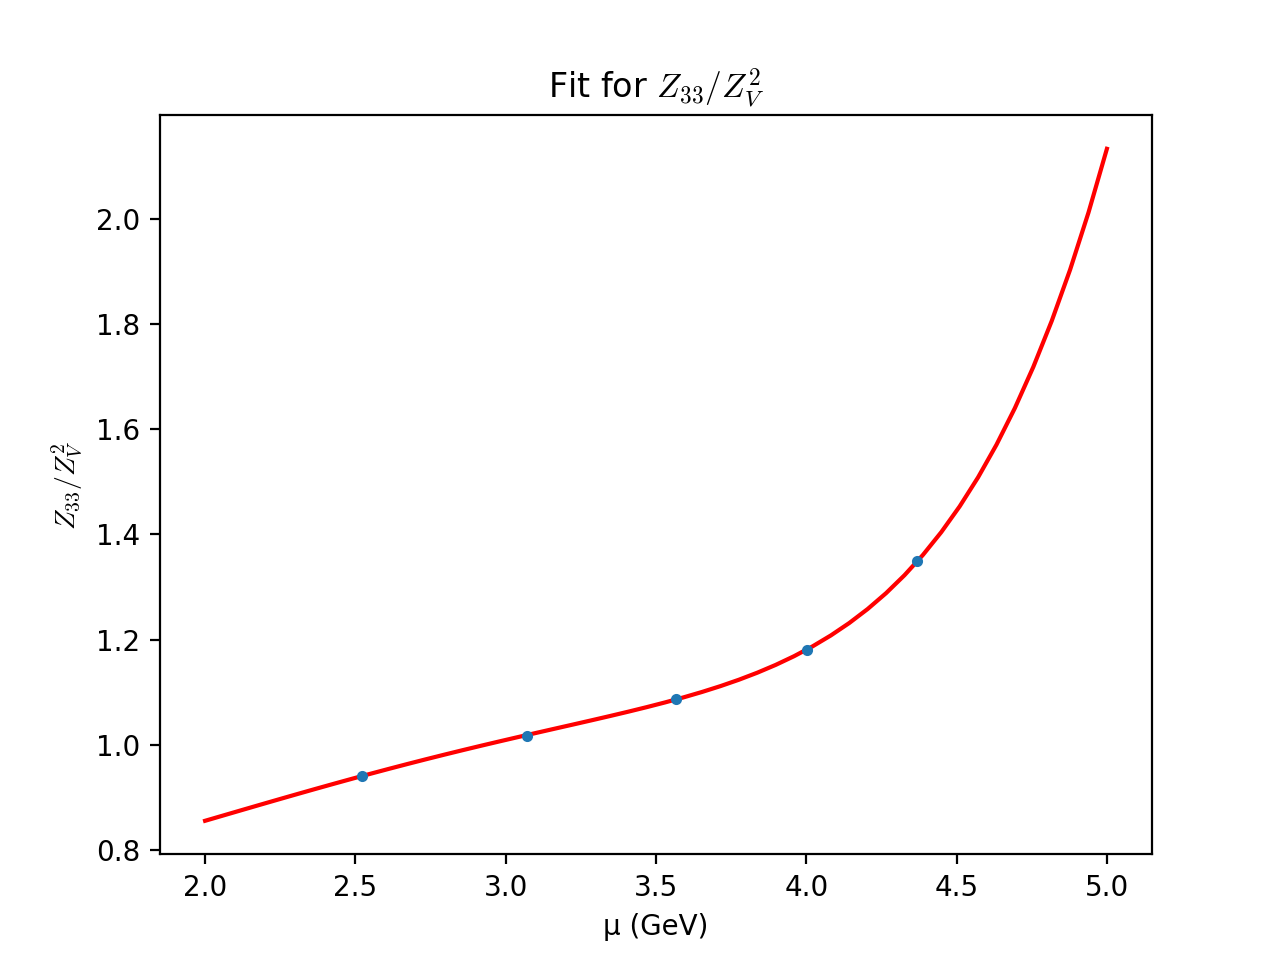

In [36]:
mom_subset = [2, 3, 4, 5, 6]
pwr = 4
fit_and_plot(Z_chiral_boots[2, 2, mom_subset], scales[mom_subset], pwr, '$Z_{33} / Z_V^2$')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[ 6.52110296e-01  8.71386952e-02 -6.52560432e-03  2.08782409e-04]
Chi^2: 18.447444700972905
Extrapolated Z_ij / Z_V^2 = 1.0599869781445637
[ 6.47758560e-01  8.81235639e-02 -6.59871285e-03  2.10438979e-04]
Chi^2: 17.47225428626076
Extrapolated Z_ij / Z_V^2 = 1.0597849101042185
[ 6.60552207e-01  8.48373146e-02 -6.34639711e-03  2.04311718e-04]
Chi^2: 20.542035753921354
Extrapolated Z_ij / Z_V^2 = 1.0589731155787188
[ 6.47357900e-01  8.81429681e-02 -6.59951749e-03  2.10476410e-04]
Chi^2: 17.813067033101657
Extrapolated Z_ij / Z_V^2 = 1.0595209991096648
[ 6.47428509e-01  8.79991646e-02 -6.57834887e-03  2.09770933e-04]
Chi^2: 16.381088864445235
Extrapolated Z_ij / Z_V^2 = 1.0594977416555467
[ 6.45755899e-01  8.85733997e-02 -6.63278028e-03  2.11315342e-04]
Chi^2: 16.306455843515018
Extrapolated Z_ij / Z_V^2 = 1.0597101778236286
[ 6.45909449e-01  8.84263239e-02 -6.62073203e-03  2.10989560e-04]
Chi^2: 16.315979749080498
Extrapolated Z_ij / Z_V^2 = 1.0

[ 6.49620591e-01  8.76600660e-02 -6.56033682e-03  2.09501702e-04]
Chi^2: 16.858850473669104
Extrapolated Z_ij / Z_V^2 = 1.0599006432062656
[ 6.53268196e-01  8.71588667e-02 -6.53028578e-03  2.08966883e-04]
Chi^2: 17.198473185057598
Extrapolated Z_ij / Z_V^2 = 1.0610817053283153
[ 6.49953404e-01  8.75408202e-02 -6.55242648e-03  2.09300643e-04]
Chi^2: 17.278562013384054
Extrapolated Z_ij / Z_V^2 = 1.0596544099851586
[ 6.48447569e-01  8.74906085e-02 -6.54062620e-03  2.08793746e-04]
Chi^2: 16.964941843298643
Extrapolated Z_ij / Z_V^2 = 1.0582829634885964
[ 6.54105562e-01  8.65651068e-02 -6.48221980e-03  2.07673950e-04]
Chi^2: 17.6760188256178
Extrapolated Z_ij / Z_V^2 = 1.0595260297183582
[ 6.49183203e-01  8.75294787e-02 -6.54900581e-03  2.09095212e-04]
Chi^2: 17.559201044359668
Extrapolated Z_ij / Z_V^2 = 1.058909449082839
[ 6.51580691e-01  8.69313404e-02 -6.50574482e-03  2.08087247e-04]
Chi^2: 18.274269926625596
Extrapolated Z_ij / Z_V^2 = 1.0586930280285674
[ 6.50577455e-01  8.72763317e-

<IPython.core.display.Javascript object>


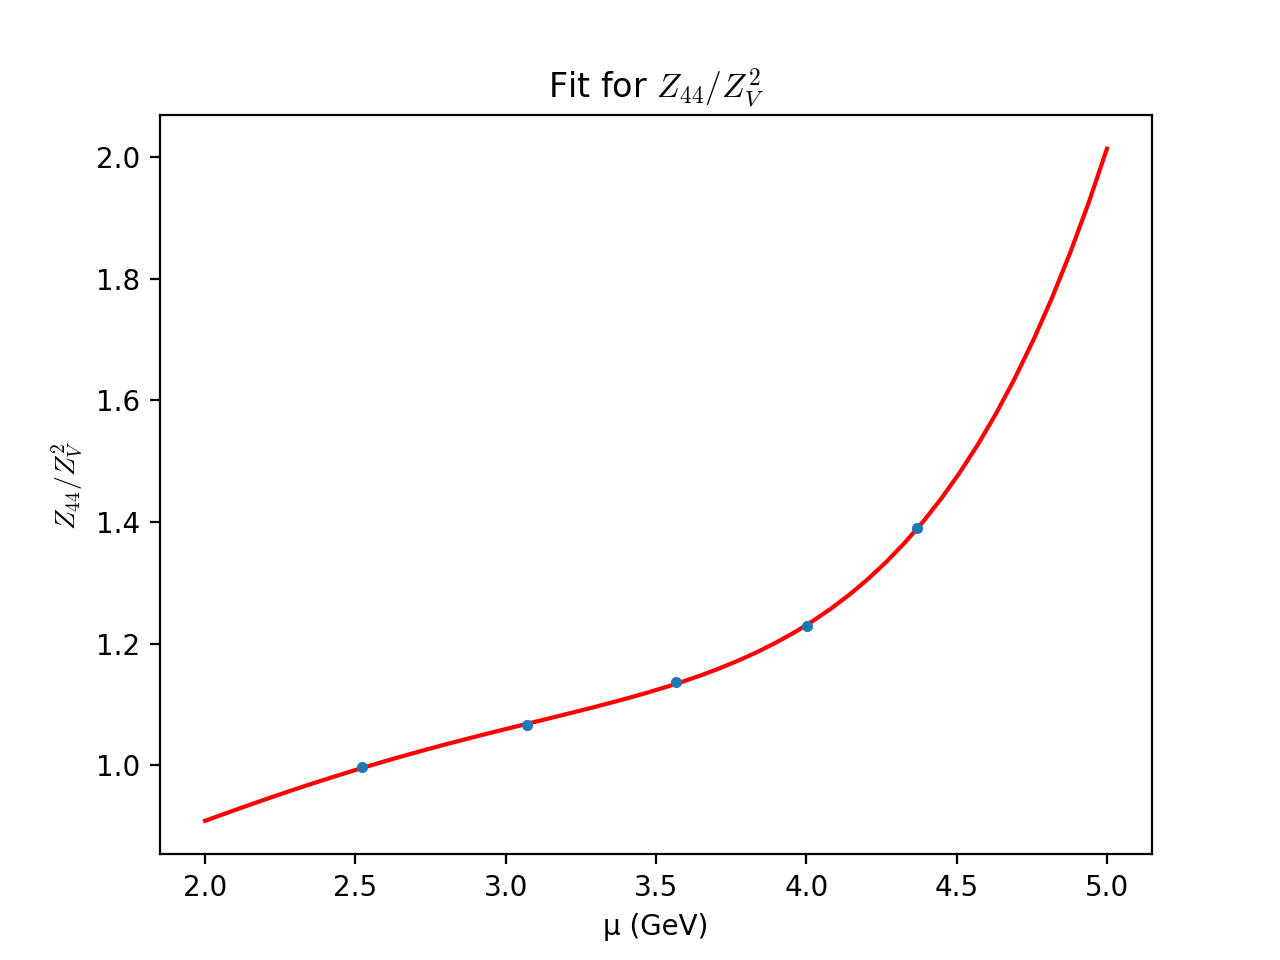

In [37]:
mom_subset = [2, 3, 4, 5, 6]
pwr = 3
fit_and_plot(Z_chiral_boots[3, 3, mom_subset], scales[mom_subset], pwr, '$Z_{44} / Z_V^2$')

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[ 1.37339316e+00 -2.81009713e-02  4.81051121e-04  1.83597348e-05]
Chi^2: 88.30237653033949
Extrapolated Z_ij / Z_V^2 = 1.1728338088076087
[ 1.37234209e+00 -2.79693350e-02  4.79510340e-04  1.82686571e-05]
Chi^2: 86.62983911689761
Extrapolated Z_ij / Z_V^2 = 1.1727762649677411
[ 1.37053334e+00 -2.77230691e-02  4.75476128e-04  1.81096890e-05]
Chi^2: 83.11195610517215
Extrapolated Z_ij / Z_V^2 = 1.1727412489361217
[ 1.37350718e+00 -2.80626728e-02  4.80576967e-04  1.83351635e-05]
Chi^2: 86.86960664541238
Extrapolated Z_ij / Z_V^2 = 1.173236195323917
[ 1.37266792e+00 -2.79534538e-02  4.79339450e-04  1.82528428e-05]
Chi^2: 87.94306008421647
Extrapolated Z_ij / Z_V^2 = 1.1732196494934122
[ 1.37336508e+00 -2.80307289e-02  4.79523012e-04  1.83208365e-05]
Chi^2: 86.72583642895177
Extrapolated Z_ij / Z_V^2 = 1.173285775540217
[ 1.37405494e+00 -2.81225811e-02  4.81705431e-04  1.83774282e-05]
Chi^2: 84.53985473695214
Extrapolated Z_ij / Z_V^2 = 1.173366994

[ 1.37279338e+00 -2.80522552e-02  4.79866147e-04  1.83256799e-05]
Chi^2: 90.95139862312523
Extrapolated Z_ij / Z_V^2 = 1.1725516608175115
[ 1.37443700e+00 -2.81991509e-02  4.85060585e-04  1.83860863e-05]
Chi^2: 92.41262208879019
Extrapolated Z_ij / Z_V^2 = 1.1733380059301917
[ 1.37381335e+00 -2.80355044e-02  4.78952286e-04  1.83269513e-05]
Chi^2: 90.01325201764374
Extrapolated Z_ij / Z_V^2 = 1.173649291994875
[ 1.37260336e+00 -2.80044339e-02  4.79771079e-04  1.82886597e-05]
Chi^2: 89.58986044860046
Extrapolated Z_ij / Z_V^2 = 1.1727573496578403
[ 1.37063849e+00 -2.78900764e-02  4.79794667e-04  1.81939870e-05]
Chi^2: 85.94458297359274
Extrapolated Z_ij / Z_V^2 = 1.1717545918112449
[ 1.37487794e+00 -2.82325007e-02  4.86525805e-04  1.83964691e-05]
Chi^2: 92.13620419152487
Extrapolated Z_ij / Z_V^2 = 1.1736050511780811
[ 1.37159915e+00 -2.79243188e-02  4.78758973e-04  1.82343782e-05]
Chi^2: 87.44655478251532
Extrapolated Z_ij / Z_V^2 = 1.1723526223284204
[ 1.37290354e+00 -2.80381541e-02  4

<IPython.core.display.Javascript object>


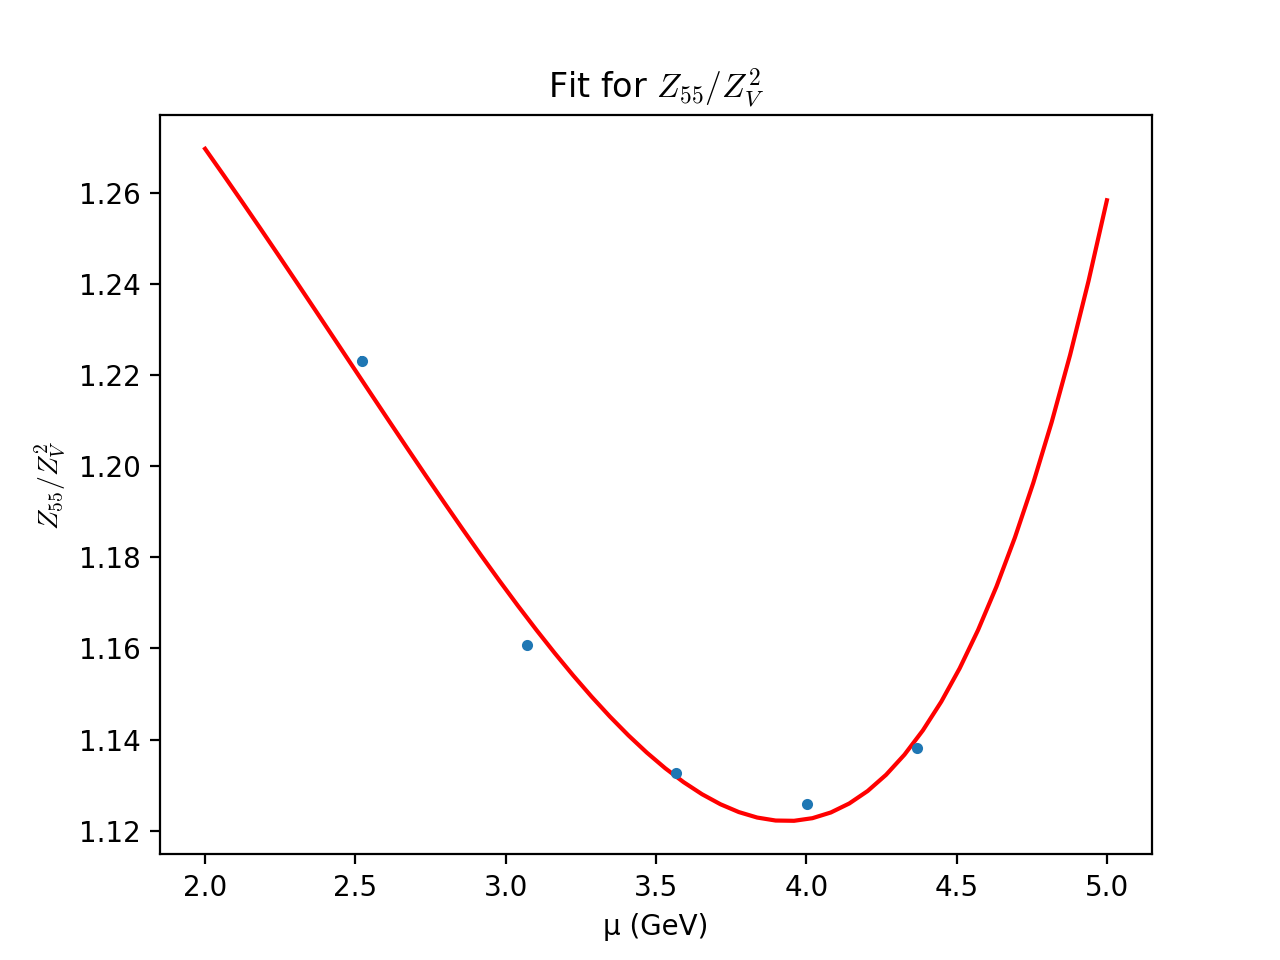

In [38]:
mom_subset = [2, 3, 4, 5, 6]
pwr = 3
# fit_and_plot(Z_chiral_boots[4, 4, mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, '$Z_{55} / Z_V^2$', x_range = [1, 15], x_label = '$(ap)^2$')
fit_and_plot(Z_chiral_boots[4, 4, mom_subset], scales[mom_subset], pwr, '$Z_{55} / Z_V^2$')

Anomalous dimension of ZV vanishes because it's scale independent-- same for ZA. This is why it doesn't matter when we divide out by ZV, since it's scale independent so only Z_ij can be run. Check out Aoki paper for a bit more about ZV and ZA, also 1908.10116, 1411.7017, and 1710.08678. Also check Gracey

Big question: why does no one compute ZV non-perturbatively? It's always computed with PCAC or something else, never in the same way that Zq or Zij are computed. What am I missing? And when / why would we expect ZV = 1, is that only for the fully conserved 5d domain wall vector / axial current?
For these questions, check 1004.1115-- it mentions that \textbf{for scale-independent RCs, i.e. ZV, ZA, and ZP / ZS, other methods than RI/MOM must be used}. Not sure why yet, but it seems promising

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[8.22853518e-01 3.25920305e-02 2.43219146e-06 5.89774092e-07]
Chi^2: 114.67058125887742
Extrapolated Z_ij / Z_V^2 = 1.116808745194982
[8.22188283e-01 3.26283704e-02 1.88790441e-06 5.93910187e-07]
Chi^2: 113.56110894081077
Extrapolated Z_ij / Z_V^2 = 1.1164294980170177
[8.22105314e-01 3.26507312e-02 1.92225780e-06 5.94467491e-07]
Chi^2: 113.37889734210455
Extrapolated Z_ij / Z_V^2 = 1.1165509645289615
[8.22116000e-01 3.26367676e-02 1.86341602e-06 5.93909391e-07]
Chi^2: 116.70967342756624
Extrapolated Z_ij / Z_V^2 = 1.1164308049344973
[8.21750098e-01 3.26530292e-02 1.60779794e-06 5.96206812e-07]
Chi^2: 118.59451082831154
Extrapolated Z_ij / Z_V^2 = 1.1161922271432534
[8.21726334e-01 3.26541433e-02 1.39477245e-06 5.95453974e-07]
Chi^2: 121.0403558481472
Extrapolated Z_ij / Z_V^2 = 1.1161606857607091
[8.22299727e-01 3.26462406e-02 1.68261637e-06 5.94602806e-07]
Chi^2: 118.67200763158229
Extrapolated Z_ij / Z_V^2 = 1.1166856496237731
[8.22266189e-

[8.21793436e-01 3.26511486e-02 1.56322212e-06 5.95248869e-07]
Chi^2: 117.03596802480627
Extrapolated Z_ij / Z_V^2 = 1.1162143300267036
[8.21582937e-01 3.26591206e-02 1.42589590e-06 5.96297194e-07]
Chi^2: 119.73236786058361
Extrapolated Z_ij / Z_V^2 = 1.1160652210039306
[8.21688817e-01 3.26570418e-02 1.57981216e-06 5.95671152e-07]
Chi^2: 116.12301394215984
Extrapolated Z_ij / Z_V^2 = 1.1161644024889876
[8.21929259e-01 3.26467630e-02 1.64886868e-06 5.94673007e-07]
Chi^2: 114.41682892724485
Extrapolated Z_ij / Z_V^2 = 1.1163172003273212
[8.21941856e-01 3.26515261e-02 1.53467440e-06 5.95372818e-07]
Chi^2: 116.65623917293966
Extrapolated Z_ij / Z_V^2 = 1.116363926591425
[8.22037768e-01 3.26388144e-02 1.76062261e-06 5.93944606e-07]
Chi^2: 116.35566461556711
Extrapolated Z_ij / Z_V^2 = 1.1163626936988558
[8.21965982e-01 3.26396065e-02 1.78512075e-06 5.94162423e-07]
Chi^2: 113.30041351447116
Extrapolated Z_ij / Z_V^2 = 1.1163001792910539
[8.22127014e-01 3.26314050e-02 1.95188642e-06 5.92856366

<IPython.core.display.Javascript object>


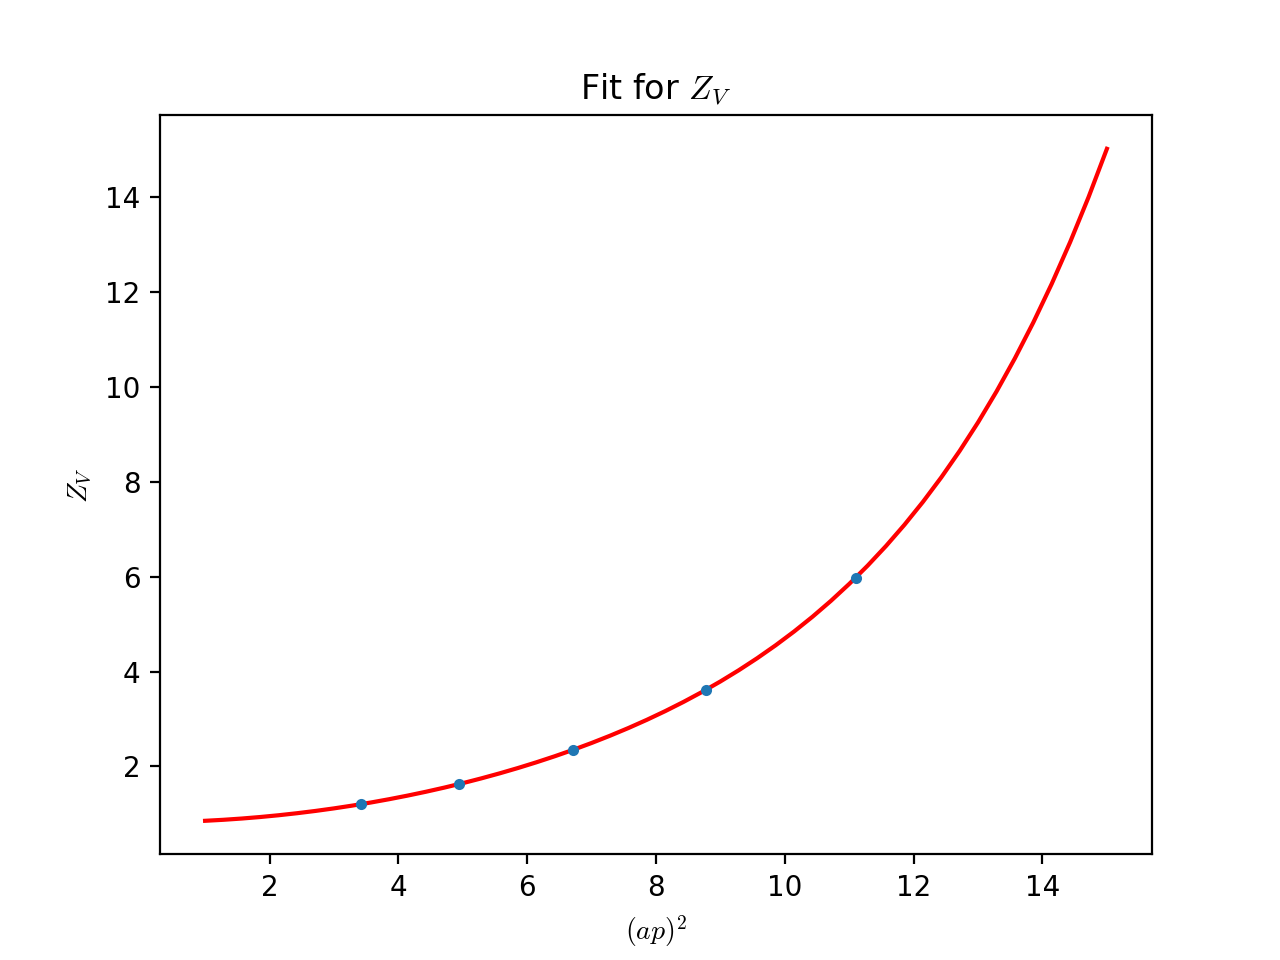

In [39]:
# mom_subset = [0, 1, 2, 3, 4]
mom_subset = [3, 4, 5, 6, 7]
pwr = 3
fit_and_plot(ZV_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, '$Z_V$', x_range = [1, 15], x_label = '$(ap)^2$')    # index ZV_extrap at 1 for 32I
# fit_and_plot(ZV_extrap[0][mom_subset], scales[mom_subset], pwr, '$Z_V$', x_range = [1, 5])    # index ZV_extrap at 1 for 32I

In [40]:
1.13/1.3

0.8692307692307691

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
[1.06484669e+00 2.47619131e-02 2.63995814e-04]
Chi^2: 5496.943570251061
Extrapolated Z_ij / Z_V^2 = 1.3090875717560717
[1.06332585e+00 2.47558401e-02 2.63803297e-04]
Chi^2: 5498.305505315306
Extrapolated Z_ij / Z_V^2 = 1.3074964766512172
[1.06184865e+00 2.47585308e-02 2.63707094e-04]
Chi^2: 5504.300532320629
Extrapolated Z_ij / Z_V^2 = 1.3060357005861667
[1.06318221e+00 2.47460505e-02 2.63817701e-04]
Chi^2: 5498.852186593431
Extrapolated Z_ij / Z_V^2 = 1.3072658975095799
[1.06262036e+00 2.47376438e-02 2.63719744e-04]
Chi^2: 5490.367337021774
Extrapolated Z_ij / Z_V^2 = 1.3066204520316083
[1.06425723e+00 2.47398427e-02 2.63920147e-04]
Chi^2: 5483.378589981385
Extrapolated Z_ij / Z_V^2 = 1.3082933461486572
[1.06371294e+00 2.47524617e-02 2.63820410e-04]
Chi^2: 5507.896970479934
Extrapolated Z_ij / Z_V^2 = 1.3078545522806821
[1.06369646e+00 2.47505417e-02 2.63881277e-04]
Chi^2: 5491.3369044434085
Extrapolated Z_ij / Z_V^2 = 1.3078257222937117
[1.06144544e+0

[1.06302861e+00 2.47521502e-02 2.63799038e-04]
Chi^2: 5500.719753613402
Extrapolated Z_ij / Z_V^2 = 1.3071656866187489
[1.06340812e+00 2.47490286e-02 2.63841374e-04]
Chi^2: 5490.929664853992
Extrapolated Z_ij / Z_V^2 = 1.3075205285683182
[1.06324649e+00 2.47488868e-02 2.63801779e-04]
Chi^2: 5493.958259032857
Extrapolated Z_ij / Z_V^2 = 1.3073544170967384
[1.06315995e+00 2.47518752e-02 2.63804023e-04]
Chi^2: 5494.88811480651
Extrapolated Z_ij / Z_V^2 = 1.3072949552074526
[1.06310799e+00 2.47537233e-02 2.63805433e-04]
Chi^2: 5496.786446151958
Extrapolated Z_ij / Z_V^2 = 1.3072597397039003
[1.06317940e+00 2.47484979e-02 2.63791206e-04]
Chi^2: 5494.201210918752
Extrapolated Z_ij / Z_V^2 = 1.3072829659985952
[1.06316174e+00 2.47522304e-02 2.63789556e-04]
Chi^2: 5495.471840021892
Extrapolated Z_ij / Z_V^2 = 1.3072987699892364
[1.06252984e+00 2.47523791e-02 2.63730692e-04]
Chi^2: 5504.833080216257
Extrapolated Z_ij / Z_V^2 = 1.306663437109338
[1.06395288e+00 2.47524040e-02 2.63899965e-04]
Chi

<IPython.core.display.Javascript object>


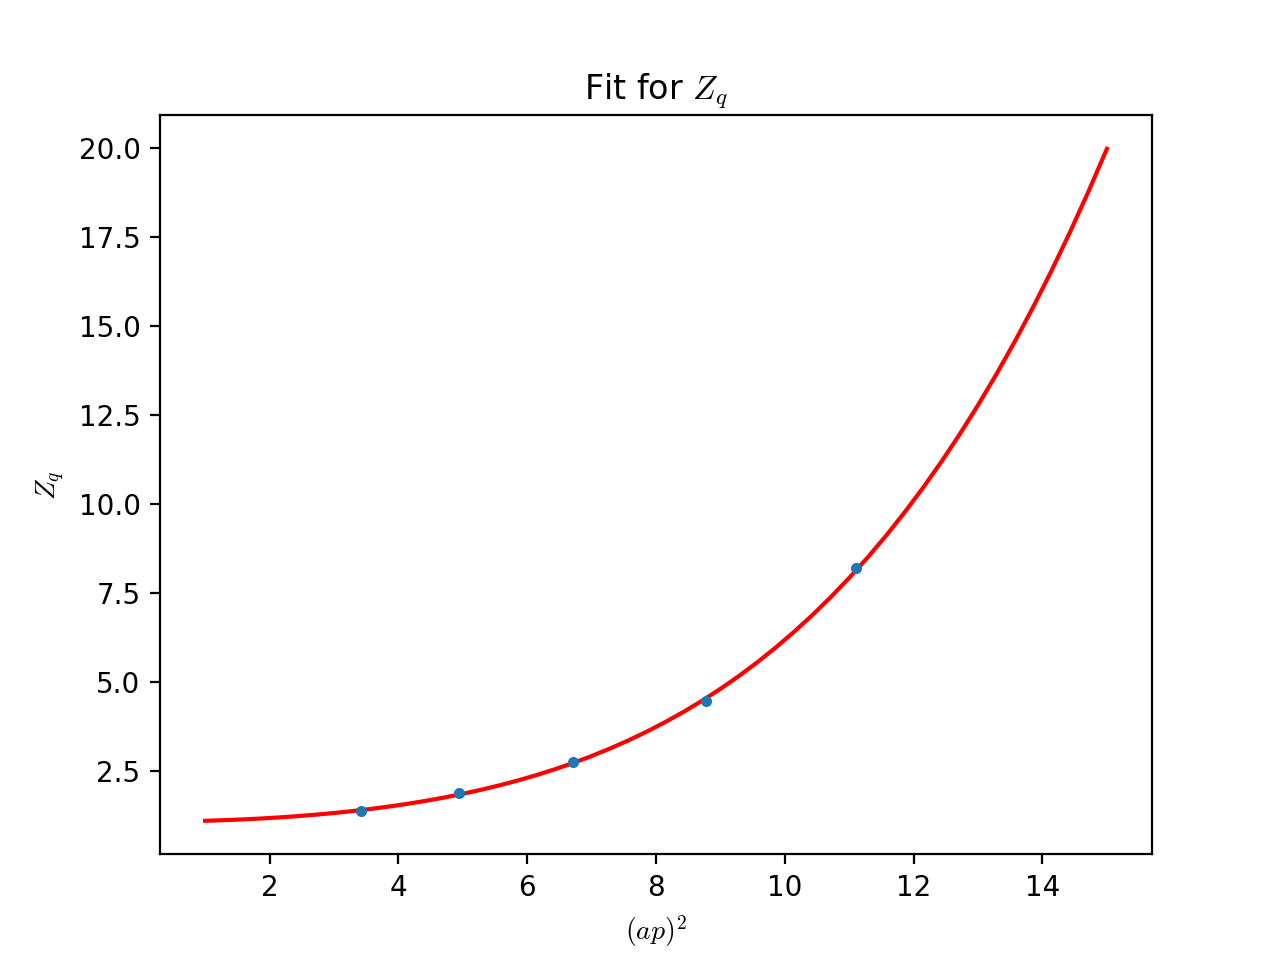

In [41]:
mom_subset = [3, 4, 5, 6, 7]
pwr = 2
# fit_and_plot(Zq_extrap[0][mom_subset], scales[mom_subset] ** 2, pwr, '$Z_q$', x_range = [1, 25], x_label = '$μ^2 (GeV^2)$')
fit_and_plot(Zq_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, '$Z_q$', x_range = [1, 15], x_label = '$(ap)^2$')
# fit_and_plot(Zq_extrap[0][mom_subset], scales[mom_subset], pwr, '$Z_q$', x_range = [1, 5])

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[1.11981284e+00 7.30131112e-04 6.54211583e-06 3.23696322e-08]
Chi^2: 1.265256582064257
Extrapolated Z_ij / Z_V^2 = 1.1269375241871755
[1.11870094e+00 7.33494877e-04 6.51214686e-06 3.21203522e-08]
Chi^2: 1.227098776062678
Extrapolated Z_ij / Z_V^2 = 1.1258532902995786
[1.11730298e+00 7.39330552e-04 6.48667841e-06 3.19309559e-08]
Chi^2: 1.0564480638712148
Extrapolated Z_ij / Z_V^2 = 1.1245056546657743
[1.11849793e+00 7.29339779e-04 6.52431560e-06 3.22402407e-08]
Chi^2: 1.3470356296005999
Extrapolated Z_ij / Z_V^2 = 1.1256139582002802
[1.11814033e+00 7.26710405e-04 6.51342693e-06 3.21728822e-08]
Chi^2: 1.5757443257528942
Extrapolated Z_ij / Z_V^2 = 1.1252317693934555
[1.12037639e+00 6.56906135e-04 7.69713062e-06 2.69387570e-08]
Chi^2: 1.7036546171227542
Extrapolated Z_ij / Z_V^2 = 1.126931653610723
[1.11874271e+00 7.28213934e-04 6.52904196e-06 3.22869773e-08]
Chi^2: 1.3360466579196357
Extrapolated Z_ij / Z_V^2 = 1.125849025621803
[1.11887308e+00

[1.11982066e+00 6.83212892e-04 7.31853210e-06 2.85379133e-08]
Chi^2: 1.3038254252032437
Extrapolated Z_ij / Z_V^2 = 1.126583186223159
[1.11944407e+00 6.85372091e-04 7.28320026e-06 2.85771003e-08]
Chi^2: 1.34493119774305
Extrapolated Z_ij / Z_V^2 = 1.1262231859126495
[1.11903307e+00 7.27870400e-04 6.53890392e-06 3.23227430e-08]
Chi^2: 1.4202765230945873
Extrapolated Z_ij / Z_V^2 = 1.1261371224802728
[1.11977461e+00 6.82506830e-04 7.32935219e-06 2.84337809e-08]
Chi^2: 1.4826927951452404
Extrapolated Z_ij / Z_V^2 = 1.1265315750113916
[1.11898913e+00 7.27762624e-04 6.53822653e-06 3.23182446e-08]
Chi^2: 1.42438138520165
Extrapolated Z_ij / Z_V^2 = 1.126092154645002
[1.11915343e+00 6.89874696e-04 7.19379594e-06 2.89471729e-08]
Chi^2: 1.3622432354908192
Extrapolated Z_ij / Z_V^2 = 1.1259661016978348
[1.11918344e+00 6.90141022e-04 7.22661819e-06 2.87834945e-08]
Chi^2: 1.4004345754027225
Extrapolated Z_ij / Z_V^2 = 1.1260010496276633
[1.11941045e+00 6.87687391e-04 7.24899303e-06 2.87473950e-08]

<IPython.core.display.Javascript object>


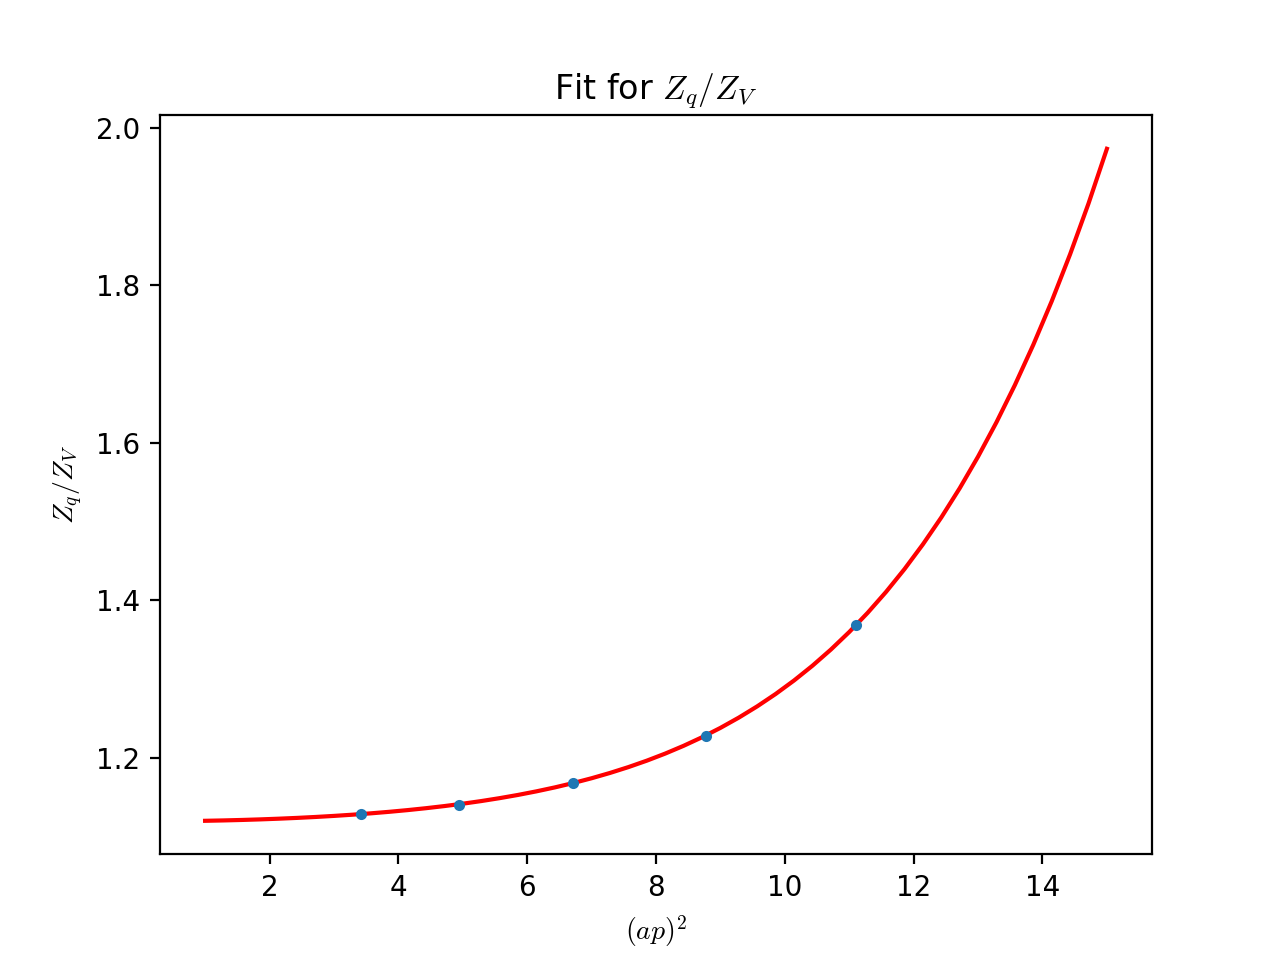

In [42]:
mom_subset = [3, 4, 5, 6, 7]
pwr = 3
fit_and_plot(Zq_extrap[0][mom_subset] / ZV_extrap[0][mom_subset], np.array([square(mom_list_24I[idx]) for idx in mom_subset]), pwr, '$Z_q / Z_V$', x_range = [1, 15], x_label = '$(ap)^2$')
# fit_and_plot(Zq_extrap[0][mom_subset] / ZV_extrap[0][mom_subset], scales[mom_subset], pwr, '$Z_q / Z_V$', x_range = [1, 5])

In [43]:
# x_fit_b = np.linspace(2, 5)
# fx_fit_b = np.zeros(x_fit_b.shape, dtype = np.float64)
# for ii in range(pwr + 1):
#     ci_mu_b = np.mean(fit_coeffs_b[ii])
#     moment = x_fit_b ** (2 * ii)
#     fx_fit_b += ci_mu_b * moment

In [44]:
# Z11_fit_mean = np.zeros((len(mom_subset)), dtype = np.float64)
# Z11_fit_std = np.zeros((len(mom_subset)), dtype = np.float64)
# for i in range(len(mom_subset)):
#     fit_data_boots = Superboot(2)
#     fit_data_boots.boots = Z_chiral_boots[0, 0, mom_subset[i]]
#     Z11_fit_mean[i] = fit_data_boots.compute_mean()
#     Z11_fit_std[i] = fit_data_boots.compute_std()
# plt.figure()
# plt.errorbar(scales[mom_subset], Z11_fit_mean, Z11_fit_std, fmt = '.')
# plt.plot(x_fit_b, fx_fit_b, c = 'r')
# plt.title('Fit for $Z_{11} / Z_V^2$')
# plt.xlabel('μ (GeV)')
# plt.ylabel('$Z_{11} / Z_V^2$')
# plt.show()

In [45]:
# test of fitting code

# fake_signal = scales ** 2
# variation = np.random.uniform(low = 0.9, high = 1.0, size = (2, 50))
# fake_data = np.einsum('i,jk->ijk', fake_signal, variation)
# fit_coeffs, chi2, y_extrap = corr_superboot_fit_apsq(scales, fake_data)
# c0_mu = np.mean(fit_coeffs[0])
# c1_mu = np.mean(fit_coeffs[1])
# x_fit = np.linspace(1, 5)
# fx_fit = c0_mu * np.ones(x_fit.shape) + c1_mu * (x_fit ** 2)
# fake_mean = np.zeros((len(scales)), dtype = np.float64)
# fake_std = np.zeros((len(scales)), dtype = np.float64)
# for i in range(len(scales)):
#     fake_data_boots = Superboot(2)
#     fake_data_boots.boots = fake_data[i]
#     fake_mean[i] = fake_data_boots.compute_mean()
#     fake_std[i] = fake_data_boots.compute_std()
# plt.figure()
# plt.errorbar(scales, fake_mean, fake_std, fmt = '.')
# plt.plot(x_fit, fx_fit, c = 'r')
# plt.title('Testing fitting code')
# plt.show()

In [46]:
# some fits of Z_ij (NOT divided by Z_V^2), just here for context
Z22_boots = np.zeros((8, 2, 50))
Z22_boots[:, 0, :] = Z_list[0][0, 0]
Z22_boots[:, 1, :] = Z_list[1][0, 0]
mom_subset = [3, 4, 5, 6, 7]
pwr = 3
fit_coeffs_b, chi2_b, y_extrap_b = corr_superboot_fit_apsq(scales[mom_subset], Z22_boots[mom_subset], order = pwr)
# fit_coeffs_b, chi2_b, y_extrap_b = corr_superboot_fit_apsq(np.array([square(mom_list_24I[idx]) for idx in mom_subset]), Z22_boots[mom_subset], order = pwr)
x_fit_b = np.linspace(2, 5)
# x_fit_b = np.linspace(2, 15)
fx_fit_b = np.zeros(x_fit_b.shape, dtype = np.float64)
for ii in range(pwr + 1):
    ci_mu_b = np.mean(fit_coeffs_b[ii])
    moment = x_fit_b ** (2 * ii)
    fx_fit_b += ci_mu_b * moment

Fitting c0
+ c1 \mu^2
+ c2 \mu^4
+ c3 \mu^6
[ 8.41719208e+00 -1.03025506e+00 -2.42611268e-03  3.65442390e-03]
Chi^2: 1194640.310623054
Extrapolated Z_ij / Z_V^2 = 1.6124564348091077
[ 8.41861544e+00 -1.03053508e+00 -2.42855409e-03  3.65532612e-03]
Chi^2: 1196126.0243690745
Extrapolated Z_ij / Z_V^2 = 1.6118195433167772
[ 8.42422334e+00 -1.03135534e+00 -2.43176071e-03  3.65804496e-03]
Chi^2: 1197622.559315138
Extrapolated Z_ij / Z_V^2 = 1.611767454737744
[ 8.41955925e+00 -1.03065446e+00 -2.42882408e-03  3.65570286e-03]
Chi^2: 1195963.0384468804
Extrapolated Z_ij / Z_V^2 = 1.61194171522792
[ 8.41970373e+00 -1.03074448e+00 -2.42812060e-03  3.65608424e-03]
Chi^2: 1196070.2876383543
Extrapolated Z_ij / Z_V^2 = 1.611611069840726
[ 8.41646474e+00 -1.03023245e+00 -2.42556795e-03  3.65440011e-03]
Chi^2: 1194665.3878044665
Extrapolated Z_ij / Z_V^2 = 1.6119593628576687
[ 8.41949009e+00 -1.03060916e+00 -2.42775566e-03  3.65566889e-03]
Chi^2: 1196087.9830992515
Extrapolated Z_ij / Z_V^2 = 1.612342

[ 8.41591973e+00 -1.03018159e+00 -2.42988188e-03  3.65370463e-03]
Chi^2: 1194083.3137378201
Extrapolated Z_ij / Z_V^2 = 1.611015622711013
[ 8.41375418e+00 -1.02980548e+00 -2.42716647e-03  3.65246013e-03]
Chi^2: 1192397.9111130629
Extrapolated Z_ij / Z_V^2 = 1.6115478244328796
[ 8.41707161e+00 -1.03033825e+00 -2.42902136e-03  3.65435215e-03]
Chi^2: 1194209.1435876964
Extrapolated Z_ij / Z_V^2 = 1.611299384681328
[ 8.41603018e+00 -1.03016741e+00 -2.42908532e-03  3.65369951e-03]
Chi^2: 1193748.9968436046
Extrapolated Z_ij / Z_V^2 = 1.611314472961104
[ 8.41265276e+00 -1.02969904e+00 -2.42665566e-03  3.65215127e-03]
Chi^2: 1192452.0425981714
Extrapolated Z_ij / Z_V^2 = 1.6112205757913334
[ 8.41177252e+00 -1.02956572e+00 -2.42614457e-03  3.65172291e-03]
Chi^2: 1192334.2935577335
Extrapolated Z_ij / Z_V^2 = 1.6112693059250243
[ 8.41535587e+00 -1.03006886e+00 -2.42786835e-03  3.65340641e-03]
Chi^2: 1193172.2729793538
Extrapolated Z_ij / Z_V^2 = 1.6114120844934217
[ 8.41395963e+00 -1.02986096e+

In [47]:
np.mean(chi2_b)

1194502.8825475331

<IPython.core.display.Javascript object>


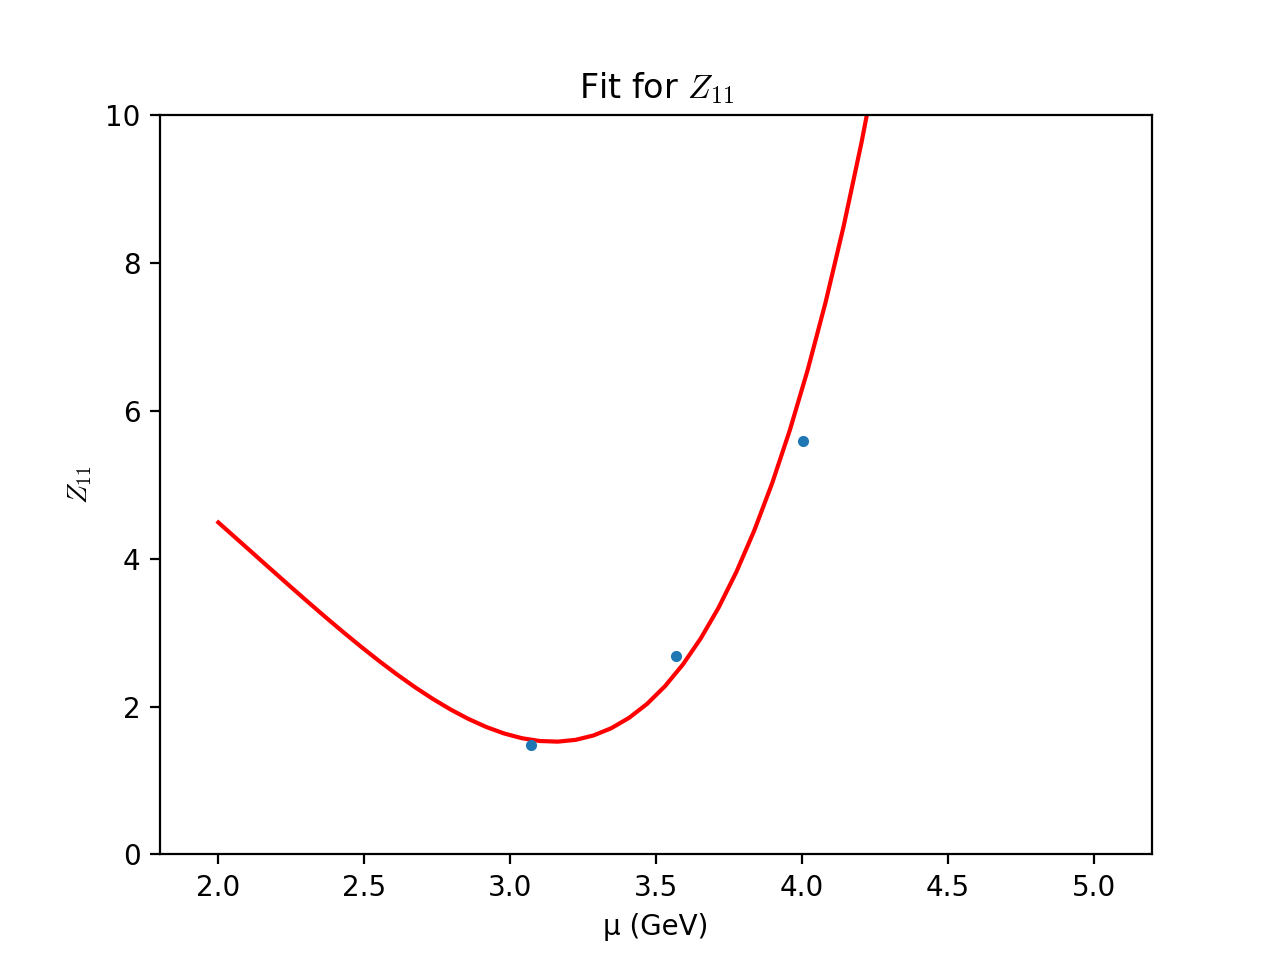

In [48]:
Zij_fit_mean = np.zeros((len(mom_subset)), dtype = np.float64)
Zij_fit_std = np.zeros((len(mom_subset)), dtype = np.float64)
for i in range(len(mom_subset)):
    fit_data_boots = Superboot(2)
    fit_data_boots.boots = Z22_boots[mom_subset[i]]
    Zij_fit_mean[i] = fit_data_boots.compute_mean()
    Zij_fit_std[i] = fit_data_boots.compute_std()
plt.figure()
plt.errorbar(scales[mom_subset], Zij_fit_mean, Zij_fit_std, fmt = '.')
# plt.errorbar(np.array([square(mom_list_24I[idx]) for idx in mom_subset]), Zij_fit_mean, Zij_fit_std, fmt = '.')
plt.plot(x_fit_b, fx_fit_b, c = 'r')
plt.xlim((1.8, 5.2))
# plt.xlim((1.8, 15))
plt.ylim((0, 10))
plt.title('Fit for $Z_{11}$')
plt.xlabel('μ (GeV)')
plt.ylabel('$Z_{11}$')
plt.show()

In [49]:
Z_norm_interp_mu = np.zeros((5, 5), dtype = np.float64)
Z_norm_interp_sigma = np.zeros((5, 5), dtype = np.float64)
ff = h5py.File(chi_extrap_lin_paths[0], 'r')
for i, j in itertools.product(range(5), repeat = 2):
    key = 'O' + str(i + 1) + str(j + 1) + '/interpZijZVm2'
    tmp = Superboot(2)
    try:
        # Z_norm_interp[i, j] = ff[key]
        tmp.boots = ff[key][()]
        Z_norm_interp_mu[j, i] = tmp.compute_mean()
        Z_norm_interp_sigma[j, i] = tmp.compute_std()
    except:
        print('no key here')

no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here
no key here


In [50]:
Z_norm_interp_mu

array([[ 1.02917193,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.1898464 ,  0.04625317,  0.        ,  0.        ],
       [ 0.        ,  0.32444356,  1.00099701,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.05203059, -0.29547177],
       [ 0.        ,  0.        ,  0.        , -0.04615061,  1.17230453]])

In [51]:
Z_norm_interp_sigma

array([[0.00111491, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00094671, 0.00017279, 0.        , 0.        ],
       [0.        , 0.00077945, 0.00104494, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00111497, 0.00082184],
       [0.        , 0.        , 0.        , 0.00017409, 0.00095076]])

## Axial / Vector renormalization

In [52]:
f2 = h5py.File('/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/ml0p01/AVcurrents.h5', 'r')
GammaA = f2['GammaA'][()]
qDotA = f2['qDotA'][()]
ZA2 = f2['ZA'][()]
f2.close()

In [53]:
qslashList = np.einsum('pm,mij->pij', np.array(mom_list_24I), gamma)
qsqList = np.array([square(q) for q in mom_list_24I])
qDotAred = np.einsum('pzaiaj,jk,pki->pz', qDotA, gamma5, qslashList) / 12

<IPython.core.display.Javascript object>


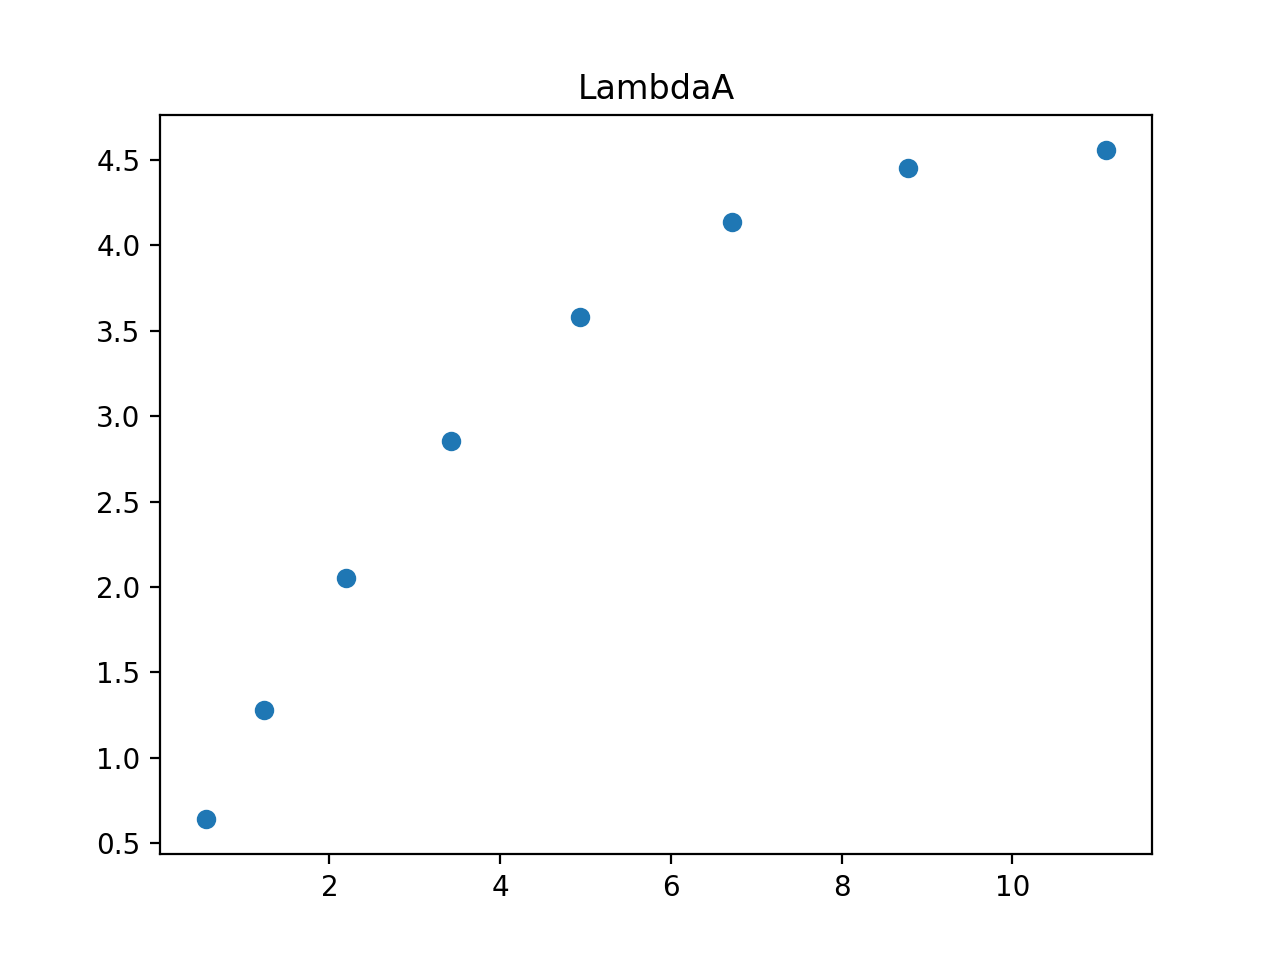

In [54]:
plt.figure()
plt.scatter([square(k) for k in mom_list_24I], np.abs(np.mean(qDotAred, axis = 1)))
plt.title('LambdaA')
# todo see what this looks like with qslashsquared dividing it
plt.show()

## Chiral extrapolation on David's ZA values

In [153]:
# mass_list = np.array([0.01, 0.005])
# cfgs = ['24I/ml_0p01', '24I/ml_0p005']
mass_list = np.array([0.008, 0.006, 0.004])
cfgs = ['32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
fpaths = ['/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/'+cfg+'/twopt_out.h5' for cfg in cfgs]
fs = [h5py.File(fp, 'r') for fp in fpaths]
ZA_dat = np.array([F['ZA_ratio'][()] for F in fs])
[F.close() for F in fs]

[None, None, None]

In [148]:
ZA_ens = []
for ZA_b in ZA_dat:
    ZA_fits, ZA_stats, ZA_fit_boots, ZA_weights = fit_constant_allrange(ZA_b)
    Zratio_mu, Zratio_sigma = analyze_accepted_fits(ZA_fit_boots, ZA_weights)
    print('From function in code: ZA = ' + str(Zratio_mu) + ' \pm ' + str(Zratio_sigma))
    ZA_weights = ZA_weights / np.sum(ZA_weights)
    ZA_boot = np.einsum('z,zb->b', ZA_weights, ZA_fit_boots)
    ZA_boot_sp = spread_boots(ZA_boot, Zratio_sigma)    # bootstrapping doesn't include systematic error, so spread it
    print('By hand : ZA = ' + str(np.mean(ZA_boot)) + ' \pm ' + str(np.std(ZA_boot, ddof = 1)))
    print('By hand with spreading: ZA = ' + str(np.mean(ZA_boot_sp)) + ' \pm ' + str(np.std(ZA_boot_sp, ddof = 1)))
    ZA_ens.append(ZA_boot_sp)
ZA_ens = np.array(ZA_ens)    # now should have a list of bootstraps, (n_ens, n_boot)
ZA_ens_mu = np.mean(ZA_ens, axis = 1)
ZA_ens_std = np.std(ZA_ens, axis = 1, ddof = 1)

Accepted fits
fit index | fit range | p value | meff mean | meff sigma | weight 
399 range(7, 11) 0.41295577377734494 0.745291032395068 7.040858350374987e-05 83301405.34529246
400 range(7, 12) 0.5774940928272216 0.7452968695563398 6.543252948734774e-05 134883903.89468372
401 range(7, 13) 0.057337120841022736 0.7453787592401311 7.065406020352635e-05 11485810.140250511
411 range(7, 23) 0.01189038492585839 0.7452391696182632 4.861749011916875e-05 5030496.428371635
412 range(7, 24) 0.017914756115375265 0.7452400421847295 4.879789889738363e-05 7523304.751884457
413 range(7, 25) 0.023662916591708594 0.7452334466300857 5.0174782146066234e-05 9399338.32035679
414 range(7, 26) 0.02114466249519633 0.7452474939072031 4.574002323222799e-05 10106667.911790296
415 range(7, 27) 0.02657690308515867 0.7452536832741314 4.781493502638123e-05 11624578.986619346
416 range(7, 28) 0.03592179169278809 0.7452503632000677 4.7910609429512145e-05 15649288.599237043
417 range(7, 29) 0.04054655730914236 0.745260833

666 range(12, 28) 0.01395966468166941 0.7452324042795619 5.085122672941121e-05 5398487.721306833
667 range(12, 29) 0.015903445656736397 0.7452481453342518 4.65365640670242e-05 7343491.549402218
668 range(12, 30) 0.011508673131007752 0.7452220270327976 4.239228445758846e-05 6404004.288044633
669 range(12, 31) 0.01702530953363047 0.7452219761865309 4.347944549761984e-05 9005897.979192272
702 range(13, 17) 0.0869161625952556 0.7450809949311642 6.542336117734506e-05 20306488.920860104
703 range(13, 18) 0.1280009408510606 0.745053242862695 6.789313627667783e-05 27769075.401331663
704 range(13, 19) 0.16399356122802491 0.7450820434018514 6.664210120001757e-05 36925759.21776023
705 range(13, 20) 0.06268982807572322 0.7451471206988748 7.357438652223692e-05 11580939.150076423
706 range(13, 21) 0.07272743675221627 0.7451204231672167 6.568674853156652e-05 16855543.135290056
707 range(13, 22) 0.11227804429333202 0.7451223582073702 6.0076881412229504e-05 31108572.1952093
708 range(13, 23) 0.10213888

802 range(15, 26) 0.2670956398597376 0.7452309965562902 5.274162102822968e-05 96019590.81331716
803 range(15, 27) 0.30466205692601533 0.7452431783407522 5.570894336947558e-05 98167679.98054177
804 range(15, 28) 0.3743803057606177 0.7452380816645305 5.612490113957493e-05 118850719.87721498
805 range(15, 29) 0.38806960195630247 0.7452568657127167 4.9435590776745846e-05 158792566.5048693
806 range(15, 30) 0.28894192993136214 0.7452243384319075 4.476687917609624e-05 144177313.9001129
807 range(15, 31) 0.3552805118800652 0.7452241337323973 4.5788285232568267e-05 169458214.7593645
808 range(15, 32) 0.1910021279775967 0.7452579393241696 4.79970412100665e-05 82910450.28381412
809 range(15, 33) 0.12285783476814187 0.7452383868722018 4.997075543893561e-05 49200671.15710082
810 range(15, 34) 0.09886157016892844 0.7452577420284142 4.537634552720373e-05 48014064.49074252
811 range(15, 35) 0.10858489285216452 0.7452497456839527 4.7396771797764673e-05 48336130.61793203
812 range(15, 36) 0.13752944856

896 range(17, 33) 0.14005559350331476 0.745243518440681 5.731469549880071e-05 42635217.15998925
897 range(17, 34) 0.11486979920534263 0.7452649858501315 5.150728628750927e-05 43298068.523908034
898 range(17, 35) 0.12489912084625454 0.7452556750134491 5.370690649712285e-05 43301117.60954141
899 range(17, 36) 0.15936180584118315 0.7452591829425765 5.050226568078323e-05 62483092.747551836
900 range(17, 37) 0.15274898506072612 0.7452733438163603 5.266426722788812e-05 55073951.996754825
901 range(17, 38) 0.19216742241421944 0.7452725370072004 5.155389053871669e-05 72303092.77495505
902 range(17, 39) 0.17577916021655904 0.7452618523236899 5.2337222868030675e-05 64172068.2581728
903 range(17, 40) 0.028129564635139843 0.7452965235092209 5.168837634603713e-05 10528760.098645411
904 range(17, 41) 0.02072318300168782 0.7452838971458641 4.975533975429158e-05 8370994.755492593
905 range(17, 42) 0.01734249900619289 0.745274883015982 4.8747837041141904e-05 7297951.569136929
906 range(17, 43) 0.023334

995 range(19, 49) 0.05887930274462989 0.7452841362609266 4.965782966666465e-05 23877408.498938773
996 range(19, 50) 0.07198409439355716 0.7452818381380726 4.949690065844277e-05 29381944.50149884
997 range(19, 51) 0.0867635800152455 0.7452790935992231 4.7555631462657074e-05 38364854.71383104
998 range(19, 52) 0.07913363034187443 0.7452713145034899 4.9079080670313707e-05 32852486.969942193
999 range(19, 53) 0.09816692792029738 0.7452713449585644 4.973955199597111e-05 39679067.90697361
1000 range(19, 54) 0.12007367115005126 0.7452710922685885 5.0918588278040826e-05 46312164.63371979
1001 range(19, 55) 0.12439734911948443 0.7452643698039413 4.7606327105800614e-05 54888551.888067394
1002 range(19, 56) 0.07506670286701189 0.7452778781434471 4.7664285485868225e-05 33041607.407514222
1003 range(19, 57) 0.08795166966641996 0.7452805777746319 4.728586387927258e-05 39335206.37631477
1004 range(19, 58) 0.10533320903355227 0.7452824872012528 4.701442236037214e-05 47654411.02166055
1005 range(19, 59

1089 range(22, 26) 0.5650673047915278 0.7453331178653027 8.406276937845589e-05 79963683.70934574
1090 range(22, 27) 0.7090604250100488 0.7453482291627722 8.495071023315601e-05 98253768.88796929
1091 range(22, 28) 0.7546896389704401 0.7453194716252347 7.910275039379917e-05 120610528.19789165
1092 range(22, 29) 0.826664040583165 0.7453399589331205 6.208696544579558e-05 214451050.88925073
1093 range(22, 30) 0.44613378368366363 0.7452620265509452 4.760271299163102e-05 196880045.85026315
1094 range(22, 31) 0.5507257007728987 0.7452576132319904 4.63688106398372e-05 256143554.21998948
1095 range(22, 32) 0.3410515770652445 0.7453070515241786 4.839446201422383e-05 145622582.78113776
1096 range(22, 33) 0.17205823676752638 0.7452725538806704 5.2045493107338464e-05 63519813.27012465
1097 range(22, 34) 0.15707367628591856 0.7452979393925807 4.465844592427568e-05 78758275.20994508
1098 range(22, 35) 0.16171553287654283 0.7452838778009406 4.702344495300403e-05 73134593.3857384
1099 range(22, 36) 0.21

1180 range(24, 44) 0.022242213259336396 0.7452892915212853 4.800537955646343e-05 9651574.889576292
1181 range(24, 45) 0.02882749811281567 0.7452841608737031 4.6496405314078304e-05 13334237.786296925
1182 range(24, 46) 0.0302867292412115 0.7452937856946388 4.351595414453139e-05 15993936.01156915
1183 range(24, 47) 0.03671470880108651 0.7452990132210734 4.5400487457236264e-05 17812261.25398985
1184 range(24, 48) 0.046856092235492044 0.7452953434677586 4.842763732972056e-05 19979264.81168722
1185 range(24, 49) 0.045054893797788965 0.7452869264747648 4.775237760188955e-05 19758408.956940845
1186 range(24, 50) 0.056709264638834495 0.7452842043612435 4.794019821300985e-05 24674841.12685678
1187 range(24, 51) 0.07015850729730143 0.7452809813749112 4.5523082068050216e-05 33854548.41593551
1188 range(24, 52) 0.06356836647444326 0.7452720011844757 4.787427624081448e-05 27735538.901988182
1189 range(24, 53) 0.08117696565220082 0.745272006931562 4.8586508503579344e-05 34387565.552976295
1190 range

1292 range(27, 54) 0.08107288201064743 0.7452653605762792 5.1762307597143e-05 30258566.76844038
1293 range(27, 55) 0.08670281403450547 0.7452574783204323 4.734171077886877e-05 38685240.16762486
1294 range(27, 56) 0.04681501571620491 0.7452740884462592 4.765877455622788e-05 20611017.456573986
1295 range(27, 57) 0.05687708495870115 0.7452774416751011 4.7597649285059066e-05 25105352.331282206
1296 range(27, 58) 0.07092180299498924 0.7452798437341163 4.721930240277089e-05 31808312.862493943
1297 range(27, 59) 0.0890411596792922 0.7452797611444164 4.482821709856707e-05 44308584.349187195
1298 range(27, 60) 0.025882855728699736 0.7452664909551097 4.555536135735626e-05 12471916.647958895
1302 range(28, 32) 0.0590694471843048 0.7452968036698561 7.313722874618988e-05 11042970.338134767
1303 range(28, 33) 0.027148331966620556 0.7452389173249717 7.84269841042027e-05 4413794.628706593
1304 range(28, 34) 0.024705512814455925 0.7452852377400877 6.072003029897459e-05 6700850.270681641
1305 range(28, 

1434 range(32, 46) 0.024532344448246014 0.7452902540835062 4.915247893058567e-05 10154258.201269481
1435 range(32, 47) 0.03160388313586326 0.7452984698591567 5.283142163485439e-05 11322852.57420283
1436 range(32, 48) 0.04318193416216852 0.7452929485167575 5.626735398237353e-05 13639206.53202302
1437 range(32, 49) 0.04250950943938962 0.745280546079055 5.4538837162696525e-05 14291385.864365965
1438 range(32, 50) 0.05670149835416403 0.7452767575908856 5.461184147884019e-05 19011697.41383606
1439 range(32, 51) 0.0738351450255835 0.7452724019659545 5.1704470645125376e-05 27618935.76404304
1440 range(32, 52) 0.06859490718284683 0.7452599767560554 5.378722381808436e-05 23710112.4954995
1441 range(32, 53) 0.0909423235731724 0.7452606235296213 5.485705842326521e-05 30220456.08615003
1442 range(32, 54) 0.11787689739086932 0.7452606403777832 5.5982456783692475e-05 37611858.133650884
1443 range(32, 55) 0.12754482590311714 0.745250936177011 5.007369474015765e-05 50867872.07302486
1444 range(32, 56)

1543 range(36, 53) 0.12595723200870343 0.7452671609346236 6.051785013298947e-05 34391896.498717405
1544 range(36, 54) 0.1640390438706552 0.7452668693445907 6.178245279937594e-05 42975104.07965887
1545 range(36, 55) 0.17523996493574692 0.7452544162809063 5.476179208798817e-05 58435646.5420802
1546 range(36, 56) 0.09240662049973666 0.7452799444537455 5.393603530289363e-05 31764721.254628986
1547 range(36, 57) 0.11387822923402895 0.7452847071661642 5.327487700003651e-05 40123221.37855481
1548 range(36, 58) 0.14318169891122812 0.7452877887607393 5.18906883626169e-05 53175140.65671603
1549 range(36, 59) 0.17912151233108714 0.7452873065449451 4.860274542987651e-05 75827396.22190028
1550 range(36, 60) 0.04882161818292317 0.7452680450468075 4.89928193974655e-05 20339829.343079176
1557 range(37, 44) 0.015227044589823446 0.7452754813067983 8.197649289625009e-05 2265880.2319947924
1558 range(37, 45) 0.025357127795365086 0.7452630025424568 7.19027905031614e-05 4904656.181883936
1559 range(37, 46) 

1655 range(41, 60) 0.3456955621945976 0.7452374348825527 5.2523405576445954e-05 125310669.15552182
1659 range(42, 46) 0.6615636394383653 0.7453040452415348 7.716164717046217e-05 111113965.64302146
1660 range(42, 47) 0.7415608727794187 0.7453304436539687 7.215129200001893e-05 142448730.20023274
1661 range(42, 48) 0.8052770645379717 0.7453081478653503 7.857462799610456e-05 130430951.59041443
1662 range(42, 49) 0.7167808453093782 0.7452712256394105 7.282444419291814e-05 135154974.0994839
1663 range(42, 50) 0.7968534253334755 0.7452620009146937 7.182859366055007e-05 154448507.8898826
1664 range(42, 51) 0.8592278988808243 0.7452528834865909 6.60650459467193e-05 196863357.2960261
1665 range(42, 52) 0.8142777045734353 0.7452262375786889 6.655997351300834e-05 183800319.8395085
1666 range(42, 53) 0.8719740239429408 0.7452314783340163 6.618093313966278e-05 199084649.4805809
1667 range(42, 54) 0.9161269522943496 0.7452338618836031 6.917368243562972e-05 191458154.60572278
1668 range(42, 55) 0.9258

1769 range(49, 58) 0.4916345486846987 0.7452773583169815 5.8374645578986455e-05 144275929.5106851
1770 range(49, 59) 0.593046876402574 0.7452772886669469 5.2065272421275124e-05 218772501.47679093
1771 range(49, 60) 0.15858103016824607 0.7452366231023716 5.074176688628287e-05 61591398.19955456
1775 range(50, 54) 0.7852221805854541 0.7451824906247755 8.82650939740877e-05 100789335.74576753
1776 range(50, 55) 0.8764626812299803 0.7451614262427381 7.49797842310722e-05 155899619.93266064
1777 range(50, 56) 0.2365261973791666 0.7452597405208294 6.742451289241704e-05 52028776.659458965
1778 range(50, 57) 0.3090565471454728 0.7452754973008253 6.650025265951152e-05 69886188.86436456
1779 range(50, 58) 0.4052394399043934 0.7452846746425653 6.0474801052468204e-05 110805880.67057317
1780 range(50, 59) 0.5117889461511973 0.745283867785755 5.3272164093810596e-05 180339234.67616108
1781 range(50, 60) 0.1136620026506286 0.7452404936207628 5.263059356819043e-05 41033519.41836793
1785 range(51, 55) 0.75

447 range(7, 59) 0.19049062230440525 0.7451317851896068 4.3360865947828646e-05 101315923.40577778
448 range(7, 60) 0.0321723441269334 0.7451141556508749 4.305904818036249e-05 17352172.419444207
452 range(8, 12) 0.527193221572501 0.7452041918484142 0.00010597016392512436 46946433.571583726
453 range(8, 13) 0.3079271617601356 0.7451107033752059 9.236694141566255e-05 36092326.149615906
454 range(8, 14) 0.2975929378145912 0.7450421986687837 8.268822173640378e-05 43524652.88533911
455 range(8, 15) 0.3314466645166732 0.7450754187714069 7.07508631602822e-05 66214052.32073688
456 range(8, 16) 0.31188325928488425 0.7450335418455815 6.991955771988882e-05 63796186.52268681
457 range(8, 17) 0.30481796170502246 0.7450608264880091 7.142183092459186e-05 59755597.881721415
458 range(8, 18) 0.3280916565156712 0.7450814587273801 6.764582740796806e-05 71699010.12516513
459 range(8, 19) 0.31954292804179013 0.7451074197538219 6.508818253690796e-05 75426667.59174688
460 range(8, 20) 0.40196539210110266 0.74

555 range(10, 14) 0.1240788508651562 0.7450088905073479 9.184887349383831e-05 14707880.559948515
556 range(10, 15) 0.14840976808346648 0.7450598553300409 7.82357925724335e-05 24246637.148588333
557 range(10, 16) 0.16295230642336836 0.7450114095394258 7.612700794529146e-05 28117906.997690696
558 range(10, 17) 0.1580306665506214 0.7450473418307024 7.699066101692404e-05 26660314.92339334
559 range(10, 18) 0.1774118000766425 0.7450734307455932 7.237884789404647e-05 33865630.89950033
560 range(10, 19) 0.17550393551016527 0.7451046631738776 6.920946959213878e-05 36640029.76023848
561 range(10, 20) 0.24367643872138034 0.7451046993045634 6.348269947018937e-05 60464820.37300024
562 range(10, 21) 0.30221688285388043 0.7450963858579343 5.807117181690805e-05 89618473.53909718
563 range(10, 22) 0.381833751608021 0.7450977688865144 6.210647046727204e-05 98992118.11663535
564 range(10, 23) 0.23254940661703868 0.7450736490436445 6.051700405239861e-05 63498051.12507032
565 range(10, 24) 0.2907018256912

644 range(11, 54) 0.26248365653566286 0.7451014282749181 4.42332277326785e-05 134154425.78376806
645 range(11, 55) 0.29232262486390237 0.745103824601139 4.38429519255129e-05 152076761.32820037
646 range(11, 56) 0.31865575016667697 0.7451064332938573 4.5100508906874735e-05 156660271.52618733
647 range(11, 57) 0.2980305324650132 0.7451134018222362 4.523015443877254e-05 145681571.4217371
648 range(11, 58) 0.27084338551907816 0.74511994494284 4.324245153669199e-05 144843035.92027116
649 range(11, 59) 0.26724212773004036 0.7451158004768342 4.3758704680812675e-05 139564834.61900023
650 range(11, 60) 0.05374365983794413 0.7450973498035668 4.326186675520096e-05 28715522.762477282
654 range(12, 16) 0.388682508412119 0.7449338969894851 9.253205523478073e-05 45395267.54294625
655 range(12, 17) 0.2628495596161343 0.7449905087996608 8.900325486051263e-05 33181458.790941976
656 range(12, 18) 0.24645370341166778 0.7450299863807837 7.841116731868089e-05 40084780.5172758
657 range(12, 19) 0.20636158411

735 range(13, 50) 0.14349270564684827 0.7451094486204373 4.4476023879461436e-05 72540060.7748155
736 range(13, 51) 0.17077150774155028 0.745109233060028 4.533891100117903e-05 83075553.53875735
737 range(13, 52) 0.1965821967108975 0.7451112502093348 4.390704652311377e-05 101970778.42281774
738 range(13, 53) 0.22895838511252697 0.7451114109628121 4.5918534086581266e-05 108587672.15875049
739 range(13, 54) 0.257150447328416 0.7451094667373254 4.472195291748223e-05 128571811.83416992
740 range(13, 55) 0.2885403415905708 0.7451117337023728 4.414927872857689e-05 148033264.2864371
741 range(13, 56) 0.3166629598806209 0.7451142875836959 4.5474466537110314e-05 153130619.94980818
742 range(13, 57) 0.2991496204498485 0.7451213099262347 4.583795387067452e-05 142376400.710037
743 range(13, 58) 0.2744881533658324 0.7451279199094226 4.376042347786021e-05 143337746.79886097
744 range(13, 59) 0.2687938990504263 0.7451235230838423 4.432939806271232e-05 136784138.27263597
745 range(13, 60) 0.050006607862

827 range(15, 51) 0.17221572378572905 0.7451162266256585 4.9173165211027786e-05 71222378.48988974
828 range(15, 52) 0.1995382866121767 0.7451182509539462 4.760921925732007e-05 88032719.77723247
829 range(15, 53) 0.23315039197822396 0.7451182849814744 4.968089273069955e-05 94462050.26030928
830 range(15, 54) 0.2616534086075437 0.7451160784720362 4.8133698760263696e-05 112934835.97701204
831 range(15, 55) 0.2950182082628743 0.7451183144440979 4.72426999126566e-05 132184155.89691179
832 range(15, 56) 0.3252071572353633 0.7451209176059197 4.886855998933467e-05 136176137.40144727
833 range(15, 57) 0.30996268686729017 0.7451282593928901 4.884521618535524e-05 129916808.91506575
834 range(15, 58) 0.287015795012559 0.7451351865858029 4.643689541185551e-05 133100425.48362996
835 range(15, 59) 0.27903473404618545 0.7451303639468825 4.697388124237414e-05 126457728.44790414
836 range(15, 60) 0.0488882209059659 0.7451095082702247 4.629378501172169e-05 22811763.069767047
840 range(16, 20) 0.960129684

942 range(18, 37) 0.11882393846546545 0.7451050018342772 5.596597357018687e-05 37936373.9003717
943 range(18, 38) 0.14633096691920286 0.7450979867620714 5.502196675150516e-05 48335255.88580128
944 range(18, 39) 0.14430866868122394 0.7450843704342206 5.434031634071261e-05 48870647.76241787
945 range(18, 40) 0.08696893359424293 0.7451114309292195 5.010969116753293e-05 34635438.67390261
946 range(18, 41) 0.09785146588941424 0.7451027660016688 5.0103227185596505e-05 38979470.57025993
947 range(18, 42) 0.11399988137838185 0.7450974666785157 5.1683005624644765e-05 42678473.28228983
948 range(18, 43) 0.1225311820150221 0.7451063354879711 4.911622351142208e-05 50792160.79876965
949 range(18, 44) 0.0905002903784954 0.7451185995396397 5.086202527583893e-05 34983453.01429744
950 range(18, 45) 0.10723525033112234 0.745114463825588 5.348487031189443e-05 37486567.51791759
951 range(18, 46) 0.1282167206965892 0.7451108378005395 4.9468894573266796e-05 52393842.895360686
952 range(18, 47) 0.15705088722

1034 range(20, 48) 0.14674254765308284 0.7450944275114324 4.7533820085033336e-05 64945732.38783062
1035 range(20, 49) 0.17529702596417393 0.7450970822154411 4.747626382256158e-05 77771679.72261219
1036 range(20, 50) 0.1149503896844327 0.7451105729870757 4.826408668938377e-05 49347171.32755262
1037 range(20, 51) 0.1411536846608741 0.7451102725035625 4.9623608471262365e-05 57321234.6569249
1038 range(20, 52) 0.16673524314060031 0.7451128446796692 4.821679610657065e-05 71718419.28152478
1039 range(20, 53) 0.19923355260465123 0.7451130085010645 5.0626367893218046e-05 77733627.98688276
1040 range(20, 54) 0.22799064186218412 0.7451105084948993 4.8746961435373105e-05 95944905.98041815
1041 range(20, 55) 0.2607149223761982 0.7451133354427687 4.7996850829866684e-05 113172367.86534445
1042 range(20, 56) 0.2905918335484945 0.7451165214918326 4.98766836646993e-05 116812217.05889161
1043 range(20, 57) 0.274378744425822 0.745125237268996 4.95858587143016e-05 111592443.46871884
1044 range(20, 58) 0.2

1133 range(23, 33) 0.1183967577692671 0.7451863223612136 6.806181690501822e-05 25558345.27709198
1134 range(23, 34) 0.03147215653947042 0.7451217014495581 6.0957955760746655e-05 8469654.875414554
1135 range(23, 35) 0.04394292119126958 0.7451117835708131 6.109120617960978e-05 11774203.137935495
1136 range(23, 36) 0.06472470677925381 0.7451095626245978 6.082857161809978e-05 17492619.713429697
1137 range(23, 37) 0.09099643235345699 0.7451133614517205 5.908265723247338e-05 26067796.7836267
1138 range(23, 38) 0.11709992444334545 0.745103808454547 5.777405251028578e-05 35082533.71276853
1139 range(23, 39) 0.11551015382550617 0.7450866926309471 5.717370329895014e-05 35336824.1304262
1140 range(23, 40) 0.06692721475524005 0.7451190679863927 5.184480210897886e-05 24899596.508864615
1141 range(23, 41) 0.07667531393634805 0.7451082756611157 5.041726104261596e-05 30164564.92011486
1142 range(23, 42) 0.09185248416943295 0.7451017915864678 5.190154326341146e-05 34098114.38403297
1143 range(23, 43) 0

1242 range(26, 37) 0.04896915699031006 0.7451220462963707 6.224680862271787e-05 12638293.805654904
1243 range(26, 38) 0.06714354043879482 0.7451100632104511 6.0800458751453147e-05 18163123.05772437
1244 range(26, 39) 0.06685773708665096 0.7450900528825766 6.013297771617917e-05 18489546.22749796
1245 range(26, 40) 0.03770019135802366 0.7451260547599182 5.334812130587948e-05 13246626.602744544
1246 range(26, 41) 0.04444023629973732 0.7451135512669202 5.2106077447151955e-05 16368150.071981909
1247 range(26, 42) 0.05538790927135312 0.7451061594311136 5.372959111464539e-05 19186152.891924035
1248 range(26, 43) 0.06399080297950131 0.7451171439777515 5.199480489940227e-05 23669967.08510604
1249 range(26, 44) 0.04633031822783973 0.7451325542078123 5.378977069348415e-05 16012749.049530627
1250 range(26, 45) 0.05799234671969963 0.7451267953899661 5.65922842695742e-05 18107405.83117242
1251 range(26, 46) 0.07341854707808453 0.7451217043474035 5.176795782788082e-05 27395783.13684511
1252 range(26,

1335 range(29, 34) 0.516489521212154 0.7449911098970127 7.883792349275132e-05 83098112.82210952
1336 range(29, 35) 0.660458293039329 0.7449890891969784 7.545931709659804e-05 115989761.83615966
1337 range(29, 36) 0.766303877421186 0.7449957496191706 7.30256326328863e-05 143697881.99830192
1338 range(29, 37) 0.7982973281414398 0.7450162556222425 7.070978641654887e-05 159663492.49887058
1339 range(29, 38) 0.8714811101836356 0.7450161557524294 6.844973963341413e-05 186000613.6103399
1340 range(29, 39) 0.8871837628237422 0.7450003691598971 6.636137802073982e-05 201457199.89847738
1341 range(29, 40) 0.4709850951066147 0.7450569561047062 5.723491998907784e-05 143775538.70064914
1342 range(29, 41) 0.5342941578238494 0.7450474373088644 5.857087173005412e-05 155746053.1669251
1343 range(29, 42) 0.600755264629808 0.7450415860265222 5.955709667895714e-05 169367683.90520057
1344 range(29, 43) 0.5692594042738675 0.7450592276577207 5.7912456292338166e-05 169732982.69702694
1345 range(29, 44) 0.395274

1447 range(32, 59) 0.5383463187820794 0.7451194085452567 5.02890223731036e-05 212870441.9390959
1448 range(32, 60) 0.10046620991380151 0.7450870532706045 4.8279735890492636e-05 43101287.907019064
1452 range(33, 37) 0.44757414849322985 0.7449449996370952 9.338923554347314e-05 51318192.70954782
1453 range(33, 38) 0.5976171001897996 0.7449636084362996 7.795881179210073e-05 98331483.99079879
1454 range(33, 39) 0.7040587409667571 0.7449460599750227 7.5813231775259e-05 122495144.48553061
1455 range(33, 40) 0.16223968667270156 0.7450442428216981 6.277978456628866e-05 41163989.31659874
1456 range(33, 41) 0.22290070261074715 0.7450317676540998 6.423648688582674e-05 54019166.01951066
1457 range(33, 42) 0.29433941266609037 0.7450243964883669 6.658894074985237e-05 66381063.48888102
1458 range(33, 43) 0.2711437745957433 0.7450506968253796 6.066721976613506e-05 73670132.69930534
1459 range(33, 44) 0.15623181199480587 0.7450794522128984 6.233613276528167e-05 40205897.2202853
1460 range(33, 45) 0.2033

1547 range(36, 57) 0.7319318618687798 0.7451561800500152 5.434685476849215e-05 247811708.98560005
1548 range(36, 58) 0.7037501012112792 0.745168361166161 5.058193219972061e-05 275060127.5765484
1549 range(36, 59) 0.6651260423247509 0.7451581812550344 5.106874142172652e-05 255031392.81429395
1550 range(36, 60) 0.10037555636490567 0.7451178275066538 4.850272504579609e-05 42667351.60412911
1554 range(37, 41) 0.12810620554092733 0.7450958392908582 8.14161623092437e-05 19326308.73808273
1555 range(37, 42) 0.19418056764692057 0.7450766133451827 7.69916654680032e-05 32758072.346859127
1556 range(37, 43) 0.22402899653354832 0.7451094412126942 6.993663617606338e-05 45803087.52319074
1557 range(37, 44) 0.15006160602656793 0.7451475945522197 6.943717065887713e-05 31123294.1482478
1558 range(37, 45) 0.19498561510341497 0.7451330585120125 7.136001697771351e-05 38290645.125270605
1559 range(37, 46) 0.25298188529754945 0.7451213093193846 6.201365857573407e-05 65783157.77814421
1560 range(37, 47) 0.33

1660 range(42, 47) 0.4615235939468767 0.745177945879702 8.184262074333155e-05 68902479.7749127
1661 range(42, 48) 0.5021725605862795 0.74513974299267 6.416292378473673e-05 121978892.84919663
1662 range(42, 49) 0.6284386414038783 0.745145249014342 6.631940050138816e-05 142883374.21857977
1663 range(42, 50) 0.4368905031852922 0.7451953018865987 5.751639804688673e-05 132065458.41416082
1664 range(42, 51) 0.5308344682757571 0.7451856119032199 5.982798118293301e-05 148303164.47369906
1665 range(42, 52) 0.6308205182810642 0.7451876384542824 6.0867168743763644e-05 170270577.55391827
1666 range(42, 53) 0.7138445258619591 0.7451823442003735 6.265523595311387e-05 181839778.5429464
1667 range(42, 54) 0.7501564914613729 0.745169982656835 5.45668717972972e-05 251938046.2552707
1668 range(42, 55) 0.8162575139543936 0.7451720774815602 5.19703954016441e-05 302214397.3418719
1669 range(42, 56) 0.8648606879438989 0.7451768911061839 5.6065400804103644e-05 275141622.752784
1670 range(42, 57) 0.86244333966

1790 range(51, 60) 0.02381416709273916 0.7450807478249785 5.482120017210814e-05 7923887.817038681
1794 range(52, 56) 0.9118607802211112 0.7451496219315534 0.00012071735406803629 62573308.88540563
1795 range(52, 57) 0.8437434662856729 0.7452076389497972 0.00010452395858347845 77228700.0106963
1796 range(52, 58) 0.8235939412954948 0.7452460734134596 8.067288187876723e-05 126548790.88898529
1797 range(52, 59) 0.6334755049420306 0.7452014816720255 7.042848493439625e-05 127712420.06439209
1798 range(52, 60) 0.015071680317637963 0.7450670189181777 6.880949446012875e-05 3183207.428097495
1802 range(53, 57) 0.7365629359622186 0.7452242102213046 9.588200146257927e-05 80119029.36666627
1803 range(53, 58) 0.7517411699425045 0.7452651207212534 7.773055529336087e-05 124418452.41271695
1804 range(53, 59) 0.5196459442843161 0.7452123550619251 6.219692802707744e-05 134328966.12214866
1809 range(54, 58) 0.8522819487374002 0.7453063388973686 8.45081464145902e-05 119340028.73024757
1810 range(54, 59) 0.4

476 range(8, 36) 0.04302166335000654 0.745024810547593 4.3133199848428633e-05 23124046.942906637
477 range(8, 37) 0.05328783642270241 0.7450303464070391 4.132219414007351e-05 31207669.639798127
478 range(8, 38) 0.05290016658375405 0.7450424377690511 4.0704597477732886e-05 31927882.080742475
479 range(8, 39) 0.05595791378314651 0.7450335570131327 4.250659389244077e-05 30970548.9476732
480 range(8, 40) 0.06848065979094978 0.7450294072773128 4.072814126575851e-05 41283713.47522666
481 range(8, 41) 0.04989169512788893 0.7450473395170962 3.702884234819865e-05 36387145.75912664
482 range(8, 42) 0.050775998353965957 0.7450379059452382 4.05260889079344e-05 30916411.95053544
483 range(8, 43) 0.06409493379301341 0.7450378743061765 3.891509225243242e-05 42324084.67806743
484 range(8, 44) 0.07713506827578658 0.7450422325201876 4.036867880281076e-05 47332865.4175653
485 range(8, 45) 0.06552521587786506 0.7450289636625955 3.711877813764469e-05 47557729.98208103
486 range(8, 46) 0.08101928703904307 0

572 range(10, 31) 0.029329980158311248 0.7449877777175926 5.31216629105215e-05 10393658.562164139
573 range(10, 32) 0.022568638832642526 0.7450146185184195 5.041220186758345e-05 8880430.776077416
574 range(10, 33) 0.03127488195622766 0.7450139033491149 4.6663938689271234e-05 14362594.313443655
575 range(10, 34) 0.032173030722766234 0.7450001092449761 4.769355658936675e-05 14144009.984625684
576 range(10, 35) 0.02360837731696338 0.7450190705032635 5.025131565063757e-05 9349131.410258247
577 range(10, 36) 0.03053387306685973 0.7450251057648929 4.6974621742824205e-05 13837426.03526541
578 range(10, 37) 0.03867276234393469 0.7450309413788782 4.5035117581087836e-05 19067887.9996526
579 range(10, 38) 0.03867932428443628 0.7450436616086268 4.4897430381404994e-05 19188273.8108915
580 range(10, 39) 0.04127387209644932 0.7450342648085504 4.661443332237012e-05 18994785.604136173
581 range(10, 40) 0.0514844360781301 0.745029896324542 4.497302188736919e-05 25454924.87718242
582 range(10, 41) 0.0370

681 range(12, 43) 0.02982576260809952 0.7450425788305587 4.309952970603897e-05 16056337.723135304
682 range(12, 44) 0.0375468087390739 0.7450472370098825 4.4064451043697716e-05 19337320.810077723
683 range(12, 45) 0.031183919930178078 0.7450323552638325 4.030216044296968e-05 19198798.540151857
684 range(12, 46) 0.040303723598810716 0.7450319513290782 4.0238211075754196e-05 24892461.42931245
685 range(12, 47) 0.04997307289712631 0.7450288011068692 3.968815921818177e-05 31725914.017166555
686 range(12, 48) 0.04903772442902806 0.745039344363804 3.9395329244418124e-05 31596635.48174839
687 range(12, 49) 0.05476818063586086 0.7450473416425981 3.7690421674938477e-05 38553722.89791726
688 range(12, 50) 0.0485924996100911 0.745038117261872 3.838815257133946e-05 32974241.58246413
689 range(12, 51) 0.04409836968583037 0.7450255762416621 3.595063404553437e-05 34120031.656091906
690 range(12, 52) 0.05329728614692398 0.7450288840235018 3.778859233800459e-05 37323612.08480234
691 range(12, 53) 0.059

822 range(15, 46) 0.026721526391755287 0.7450352878369273 4.2119606587962335e-05 15062347.060630282
823 range(15, 47) 0.03395105044900011 0.7450317833013301 4.183822500335639e-05 19395756.067503504
824 range(15, 48) 0.033670771444255496 0.7450430508318872 4.145275151911391e-05 19595048.401973262
825 range(15, 49) 0.038387024714555226 0.7450514981703894 3.924114936812316e-05 24928779.354654443
826 range(15, 50) 0.03373849797545876 0.7450415292817252 4.028295231526766e-05 20791372.510730103
827 range(15, 51) 0.030378909020485203 0.7450279644597327 3.687293386928612e-05 22343787.08277587
828 range(15, 52) 0.03754507540919293 0.7450314452511408 3.879114477097537e-05 24950990.3544584
829 range(15, 53) 0.04215860553614359 0.7450254459670834 3.862504075518336e-05 28258449.9577154
830 range(15, 54) 0.010162829237566092 0.7450537892601219 3.9158650840814294e-05 6627644.231057681
831 range(15, 55) 0.013242039555827664 0.7450522234554184 3.644671333434182e-05 9968691.106529614
832 range(15, 56) 0

970 range(19, 24) 0.01256236803337854 0.745069195001937 8.773039392102502e-05 1632192.4091832477
971 range(19, 25) 0.024738740233097606 0.7450544506431263 6.866057670293229e-05 5247623.721232871
972 range(19, 26) 0.04497839396787142 0.7450482142477997 7.257382116471682e-05 8539726.536786167
973 range(19, 27) 0.05288593362499983 0.7450126577707524 7.097039317657008e-05 10499914.269879617
974 range(19, 28) 0.03924995077147241 0.7450585958479121 5.907933434029647e-05 11245219.30831292
975 range(19, 29) 0.04224893019388711 0.745018133621988 6.580935823627862e-05 9755294.958843771
976 range(19, 30) 0.05734075768371485 0.7450377916197481 6.0569738590141306e-05 15629749.898366835
977 range(19, 31) 0.047419598007851574 0.7449878091983859 6.138855210772383e-05 12582967.85901114
978 range(19, 32) 0.03652108426918734 0.7450289114288888 5.731075353619396e-05 11119145.809750445
979 range(19, 33) 0.0538392183405491 0.7450269878303363 4.9258210245216705e-05 22189192.09134233
980 range(19, 34) 0.05515

1071 range(21, 46) 0.15024603510957715 0.74500647215008 3.9216435980905016e-05 97693748.97125034
1072 range(21, 47) 0.18202766353054883 0.7450031598284507 3.965224716330193e-05 115771533.35883011
1073 range(21, 48) 0.17110211166790407 0.7450178051961706 3.828345075653574e-05 116743636.08645594
1074 range(21, 49) 0.18283969207299927 0.7450290677467908 3.7966426987169304e-05 126844320.35761069
1075 range(21, 50) 0.16621907590212295 0.7450177499945424 3.8770659642984004e-05 110579464.69374539
1076 range(21, 51) 0.15619323486388847 0.745002860799922 3.570664169021485e-05 122507931.92170891
1077 range(21, 52) 0.18094462175066392 0.7450076757988607 3.717523670536031e-05 130929706.41735603
1078 range(21, 53) 0.199215161731141 0.745001303040862 3.7257006620087236e-05 143518031.97995135
1079 range(21, 54) 0.05314108094119396 0.7450352836049197 3.746545347024886e-05 37858935.37476364
1080 range(21, 55) 0.06672388271236214 0.745033861569326 3.4575234616992053e-05 55815014.09135949
1081 range(21, 

1183 range(24, 47) 0.4579333513679416 0.7450282707902176 4.966581622913928e-05 185646651.34944448
1184 range(24, 48) 0.4425814601369988 0.7450438070539083 4.823897587921674e-05 190194108.09400213
1185 range(24, 49) 0.46733516372190176 0.7450551254182853 4.64677569388977e-05 216433778.7288481
1186 range(24, 50) 0.42060061446097846 0.7450417101930447 4.524690412056859e-05 205443385.98780698
1187 range(24, 51) 0.38515211552406114 0.745023802845758 4.165324362265355e-05 221990625.42000142
1188 range(24, 52) 0.4288201016459378 0.7450284987368456 4.3818662108490335e-05 223335061.5855717
1189 range(24, 53) 0.4507416878753711 0.7450207934972712 4.235767349360253e-05 251225390.49231136
1190 range(24, 54) 0.1654388854161112 0.7450574309583753 4.303917361893379e-05 89311986.16611324
1191 range(24, 55) 0.19701740435717127 0.7450553450861306 4.0420799184374775e-05 120585420.21458673
1192 range(24, 56) 0.2137382888922784 0.7450469661940653 4.082395188492101e-05 128248484.36493243
1193 range(24, 57) 

1289 range(27, 51) 0.2835688501824903 0.745037740664098 4.398808531904935e-05 146550871.2722716
1290 range(27, 52) 0.3269894814162375 0.7450423571104808 4.608497276789206e-05 153962555.9040384
1291 range(27, 53) 0.3463319420679959 0.7450335159193543 4.4250708692716346e-05 176869149.4111996
1292 range(27, 54) 0.11381829139833652 0.7450725866137539 4.4776767735125906e-05 56768390.49573515
1293 range(27, 55) 0.13930555830862087 0.7450699492764917 4.169652467048433e-05 80125126.37736987
1294 range(27, 56) 0.1517177930687263 0.7450602866500242 4.240543539751069e-05 84371051.82377923
1295 range(27, 57) 0.18046491116622704 0.7450633630578437 4.281342801642034e-05 98453864.30077757
1296 range(27, 58) 0.13867529351391863 0.7450789172624469 4.4822282846883345e-05 69025752.52724753
1297 range(27, 59) 0.06240489163270967 0.7450548315913497 4.201385286653285e-05 35353597.48312132
1298 range(27, 60) 0.027807244376456375 0.7450320885039368 4.290099397399968e-05 15108565.94898163
1302 range(28, 32) 0.

1382 range(30, 51) 0.3165896745422266 0.7450284813489216 4.5300735442098974e-05 154271691.38456878
1383 range(30, 52) 0.3642373051014133 0.7450340821411516 4.553424179734415e-05 175674289.29483926
1384 range(30, 53) 0.38771117370865715 0.7450244318401524 4.471894303836773e-05 193876538.46476838
1385 range(30, 54) 0.12027105596348833 0.745068616322325 4.542439767858524e-05 58288485.24565491
1386 range(30, 55) 0.14867558959404606 0.7450657998967679 4.2959984509017224e-05 80558512.27952377
1387 range(30, 56) 0.16328603027945734 0.745055285706306 4.34290901890635e-05 86574016.84309553
1388 range(30, 57) 0.19492247670657564 0.7450588119936533 4.342024799302284e-05 103389711.09739439
1389 range(30, 58) 0.14766153640602894 0.745076105146827 4.5814132680191844e-05 70350703.45956096
1390 range(30, 59) 0.06560374953302965 0.7450497739106254 4.3254777546533815e-05 35063922.37316235
1391 range(30, 60) 0.029108895536864837 0.7450250797191493 4.434274084050515e-05 14804053.998719668
1395 range(31, 3

1485 range(34, 44) 0.5473607223858954 0.7451487786681917 7.526158845827718e-05 96633313.06731202
1486 range(34, 45) 0.3692212126533648 0.7450934651312686 5.764541156036629e-05 111111025.50945412
1487 range(34, 46) 0.45234364214002576 0.7450891181627387 5.272369481367107e-05 162725949.95926544
1488 range(34, 47) 0.5141072994538047 0.7450764736954285 5.7246103727557976e-05 156877949.37981856
1489 range(34, 48) 0.5204779851642071 0.7451003719487236 5.8057913226930495e-05 154411456.97097632
1490 range(34, 49) 0.5754008206096788 0.7451144744808073 5.4324613140829955e-05 194974220.3359492
1491 range(34, 50) 0.4772175374967338 0.745089349303206 4.856804797810438e-05 202308950.72370726
1492 range(34, 51) 0.4003509530506391 0.745056300579826 4.604080715466096e-05 188866533.46322224
1493 range(34, 52) 0.46221501923612096 0.7450620705954526 4.759722730080502e-05 204023758.90454587
1494 range(34, 53) 0.4798094728314315 0.7450484577660822 4.5649538823224174e-05 230248086.23130506
1495 range(34, 54)

1602 range(39, 46) 0.3899913491038334 0.7450062005086657 6.550043848085154e-05 90900560.02984805
1603 range(39, 47) 0.495413683794642 0.7449945701812498 6.789672503192224e-05 107465816.9362185
1604 range(39, 48) 0.45349865307236514 0.7450426066819646 6.71408499515983e-05 100601007.92321146
1605 range(39, 49) 0.5005559535052144 0.7450717804180823 5.386331369596125e-05 172530744.09481043
1606 range(39, 50) 0.41978622032267815 0.745037655473951 4.995630431500328e-05 168208358.8425884
1607 range(39, 51) 0.37935453346008724 0.7449970626089865 4.336784823717044e-05 201701686.47520447
1608 range(39, 52) 0.4416369949973928 0.7450093233069639 4.322642928382934e-05 236356049.16692278
1609 range(39, 53) 0.482996809790489 0.7449941156861358 4.2680337349499834e-05 265148134.12448147
1610 range(39, 54) 0.10919790362820599 0.7450705244074445 4.598639274954975e-05 51636359.132086724
1611 range(39, 55) 0.14363847736628516 0.7450658465483015 4.087256959754609e-05 85981874.4484717
1612 range(39, 56) 0.16

1740 range(47, 52) 0.2290359521669946 0.7450294466135109 9.34294511536222e-05 26238322.418919433
1741 range(47, 53) 0.29046769862183364 0.7449935826486904 8.844673922631636e-05 37130790.14058353
1742 range(47, 54) 0.0363034624966009 0.745142322986945 8.24812762366573e-05 5336263.962020846
1743 range(47, 55) 0.057345970717732495 0.7451275401700868 7.116525990489523e-05 11323138.74927291
1744 range(47, 56) 0.06692388828218535 0.7450903422017511 6.868618571412125e-05 14185425.459791621
1745 range(47, 57) 0.09998854844580853 0.7450970520122543 7.175462480807608e-05 19420055.548503615
1746 range(47, 58) 0.0764350989380608 0.7451373315060009 7.711040194823923e-05 12854846.591157865
1747 range(47, 59) 0.017960210924098337 0.7450692741714969 6.5757986541837e-05 4153501.9504736536
1752 range(48, 52) 0.2653211411696759 0.7449445860417029 0.00011963519760252007 18537617.382811125
1753 range(48, 53) 0.3786413138925362 0.7449151287903214 0.00010725797724867745 32913100.323433083
1754 range(48, 54) 

<IPython.core.display.Javascript object>


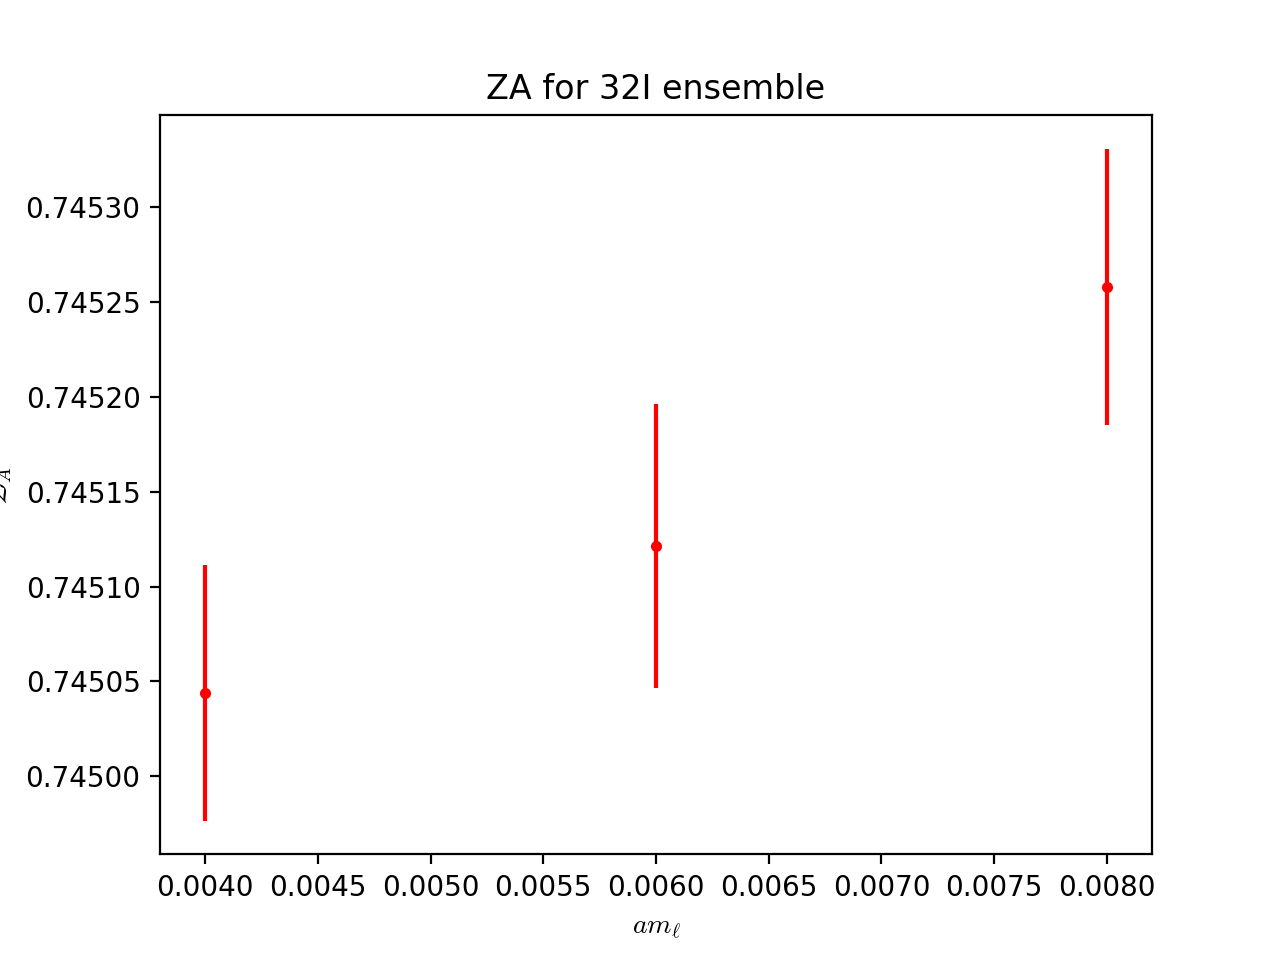

In [151]:
plt.figure()
plt.errorbar(mass_list, ZA_ens_mu, ZA_ens_std, fmt = '.', c = 'r')
plt.title('ZA for 32I ensemble')
plt.ylabel('$\mathcal{Z}_A$')
plt.xlabel('$a m_\ell$')
plt.show()

In [159]:
# linear extrapolation to amℓ = 0
n_ens = len(ZA_ens)
ZA_superboot = []
for ii in range(n_ens):
    tmp = Superboot(n_ens)
    tmp.populate_ensemble(ZA_ens[ii], ii)
    ZA_superboot.append(tmp)
fit_params, chi2_A, y_extrap_A = uncorr_linear_fit(mass_list, ZA_superboot, 0.0, label = 'ZA')
c0_boots, c1_boots = fit_params[0], fit_params[1]
c0_mu = c0_boots.compute_mean()
c0_std = c0_boots.compute_std()
c1_mu = c1_boots.compute_mean()
c1_std = c1_boots.compute_std()
print('Fit is ZA = ' + str(c1_mu) + ' + ' + str(c0_mu) + '(am_ell)')

Extrapolated result for ZA: 0.7448229389008819 \pm 0.0001520706655504395
Fit is ZA = 0.7448229389008819 + 0.053184853867042525(am_ell)


In [164]:
c0_mu

0.053184853867042525

<IPython.core.display.Javascript object>


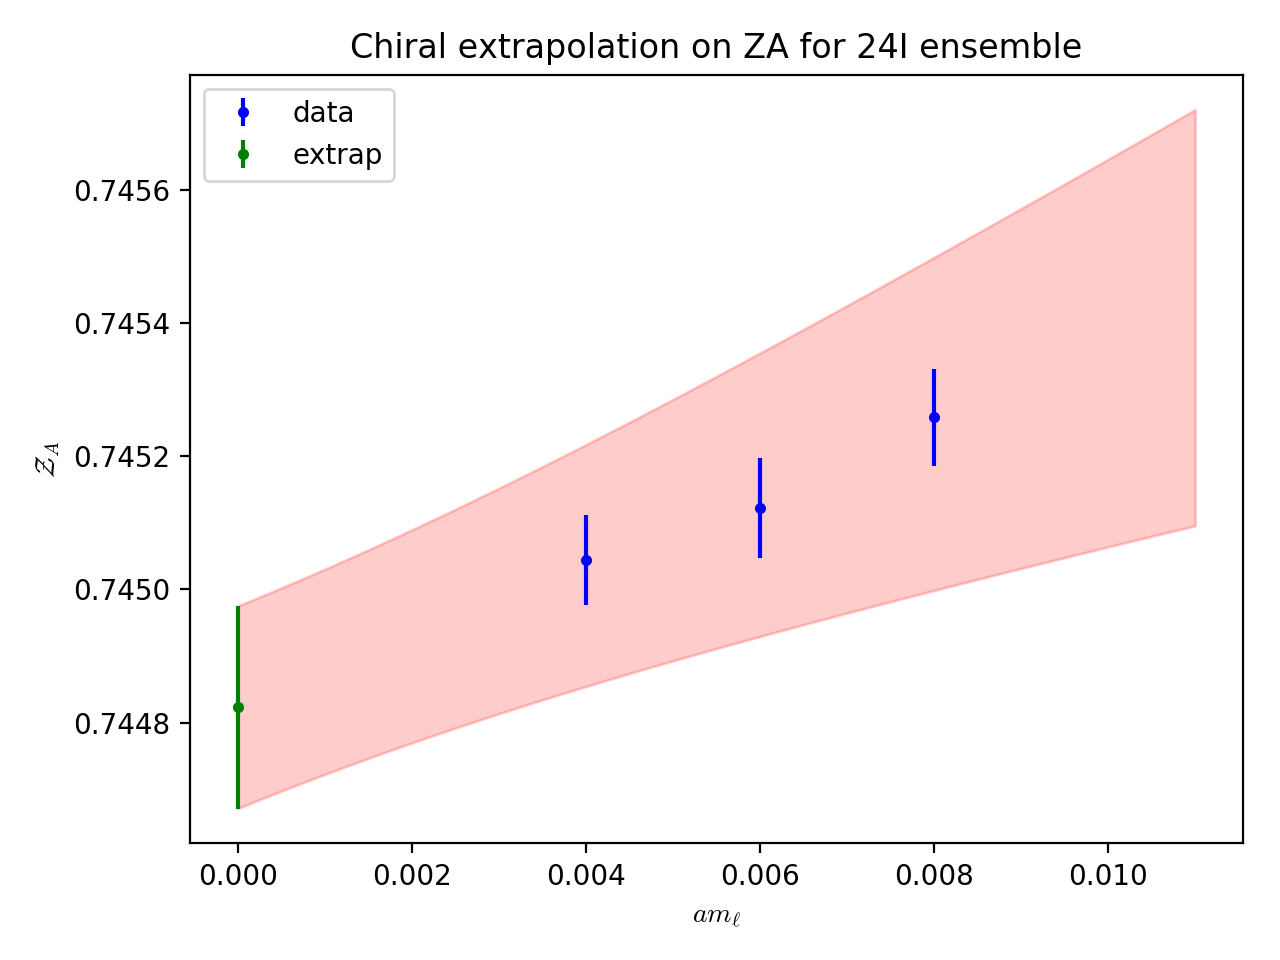

In [165]:
xx = np.linspace(0.0, 0.011)
ydat = c1_mu + c0_mu * xx
# derive this from y = c_1 + c_0 * xx
yerr = np.sqrt(c1_std ** 2 * np.ones(len(xx)) + (c0_std ** 2) * (xx ** 2))
# yerr = c1_std
plt.figure()
plt.errorbar(mass_list, ZA_ens_mu, ZA_ens_std, fmt = '.', c = 'b', label = 'data')
plt.fill_between(xx, ydat - yerr, ydat + yerr, alpha = 0.2, color = 'r')
plt.errorbar([0], [c1_mu], [c1_std], fmt = '.', c = 'g', label = 'extrap')
plt.title('Chiral extrapolation on ZA for 24I ensemble')
plt.ylabel('$\mathcal{Z}_A$')
plt.xlabel('$a m_\ell$')
plt.legend(loc = 2)
plt.tight_layout()
plt.show()

In [167]:
# ZA_out_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/24I/results/ZA.h5'
ZA_out_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/32I/results/ZA.h5'
# fA = h5py.File(ZA_out_path, 'w')
# fA['ZA'] = y_extrap_A.boots
# fA.close()